
Données et définition des features : https://data.seattle.gov/dataset/2016-Building-Energy-Benchmarking/2bpz-gwpy

Objectif : prédire la consommation totale d’énergie de bâtiments.

# Sommaire :
<a href="#C1">1. Importation des données</a>


<a href="#C2">2. Nettoyage des données</a>

     2.1 Identification des variables cibles
     
    
<a href="#C3">3. Analyse exploratoire</a>

     3.1 Création d'une ACP
     


<a href="#C4">4. Essais modélisation </a>

    4.1 Essai sur données brutes
    4.2 Transformation des variables numériques
    4.3 Essais sur données transformées
    4.4 Résultats des essais sur données transformées
    4.5 Essai avec réduction de dimensionalité
    4.6 Feature importance
  
<a href="#C5">5. Ajout energy star score</a>

     5.1 Résultats sur jeu de test
     5.2 Comparaison des résultats avec et sans energy star score
     5.3 Feature importance avec variable energy star score
     
<a href="#C6">6. Feature engineering - Troisième itération </a>

     Intérêt de EnergyStarScore


# <a name="C1">1. Importation des données</a>

In [1]:
import pandas as pd
import missingno as msno
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import time
import shap


In [2]:
data = pd.read_csv('2016_Building_Energy_Benchmarking.csv')

In [3]:
data.shape

(3376, 46)

In [4]:
data.head()

OSEBuildingID  DataYear    BuildingType PrimaryPropertyType  \
0              1      2016  NonResidential               Hotel   
1              2      2016  NonResidential               Hotel   
2              3      2016  NonResidential               Hotel   
3              5      2016  NonResidential               Hotel   
4              8      2016  NonResidential               Hotel   

                  PropertyName          Address     City State  ZipCode  \
0         Mayflower park hotel    405 Olive way  Seattle    WA  98101.0   
1              Paramount Hotel  724 Pine street  Seattle    WA  98101.0   
2      5673-The Westin Seattle  1900 5th Avenue  Seattle    WA  98101.0   
3                    HOTEL MAX   620 STEWART ST  Seattle    WA  98101.0   
4  WARWICK SEATTLE HOTEL (ID8)    401 LENORA ST  Seattle    WA  98121.0   

  TaxParcelIdentificationNumber  ...  Electricity(kWh) Electricity(kBtu)  \
0                    0659000030  ...      1.156514e+06         3946027.0   
1                    0659000220  ...      9.504252e+05         3242851.0   
2                    0659000475  ...      1.451544e+07        49526664.0   
3                    0659000640  ...      8.115253e+05         2768924.0   
4                    0659000970  ...      1.573449e+06         5368607.0   

   NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  Comments  \
0         12764.52930         1276453.0        False       NaN   
1         51450.81641         5145082.0        False       NaN   
2         14938.00000         1493800.0        False       NaN   
3         18112.13086         1811213.0        False       NaN   
4         88039.98438         8803998.0        False       NaN   

   ComplianceStatus  Outlier  TotalGHGEmissions  GHGEmissionsIntensity  
0         Compliant      NaN             249.98                   2.83  
1         Compliant      NaN             295.86                   2.86  
2         Compliant      NaN            2089.28                   2.19  
3         Compliant      NaN             286.43                   4.67  
4         Compliant      NaN             505.01                   2.88  

[5 rows x 46 columns]

Affichage des valeurs manquantes

<Axes: >

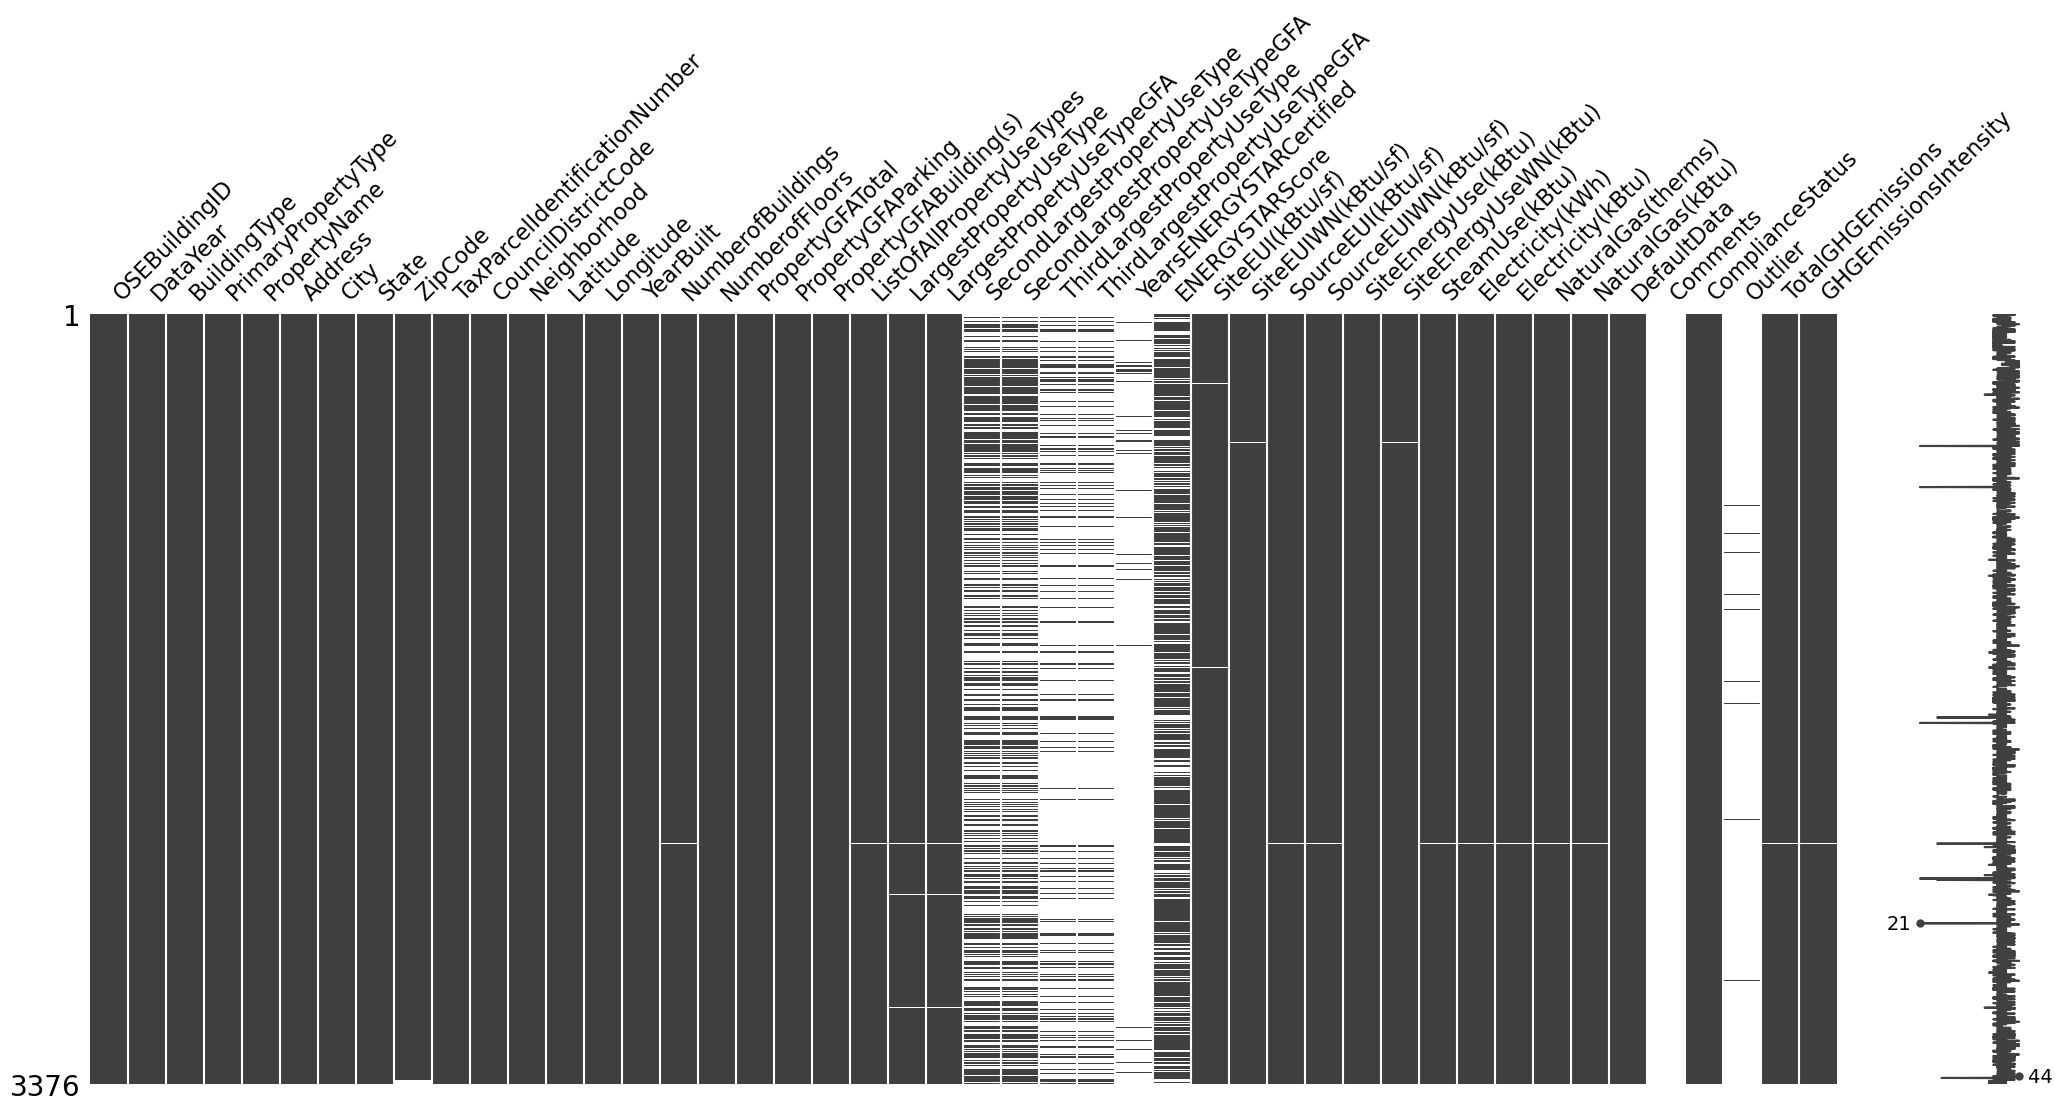

In [5]:
msno.matrix(data)

Repartition par type de natiment

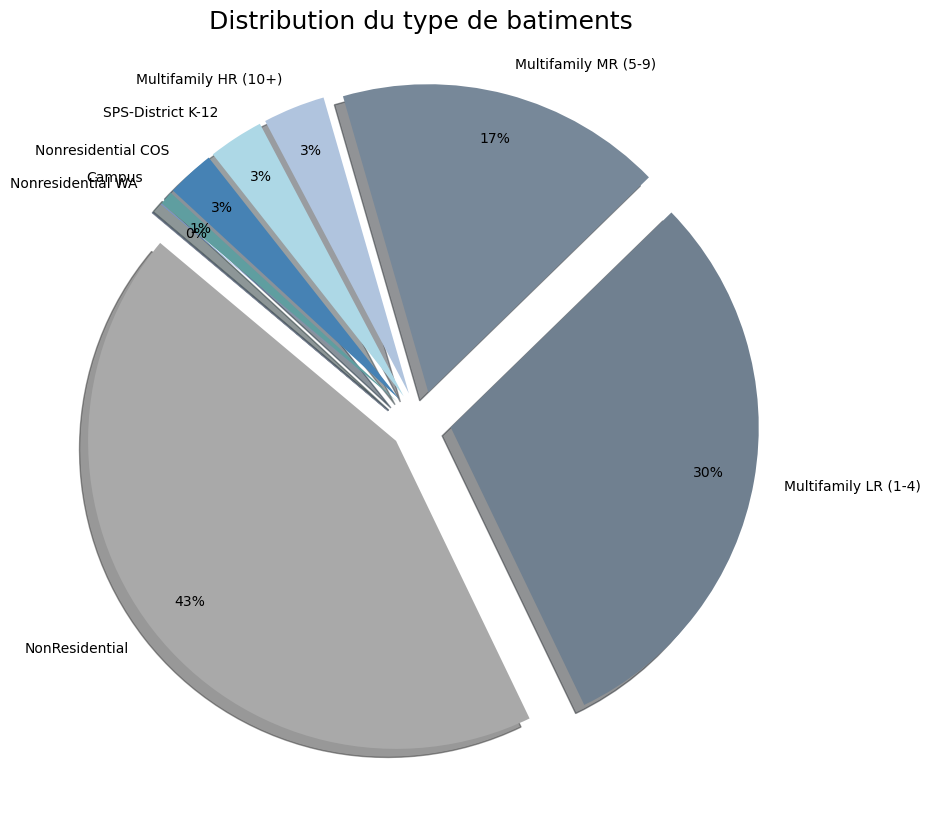

In [6]:
plt.figure(figsize=(10, 10))


custom_colors = ['#a9a9a9', '#708090', '#778899', '#b0c4de', '#add8e6', '#4682b4', '#5f9ea0', '#6495ed']

explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)

plt.pie(data['BuildingType'].value_counts(), 
        labels=data['BuildingType'].value_counts().index, 
        colors=custom_colors, 
        explode=explode,
        autopct='%1.0f%%', 
        shadow=True, 
        startangle=140,
        pctdistance=0.85)

plt.title('Distribution du type de batiments', fontsize=18)
plt.show()


Filtrage des habitations residentielles

In [7]:
non_residential_mask = data['BuildingType'] == 'NonResidential'
non_residential = data[non_residential_mask]
other = data[~non_residential_mask]

In [8]:
non_residential['PrimaryPropertyType'].unique()

array(['Hotel', 'Other', 'Mixed Use Property', 'University',
       'Small- and Mid-Sized Office', 'Self-Storage Facility',
       'Warehouse', 'K-12 School', 'Large Office',
       'Senior Care Community', 'Medical Office', 'Retail Store',
       'Hospital', 'Residence Hall', 'Worship Facility',
       'Supermarket / Grocery Store', 'Distribution Center', 'Laboratory',
       'Refrigerated Warehouse', 'Restaurant', 'Low-Rise Multifamily'],
      dtype=object)

In [9]:
other['PrimaryPropertyType'].unique()

array(['Other', 'Mid-Rise Multifamily', 'K-12 School',
       'Mixed Use Property', 'University', 'Warehouse',
       'Small- and Mid-Sized Office', 'Distribution Center',
       'Large Office', 'Low-Rise Multifamily', 'High-Rise Multifamily',
       'Senior Care Community', 'Restaurant', 'Medical Office', 'Hotel',
       'Residence Hall', 'Office'], dtype=object)

In [10]:
#on supprime les Low-Rise Multifamily
mask = non_residential['PrimaryPropertyType'] == 'Low-Rise Multifamily'
non_residential = non_residential[~mask]


Repartition des batiments non residentiels

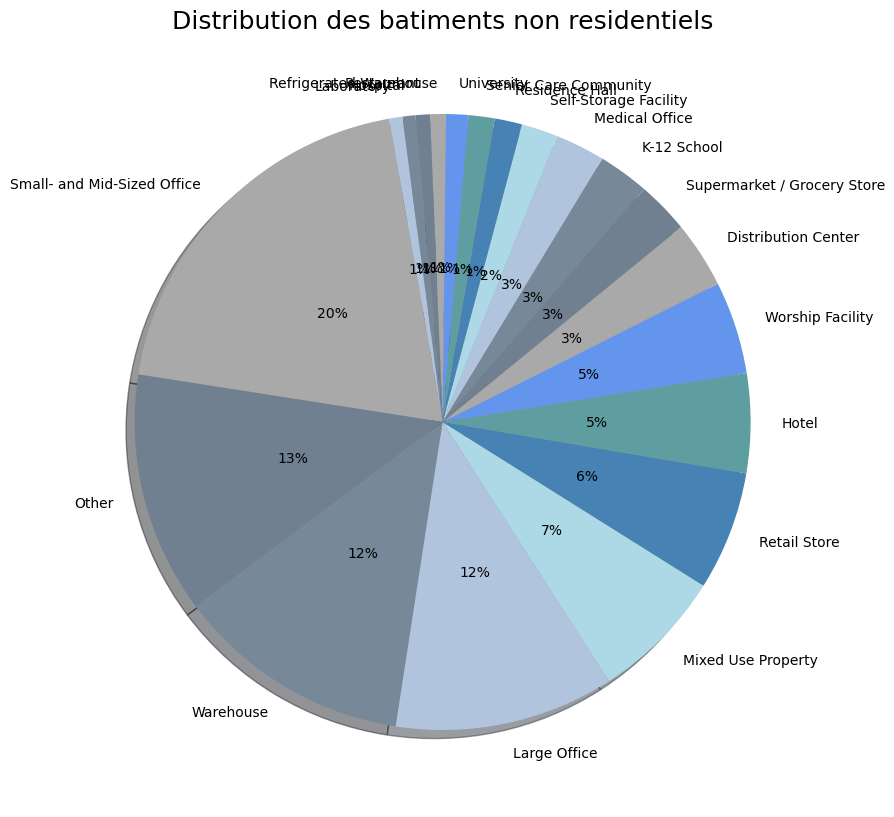

In [11]:

plt.figure(figsize=(10,10))


explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)  

plt.pie(non_residential['PrimaryPropertyType'].value_counts(), 
        labels=non_residential['PrimaryPropertyType'].value_counts().index, 
        colors=custom_colors, 
        
        autopct='%1.0f%%', 
        shadow=True, 
        startangle=100,
        pctdistance=0.5)
plt.title('Distribution des batiments non residentiels', fontsize=18)
plt.show()



# <a name="C2">2. Nettoyage des données</a>

Identification des outliers ( on dispose d'une variable nommée 'outliers')

In [12]:
#affichage des outliers
non_residential['Outlier'].value_counts()

Outlier
Low outlier     12
High outlier     2
Name: count, dtype: int64

In [13]:
#affichage des outliers low et high
print('high outliers ' + str( non_residential.loc[(non_residential['Outlier']=='High outlier')].shape))
print('low outliers ' + str( non_residential.loc[(non_residential['Outlier']=='Low outlier')].shape))

high outliers (2, 46)
low outliers (12, 46)


Suppression des bâtiments High et Low outliers

In [14]:
# Suppression des bâtiments High et Low outliers
outlier_mask=(non_residential['Outlier']=='Low outlier')|(non_residential['Outlier']=='High outlier')
non_residential=non_residential.loc[~outlier_mask]

In [15]:
#recherche des batiments pas compliants
non_residential['ComplianceStatus'].unique().tolist()

['Compliant', 'Error - Correct Default Data', 'Non-Compliant', 'Missing Data']

Suppression des batiments non conformes

In [16]:
#affichage des batiments compliant et non compliant
print('compliant ' + str(non_residential.loc[non_residential['ComplianceStatus']=='Compliant'].shape))
print('non-compliant: ' + str(non_residential.loc[~(non_residential['ComplianceStatus'] == 'Compliant')].shape[0]))


compliant (1431, 46)
non-compliant: 13


On conserve uniquement les bâtiments qui ont status "Compliant"

In [17]:
# On conserve uniquement les bâtiments qui ont status "Compliant"
non_residential=non_residential.loc[non_residential['ComplianceStatus']=='Compliant']

Recherche des valeurs négatives

In [18]:
#on affiche les valeurs négatives
non_residential.describe().loc['min']

OSEBuildingID                           1.00000
DataYear                             2016.00000
ZipCode                             98006.00000
CouncilDistrictCode                     1.00000
Latitude                               47.50959
Longitude                            -122.41182
YearBuilt                            1900.00000
NumberofBuildings                       0.00000
NumberofFloors                          0.00000
PropertyGFATotal                    16300.00000
PropertyGFAParking                      0.00000
PropertyGFABuilding(s)               3636.00000
LargestPropertyUseTypeGFA            5656.00000
SecondLargestPropertyUseTypeGFA         0.00000
ThirdLargestPropertyUseTypeGFA          0.00000
ENERGYSTARScore                         1.00000
SiteEUI(kBtu/sf)                        1.40000
SiteEUIWN(kBtu/sf)                      0.00000
SourceEUI(kBtu/sf)                      0.00000
SourceEUIWN(kBtu/sf)                   -2.10000
SiteEnergyUse(kBtu)                 5713

Suppression de la ligne avec des valeurs négatives

In [19]:

non_residential[non_residential['GHGEmissionsIntensity']<0]

OSEBuildingID  DataYear    BuildingType          PrimaryPropertyType  \
3206          49784      2016  NonResidential  Small- and Mid-Sized Office   

        PropertyName              Address     City State  ZipCode  \
3206  Bullitt Center  1501 E. Madison St.  Seattle    WA  98122.0   

     TaxParcelIdentificationNumber  ...  Electricity(kWh) Electricity(kBtu)  \
3206                    7234600195  ...      -33826.80078         -115417.0   

      NaturalGas(therms)  NaturalGas(kBtu)  DefaultData  Comments  \
3206                 0.0               0.0        False       NaN   

      ComplianceStatus  Outlier  TotalGHGEmissions  GHGEmissionsIntensity  
3206         Compliant      NaN               -0.8                  -0.02  

[1 rows x 46 columns]

In [20]:
non_residential.drop(3206, inplace=True)

## 2.1 Identification des variables cibles

"SiteEnergyUse(kBtu)" = conso totale.

"TotalGHGEmissions" = emission total gaz effet de serre

Filtrage des colonnes retenues

In [21]:

features_retenues =[
                    #Features :
                    'Latitude',
                    'Longitude',
                    'BuildingType',
                    'PrimaryPropertyType',
                    'Neighborhood',
                    'YearBuilt',
                    'NumberofBuildings',
                    'NumberofFloors',
                    'PropertyGFATotal',
                    'PropertyGFAParking',
                    'ENERGYSTARScore',
                    'LargestPropertyUseType', 
                     'LargestPropertyUseTypeGFA',
                    


                   #Targets :
                    'SiteEnergyUse(kBtu)',
                    'TotalGHGEmissions'] 


                
                    
                    
                   
    


In [22]:
#filtrage du dataset
ds_w_features = non_residential[features_retenues]
ds_w_features

Latitude  Longitude    BuildingType          PrimaryPropertyType  \
0     47.61220 -122.33799  NonResidential                        Hotel   
1     47.61317 -122.33393  NonResidential                        Hotel   
2     47.61393 -122.33810  NonResidential                        Hotel   
3     47.61412 -122.33664  NonResidential                        Hotel   
4     47.61375 -122.34047  NonResidential                        Hotel   
...        ...        ...             ...                          ...   
3338  47.54425 -122.31776  NonResidential                    Warehouse   
3339  47.53161 -122.29944  NonResidential  Small- and Mid-Sized Office   
3340  47.68109 -122.26180  NonResidential                        Other   
3347  47.58831 -122.30650  NonResidential                  K-12 School   
3356  47.62497 -122.33883  NonResidential           Mixed Use Property   

          Neighborhood  YearBuilt  NumberofBuildings  NumberofFloors  \
0             DOWNTOWN       1927                1.0              12   
1             DOWNTOWN       1996                1.0              11   
2             DOWNTOWN       1969                1.0              41   
3             DOWNTOWN       1926                1.0              10   
4             DOWNTOWN       1980                1.0              18   
...                ...        ...                ...             ...   
3338  GREATER DUWAMISH       1955                1.0               1   
3339  GREATER DUWAMISH       1929                1.0               2   
3340         NORTHEAST       2013                1.0               1   
3347  GREATER DUWAMISH       2015                1.0               3   
3356        LAKE UNION       2015                1.0               6   

      PropertyGFATotal  PropertyGFAParking  ENERGYSTARScore  \
0                88434                   0             60.0   
1               103566               15064             61.0   
2               956110              196718             43.0   
3                61320                   0             56.0   
4               175580               62000             75.0   
...                ...                 ...              ...   
3338             52085                4222             37.0   
3339             24990                   0              9.0   
3340             72000                   0              NaN   
3347             45000                   0             77.0   
3356            345290               85028              NaN   

          LargestPropertyUseType  LargestPropertyUseTypeGFA  \
0                          Hotel                    88434.0   
1                          Hotel                    83880.0   
2                          Hotel                   756493.0   
3                          Hotel                    61320.0   
4                          Hotel                   123445.0   
...                          ...                        ...   
3338  Non-Refrigerated Warehouse                    52085.0   
3339                      Office                    24990.0   
3340          Other - Recreation                    72000.0   
3347                 K-12 School                    45728.0   
3356                  Laboratory                   151523.0   

      SiteEnergyUse(kBtu)  TotalGHGEmissions  
0              7226362.50             249.98  
1              8387933.00             295.86  
2             72587024.00            2089.28  
3              6794584.00             286.43  
4             14172606.00             505.01  
...                   ...                ...  
3338           3605855.50             157.70  
3339           4420650.50             134.80  
3340           2925780.00              67.65  
3347           1325972.75               9.24  
3356          39364116.00            1000.06  

[1430 rows x 15 columns]

<Axes: >

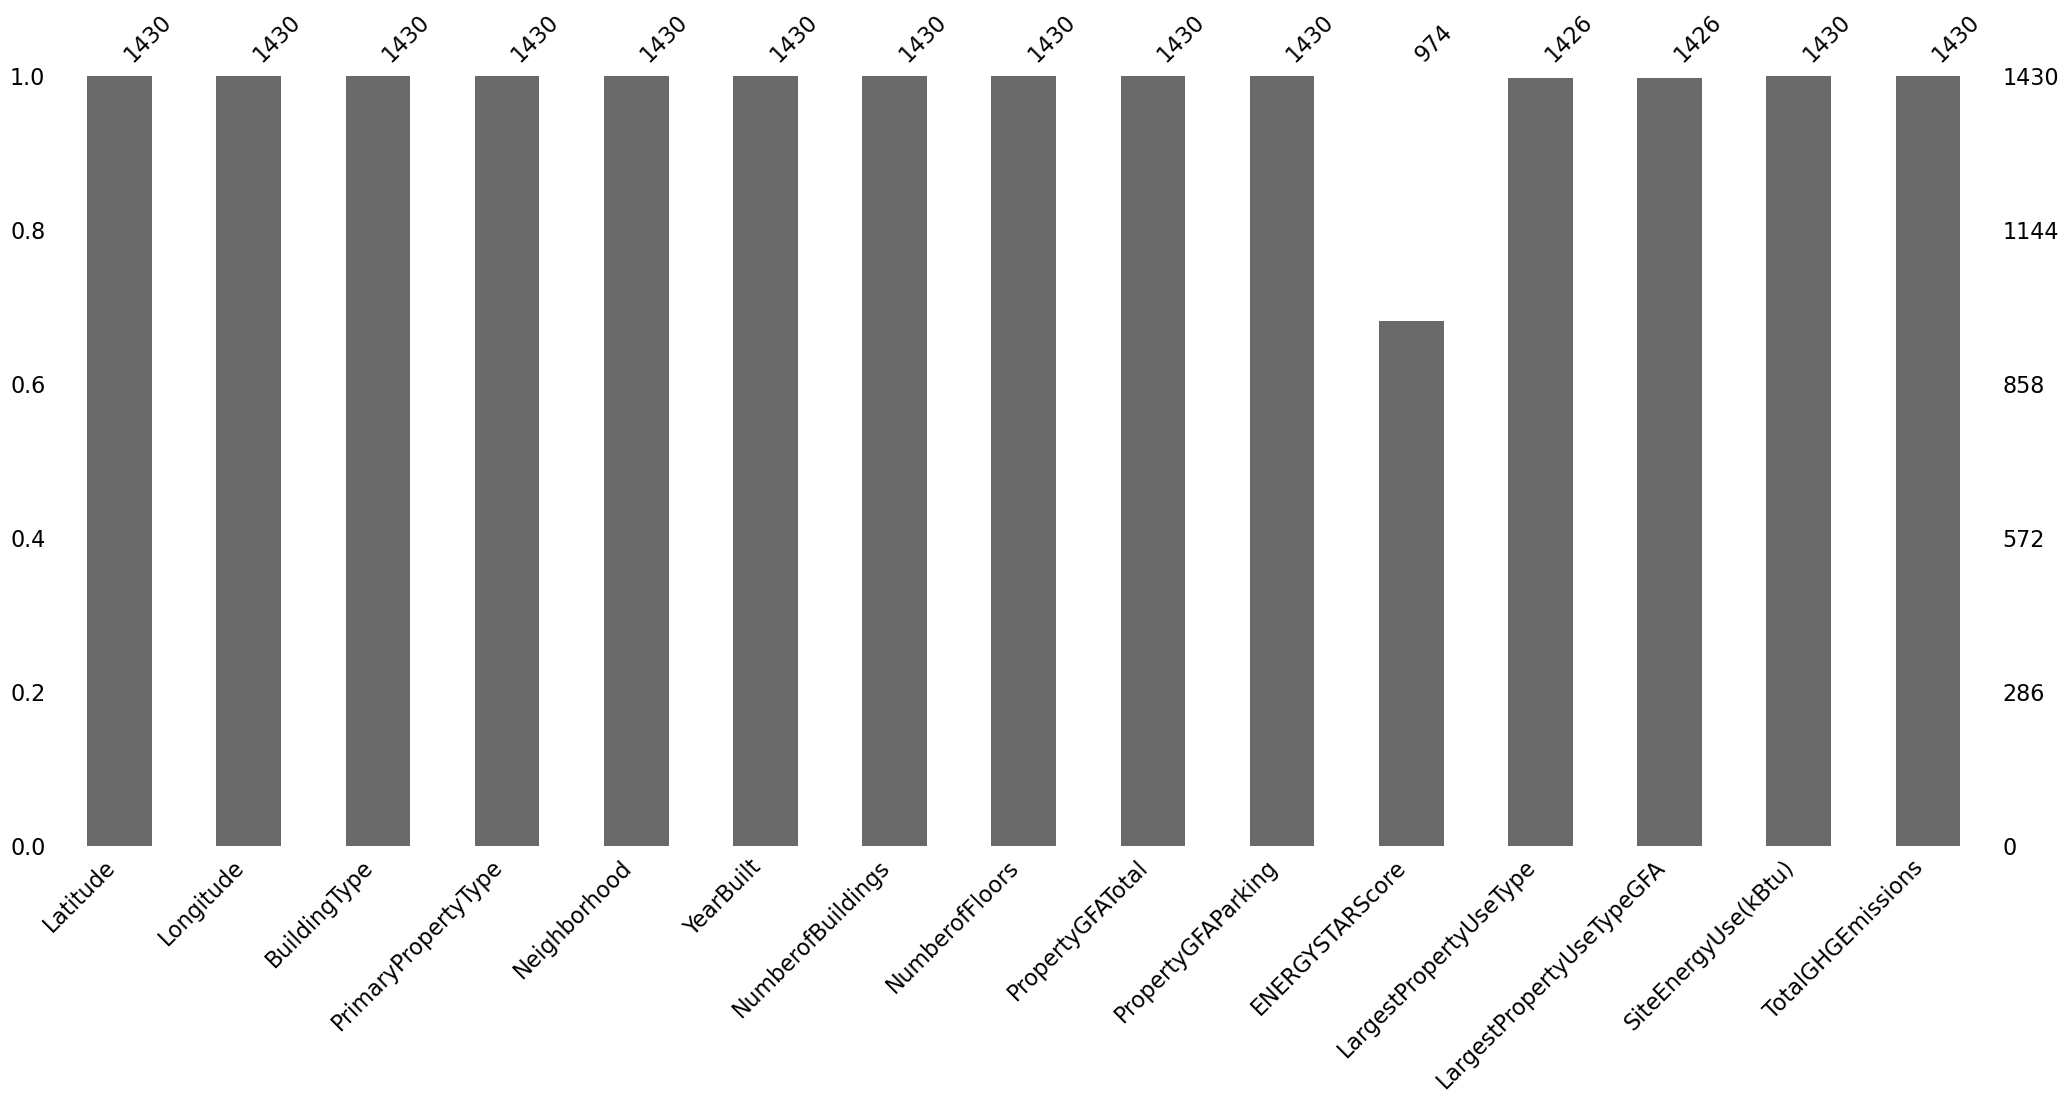

In [23]:
msno.bar(ds_w_features)

In [24]:
#filtrage des colonnes numériques
colonnes_numériques = ['YearBuilt','NumberofBuildings','NumberofFloors','PropertyGFATotal','PropertyGFAParking','SiteEnergyUse(kBtu)','TotalGHGEmissions','Latitude','Longitude']
numeric_columns = ds_w_features[colonnes_numériques]

In [25]:
#filtrage des colonnes catégoriques
colonnes_categoriques = ['BuildingType','PrimaryPropertyType','Neighborhood',]
categorical_columns = ds_w_features[colonnes_categoriques]

In [26]:

numeric_columns


YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
0          1927                1.0              12             88434   
1          1996                1.0              11            103566   
2          1969                1.0              41            956110   
3          1926                1.0              10             61320   
4          1980                1.0              18            175580   
...         ...                ...             ...               ...   
3338       1955                1.0               1             52085   
3339       1929                1.0               2             24990   
3340       2013                1.0               1             72000   
3347       2015                1.0               3             45000   
3356       2015                1.0               6            345290   

      PropertyGFAParking  SiteEnergyUse(kBtu)  TotalGHGEmissions  Latitude  \
0                      0           7226362.50             249.98  47.61220   
1                  15064           8387933.00             295.86  47.61317   
2                 196718          72587024.00            2089.28  47.61393   
3                      0           6794584.00             286.43  47.61412   
4                  62000          14172606.00             505.01  47.61375   
...                  ...                  ...                ...       ...   
3338                4222           3605855.50             157.70  47.54425   
3339                   0           4420650.50             134.80  47.53161   
3340                   0           2925780.00              67.65  47.68109   
3347                   0           1325972.75               9.24  47.58831   
3356               85028          39364116.00            1000.06  47.62497   

      Longitude  
0    -122.33799  
1    -122.33393  
2    -122.33810  
3    -122.33664  
4    -122.34047  
...         ...  
3338 -122.31776  
3339 -122.29944  
3340 -122.26180  
3347 -122.30650  
3356 -122.33883  

[1430 rows x 9 columns]

In [27]:
categorical_columns

BuildingType          PrimaryPropertyType      Neighborhood
0     NonResidential                        Hotel          DOWNTOWN
1     NonResidential                        Hotel          DOWNTOWN
2     NonResidential                        Hotel          DOWNTOWN
3     NonResidential                        Hotel          DOWNTOWN
4     NonResidential                        Hotel          DOWNTOWN
...              ...                          ...               ...
3338  NonResidential                    Warehouse  GREATER DUWAMISH
3339  NonResidential  Small- and Mid-Sized Office  GREATER DUWAMISH
3340  NonResidential                        Other         NORTHEAST
3347  NonResidential                  K-12 School  GREATER DUWAMISH
3356  NonResidential           Mixed Use Property        LAKE UNION

[1430 rows x 3 columns]

# <a name="C3">3. Analyse exploratoire</a>

Affichage de la distribution des valeurs pour les colones quantitatives

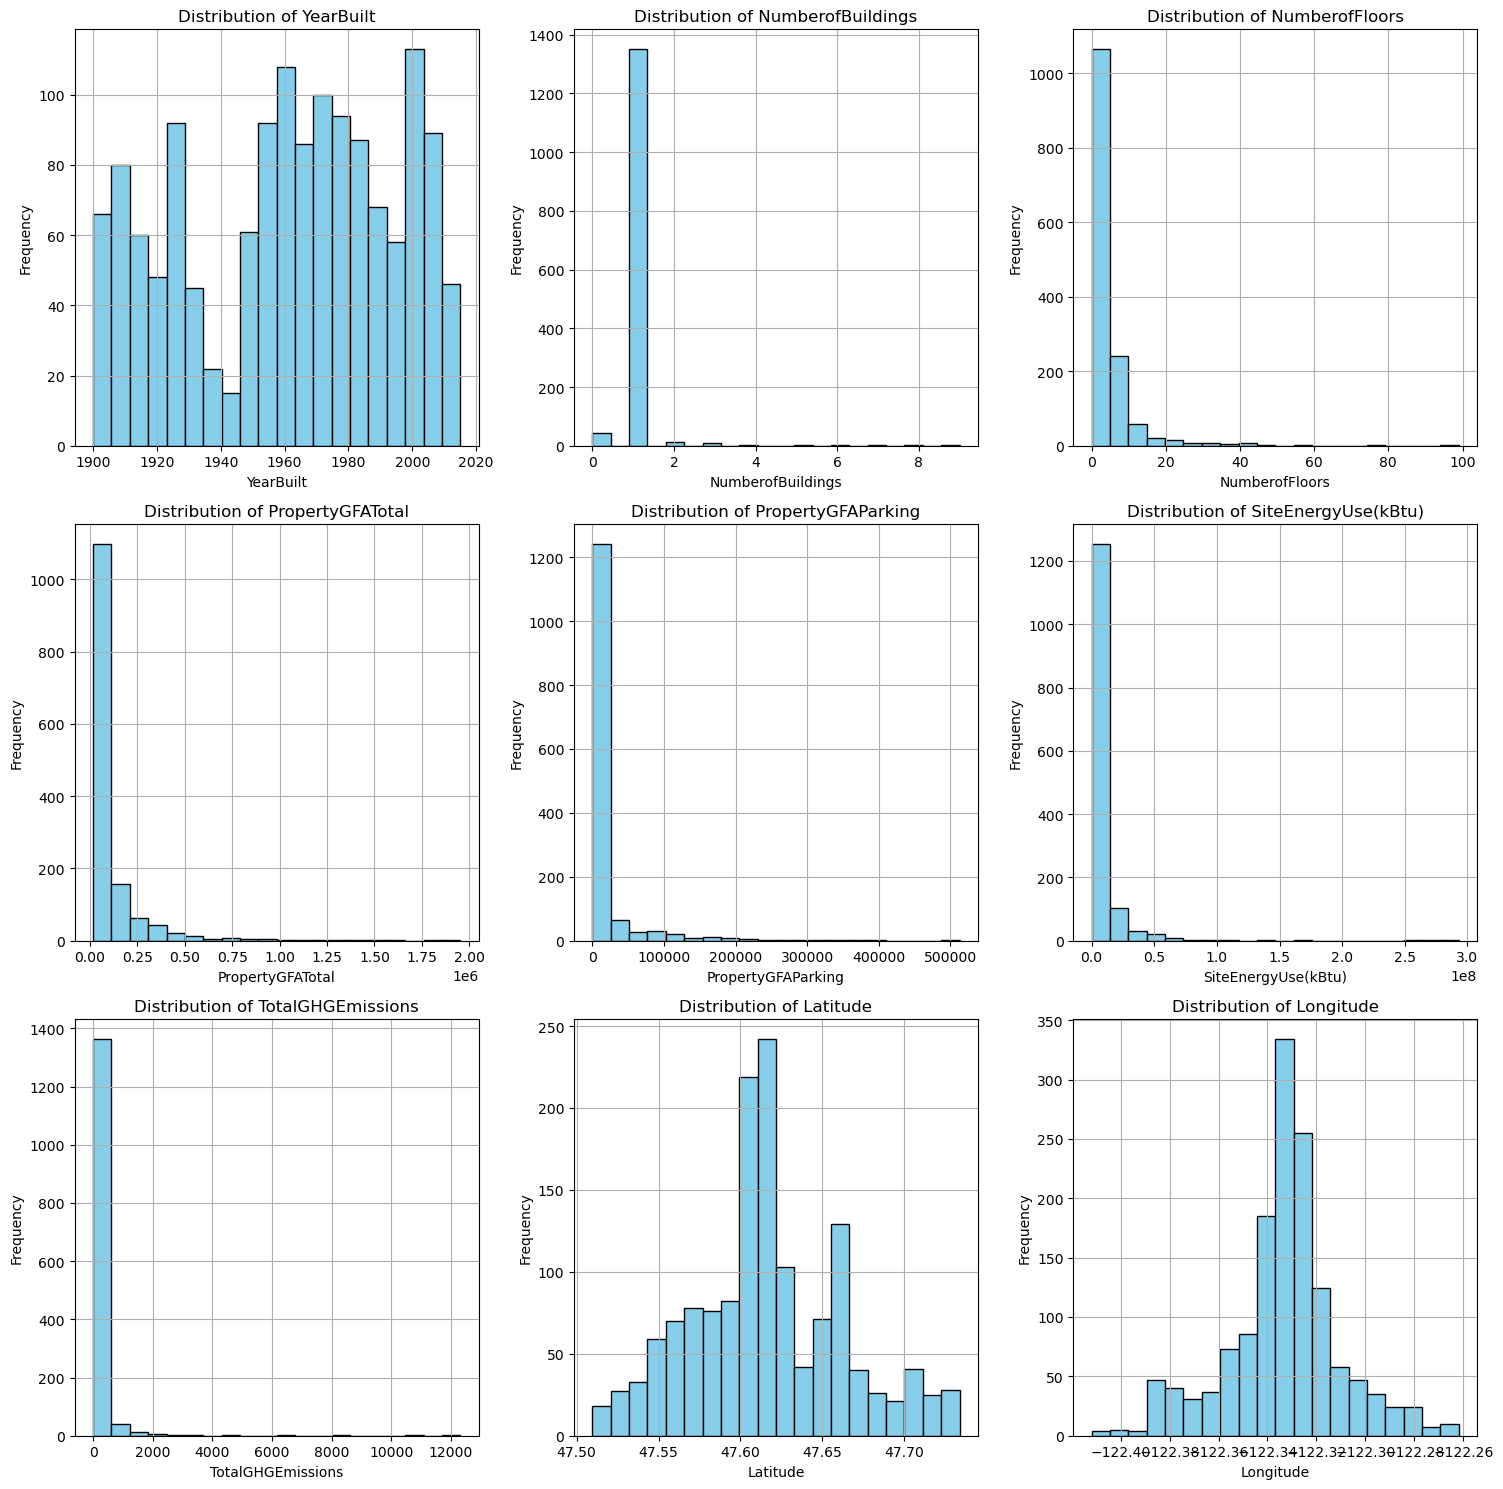

In [28]:


# Number of columns per row
columns_per_row = 3

# Calculate number of rows
num_columns = len(numeric_columns.columns)
num_rows = (num_columns - 1) // columns_per_row + 1

# Plot histograms for each numeric column in rows of 3
fig, axes = plt.subplots(num_rows, columns_per_row, figsize=(15, 5*num_rows))
for i, column in enumerate(numeric_columns.columns):
    row_index = i // columns_per_row
    col_index = i % columns_per_row
    ax = axes[row_index, col_index]
    ax.hist(numeric_columns[column], bins=20, color='skyblue', edgecolor='black')
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Frequency')
    ax.grid(True)

# Hide empty subplots
if num_columns % columns_per_row != 0:
    for i in range(num_columns % columns_per_row, columns_per_row):
        fig.delaxes(axes[num_rows - 1, i])

plt.tight_layout()
plt.show()


Boxplot pour les valeurs quantitatives

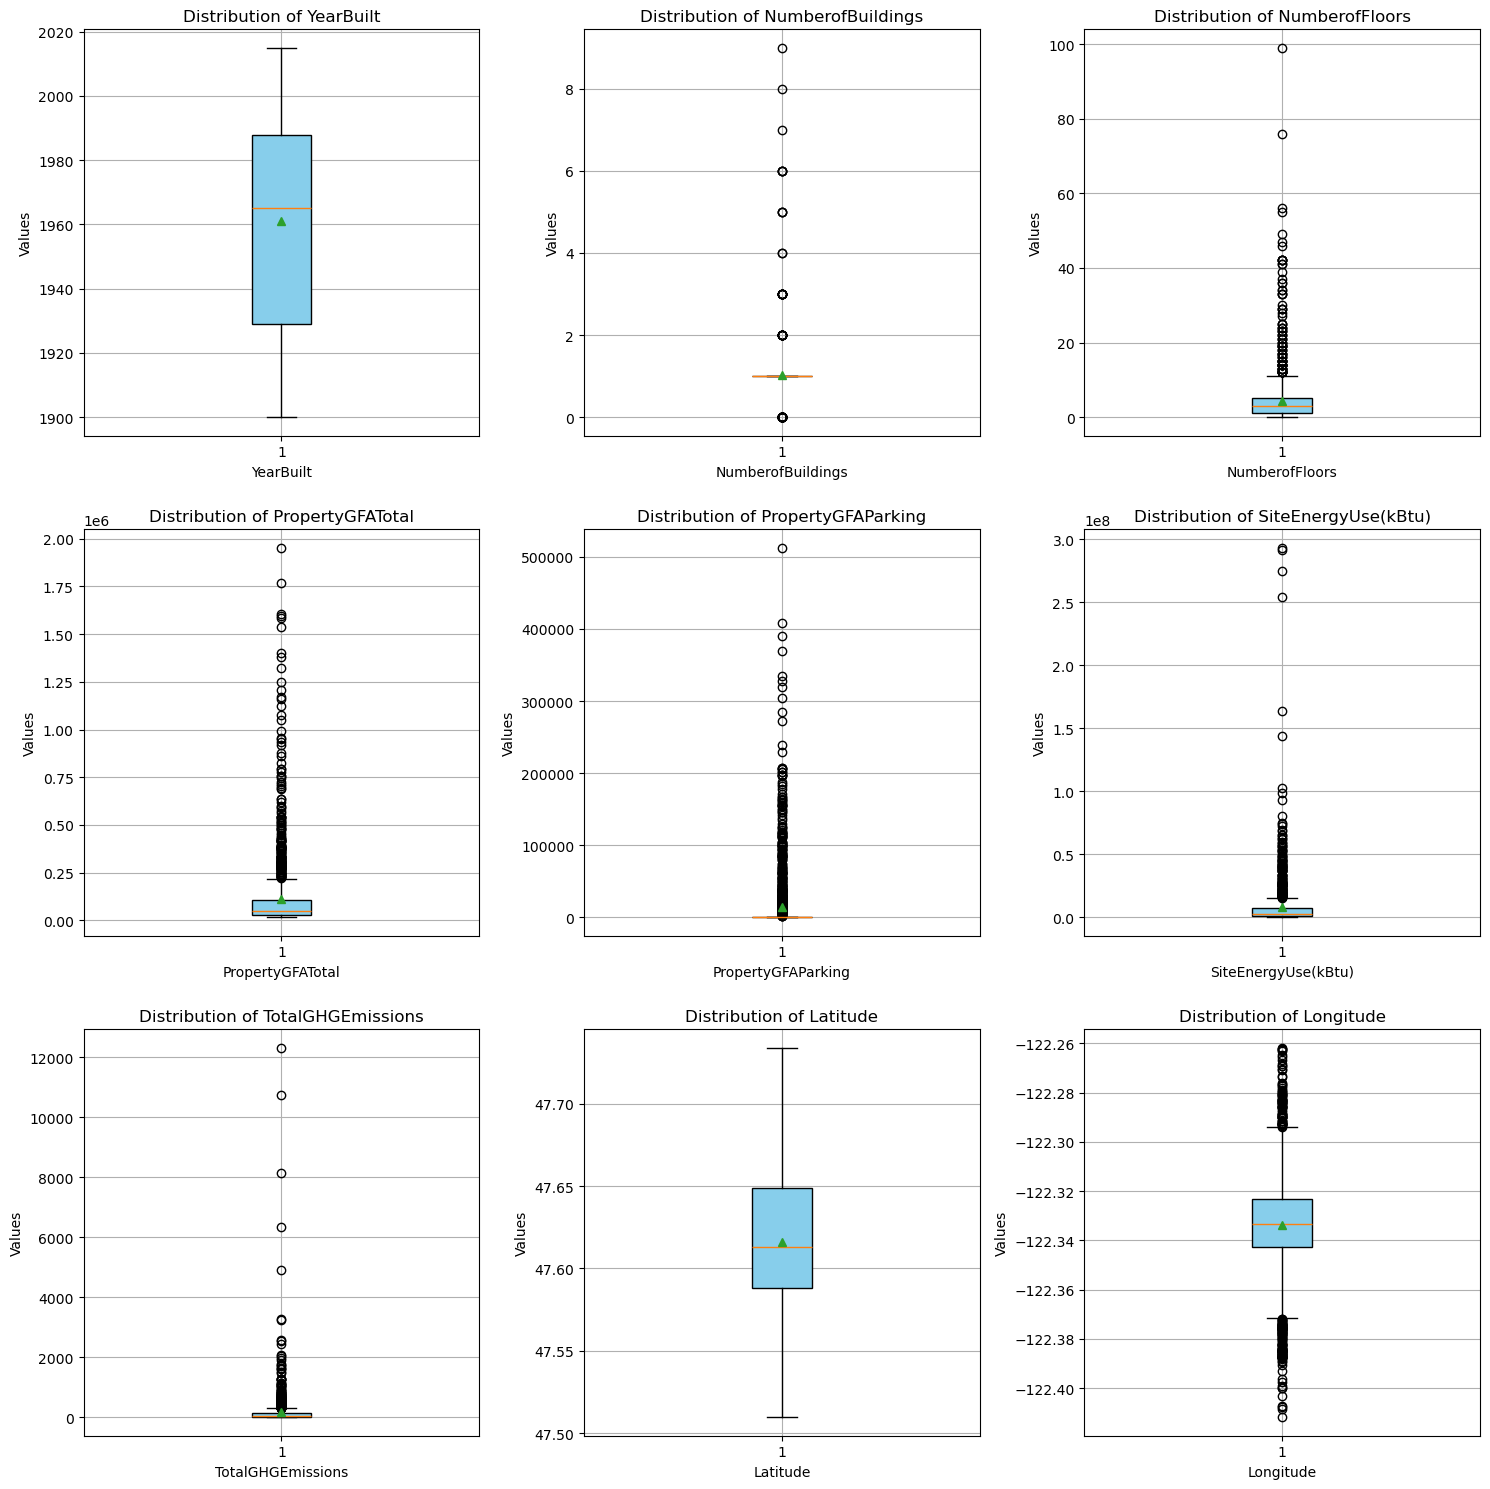

In [29]:

# nombre de colonnes par ligne
columns_per_row = 3

# calcul du nombre de lignes nécessaires pour afficher les boxplots
num_columns = len(numeric_columns.columns)
num_rows = (num_columns - 1) // columns_per_row + 1

# Affichage des boxplots
fig, axes = plt.subplots(num_rows, columns_per_row, figsize=(15, 5*num_rows))
for i, column in enumerate(numeric_columns.columns):
    row_index = i // columns_per_row
    col_index = i % columns_per_row
    ax = axes[row_index, col_index]
    ax.boxplot(numeric_columns[column], patch_artist=True, showmeans=True, 
               boxprops=dict(facecolor='skyblue'))
    ax.set_title(f'Distribution of {column}')
    ax.set_xlabel(column)
    ax.set_ylabel('Values')
    ax.grid(True)

# cahce les axes inutilisés
if num_columns % columns_per_row != 0:
    for i in range(num_columns % columns_per_row, columns_per_row):
        fig.delaxes(axes[num_rows - 1, i])

plt.tight_layout()
plt.show() 




Repartition des types de propriété

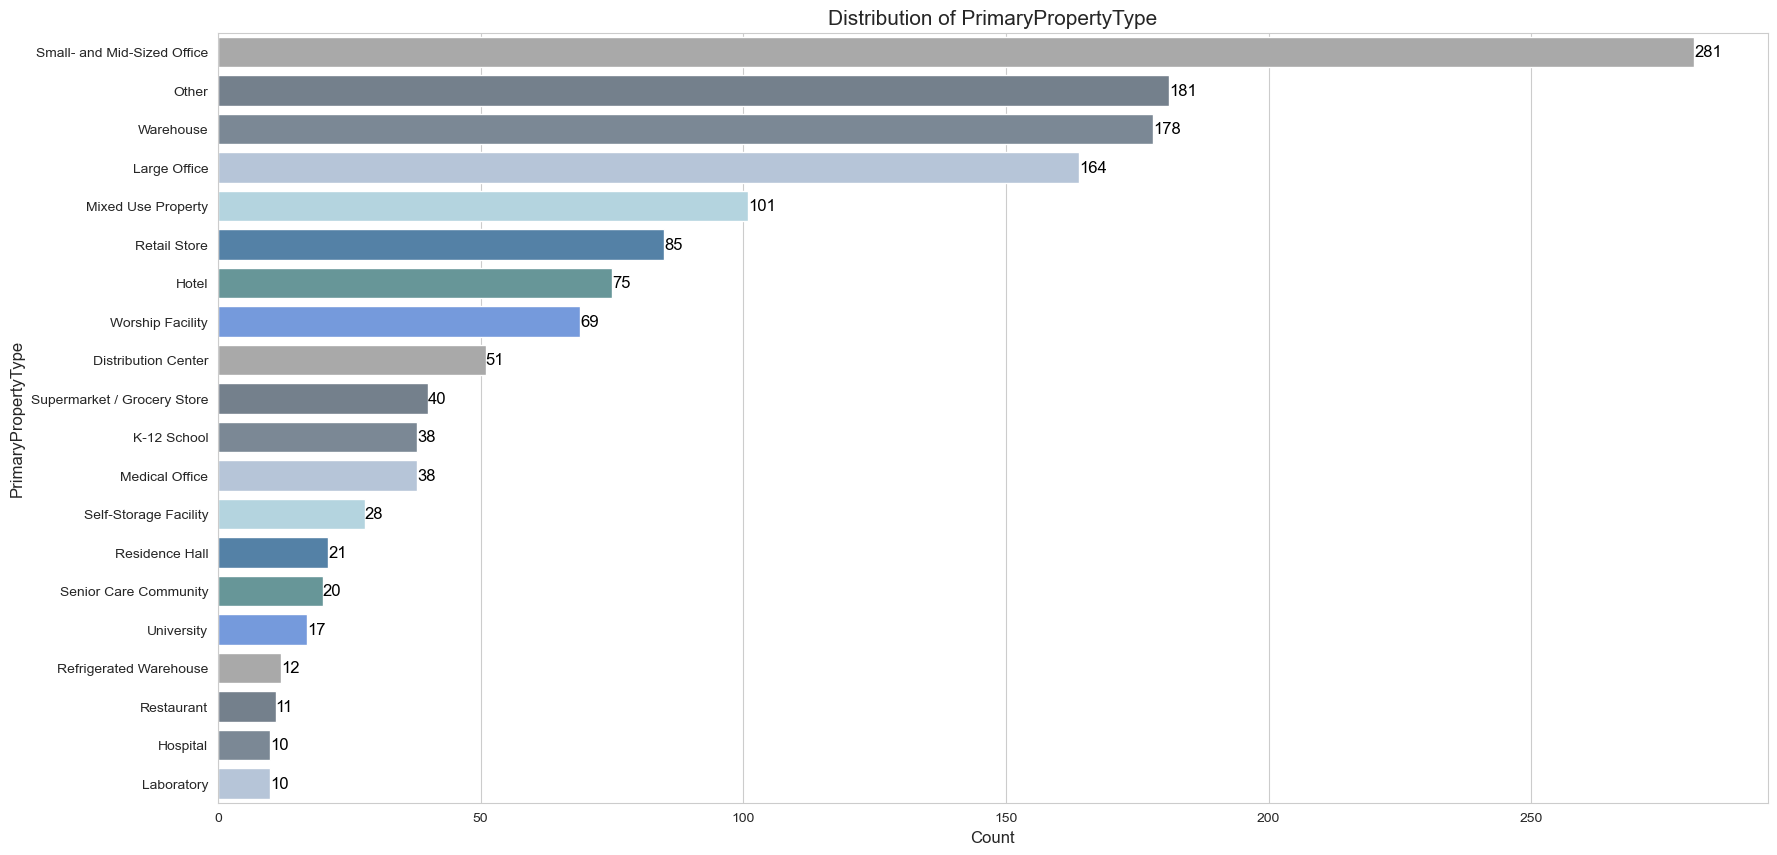

In [30]:
# nombre de colonnes par ligne
category_counts = categorical_columns['PrimaryPropertyType'].value_counts(normalize=True).sort_values(ascending=False)

# extraction des labels et des valeurs
labels = category_counts.index


sns.set_style("whitegrid")
colors = sns.color_palette("pastel")

# Plot des counts
fig, ax = plt.subplots(figsize=(20, 10))
sns.countplot(y=categorical_columns['PrimaryPropertyType'], order=labels, palette=custom_colors, ax=ax)
plt.title('Distribution of PrimaryPropertyType', fontsize=15)
plt.xlabel('Count', fontsize=12)
plt.ylabel('PrimaryPropertyType', fontsize=12)

# Ajout des nombres sur les barres
for container in ax.containers:
    ax.bar_label(container, fontsize=12, fmt='%d', color='black')

plt.show()



In [31]:
#formatage des colonnes en majuscule
categorical_columns['Neighborhood'] = categorical_columns['Neighborhood'].str.upper()

C:\Users\jules\AppData\Local\Temp\ipykernel_21172\569295069.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_columns['Neighborhood'] = categorical_columns['Neighborhood'].str.upper()


In [32]:
categorical_columns['Neighborhood'].nunique()

13

Affichage des matrice de correlations pour les variables numériques

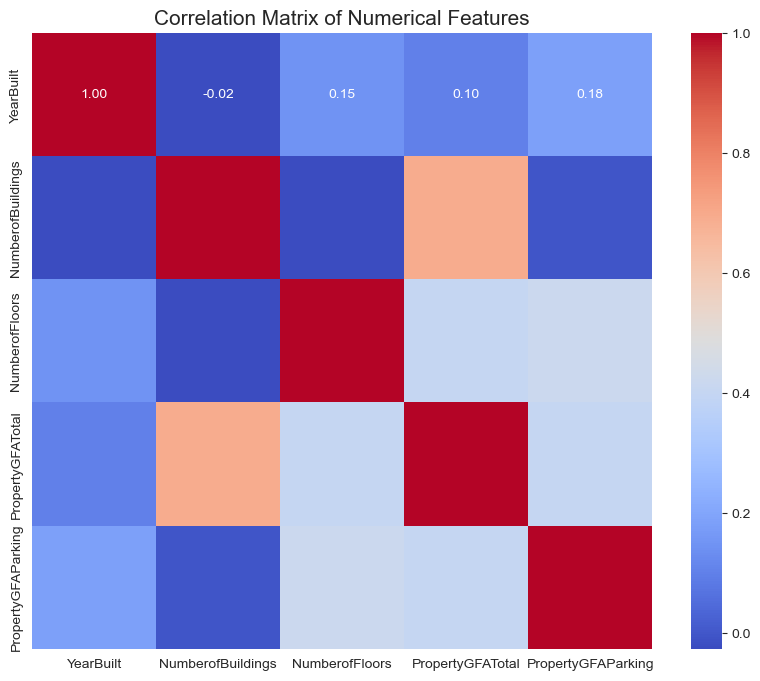

In [33]:
#matrice des correlation des variables numériques
numerical_features = ['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking']


numerical_data = data[numerical_features]


correlation_matrix = numerical_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features',fontsize=15)


plt.show()




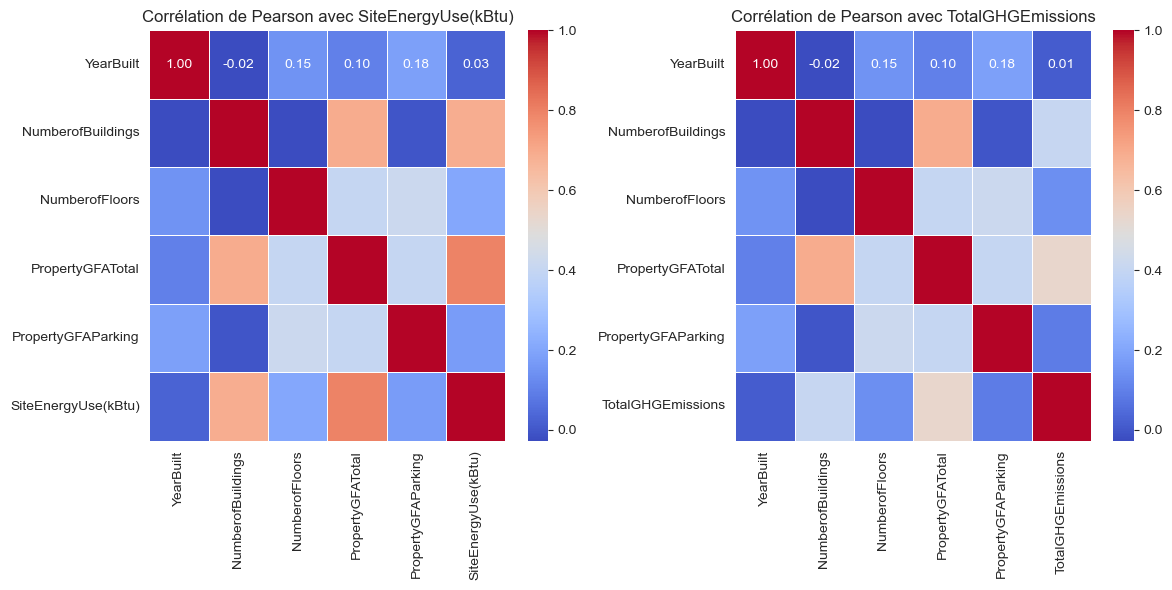

In [34]:


variables_site_energy = ['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'SiteEnergyUse(kBtu)']
variables_ghg_emissions = ['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'TotalGHGEmissions']

correlation_site_energy = data[variables_site_energy].corr(method='pearson')
correlation_ghg_emissions = data[variables_ghg_emissions].corr(method='pearson')

# Afficher les matrices de corrélation
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.heatmap(correlation_site_energy, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Corrélation de Pearson avec SiteEnergyUse(kBtu)')
plt.subplot(1, 2, 2)
sns.heatmap(correlation_ghg_emissions, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Corrélation de Pearson avec TotalGHGEmissions')
plt.tight_layout()
plt.show()


## 3.1 Création d'une ACP


In [35]:
dataACP=numeric_columns
X = dataACP.values

In [36]:
features = dataACP.columns
features

Index(['YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
       'PropertyGFAParking', 'SiteEnergyUse(kBtu)', 'TotalGHGEmissions',
       'Latitude', 'Longitude'],
      dtype='object')

In [37]:
index = dataACP.index
index

Index([   0,    1,    2,    3,    4,    6,    7,    8,   10,   11,
       ...
       3320, 3321, 3322, 3324, 3337, 3338, 3339, 3340, 3347, 3356],
      dtype='int64', length=1430)

In [38]:
# On instancie le scaler
scaler = StandardScaler()
# On effectue la transformation centrer et réduire
X_scaled = scaler.fit_transform(X)

In [39]:
# On vérifie que la moyenne de chaque variable est bien à 0 et l'écart-type est bien à 1 : 
pd.DataFrame(X_scaled).describe().round(1)

0       1       2       3       4       5       6       7       8
count  1430.0  1430.0  1430.0  1430.0  1430.0  1430.0  1430.0  1430.0  1430.0
mean      0.0    -0.0    -0.0     0.0     0.0    -0.0     0.0     0.0    -0.0
std       1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0     1.0
min      -1.9    -1.9    -0.6    -0.5    -0.3    -0.4    -0.3    -2.3    -3.4
25%      -1.0    -0.1    -0.5    -0.4    -0.3    -0.3    -0.3    -0.6    -0.4
50%       0.1    -0.1    -0.2    -0.3    -0.3    -0.3    -0.2    -0.1     0.0
75%       0.8    -0.1     0.1    -0.0    -0.3    -0.0    -0.1     0.7     0.5
max       1.6    14.9    13.9     9.6    11.1    14.8    20.5     2.5     3.1

In [40]:
# On instancie ACP : 
n_components = 5
pca = PCA(n_components=n_components)
# On l'entraine sur les données scalées : 
X=pca.fit_transform(X_scaled)

In [41]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree

array([34.91, 18.12, 12.42, 10.97,  9.29])

80% de la variance est captée dans les 3 premières composantes

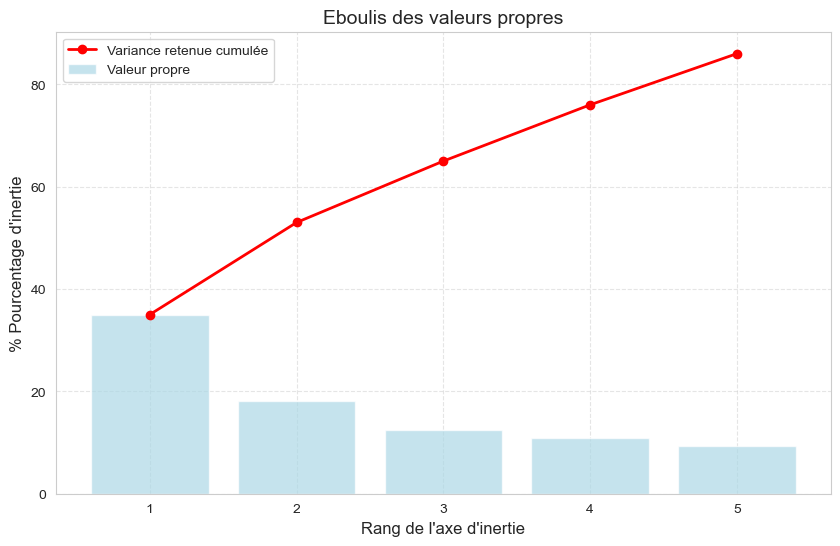

In [42]:
# coulers
bar_color = 'lightblue'
line_color = 'red'
x_list = range(1, n_components+1)
# Variance retenue cumulée
scree_cum = scree.cumsum().round()

# 
plt.figure(figsize=(10, 6))
plt.bar(x_list, scree, color=bar_color, alpha=0.7, label='Valeur propre')
plt.plot(x_list, scree_cum, color=line_color, marker='o', label='Variance retenue cumulée', linewidth=2)

# ajout d'une grille
plt.grid(True, linestyle='--', alpha=0.5)

# titres et étiquettes
plt.xlabel("Rang de l'axe d'inertie", fontsize=12)
plt.ylabel("% Pourcentage d'inertie", fontsize=12)
plt.title("Eboulis des valeurs propres", fontsize=14)
template='plotly_dark'
plt.legend()
plt.show()

In [43]:
pcs = pca.components_
pcs = pd.DataFrame(pcs)
pcs.columns = features
pcs.index = [f"F{i}" for i in x_list]
pcs.round(2)

YearBuilt  NumberofBuildings  NumberofFloors  PropertyGFATotal  \
F1       0.18               0.25            0.36              0.49   
F2      -0.21               0.51           -0.38             -0.23   
F3      -0.39              -0.12            0.18              0.10   
F4       0.55               0.08           -0.17             -0.07   
F5      -0.60              -0.09            0.26              0.06   

    PropertyGFAParking  SiteEnergyUse(kBtu)  TotalGHGEmissions  Latitude  \
F1                0.32                 0.49               0.43      0.02   
F2               -0.48                 0.26               0.43     -0.01   
F3               -0.02                 0.01              -0.01     -0.76   
F4                0.08                -0.08              -0.07      0.13   
F5               -0.01                -0.00              -0.03      0.63   

    Longitude  
F1       0.02  
F2       0.11  
F3       0.46  
F4       0.79  
F5       0.39

Text(0.5, 1.0, 'Décomposition des variables selon les composantes ACP')

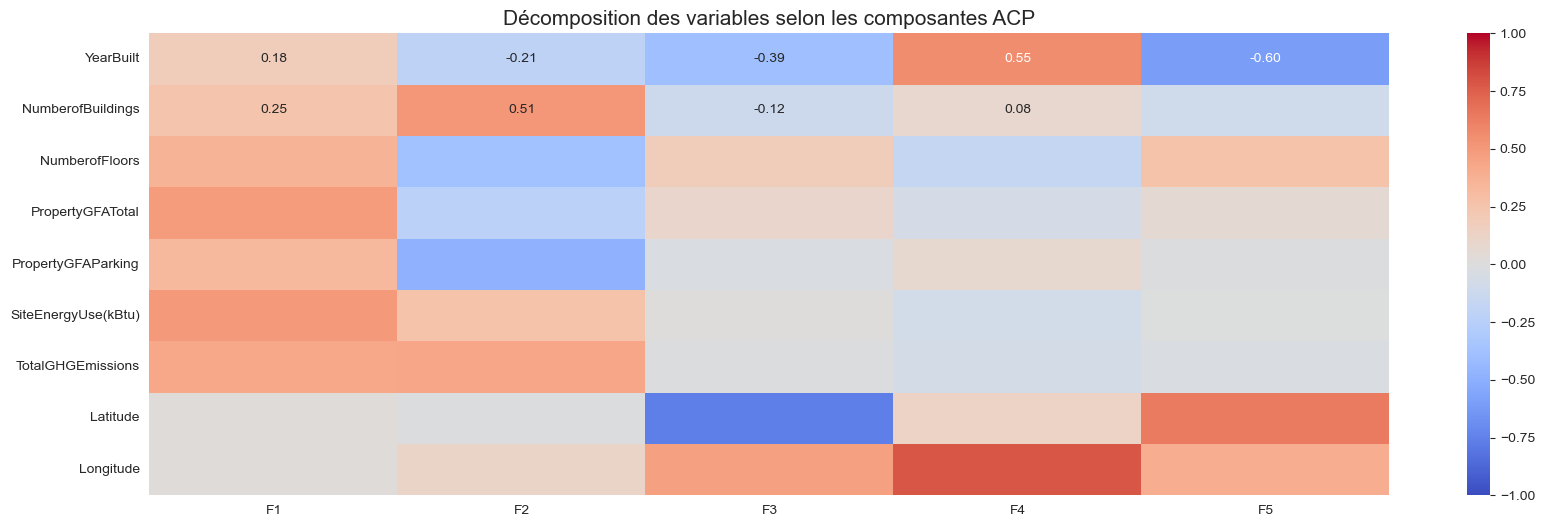

In [44]:
# Représentation graphique de la décomposition des variables selons les composantes
fig, ax = plt.subplots(figsize=(20, 6))
sns.heatmap(pcs.T, vmin=-1, vmax=1, annot=True, cmap="coolwarm", fmt="0.2f")
plt.title('Décomposition des variables selon les composantes ACP', fontsize=15)

In [45]:
# Utilisation de la focntion défnie dans le TP associé au cours Analyse exploratoire de données

def correlation_graph(pca, 
                      x_y, 
                      features) : 
    """Affiche le graphe des correlations

    Positional arguments : 
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y 
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante : 
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0, 
                pca.components_[0, i],  
                pca.components_[1, i],  
                head_width=0.07,
                head_length=0.07, 
                width=0.02, )

        # Les labels
        plt.text(pca.components_[0, i] + 0.05,
                pca.components_[1, i] + 0.05,
                features[i])
        
    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # J'ai copié collé le code sans le lire
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle 
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)



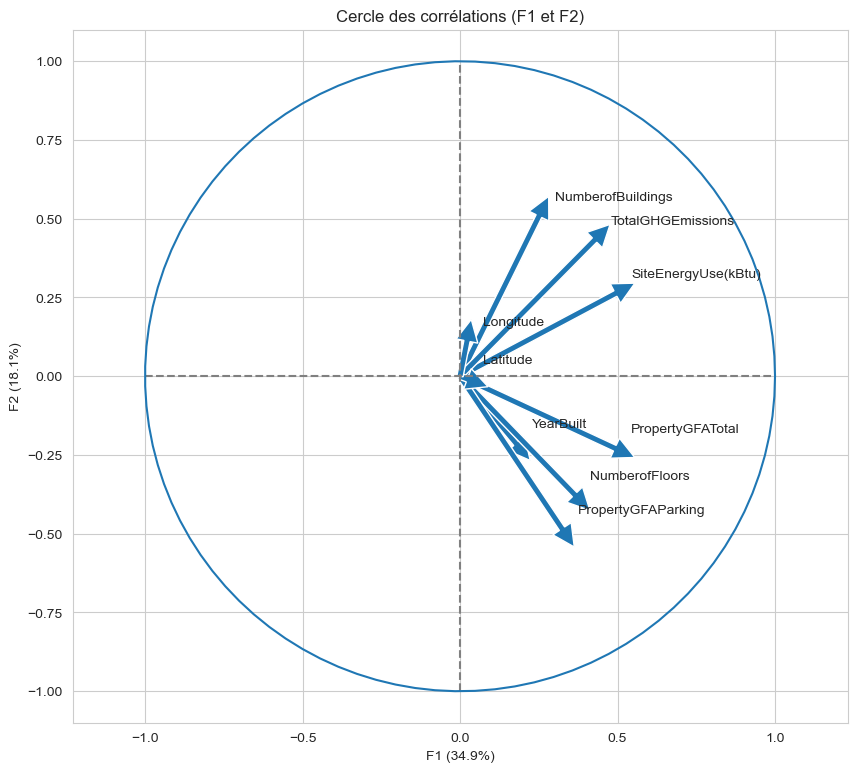

In [46]:
# Cercle des corrélations des composantes F1 et F2
x_y = (0,1)
correlation_graph(pca, x_y, features)

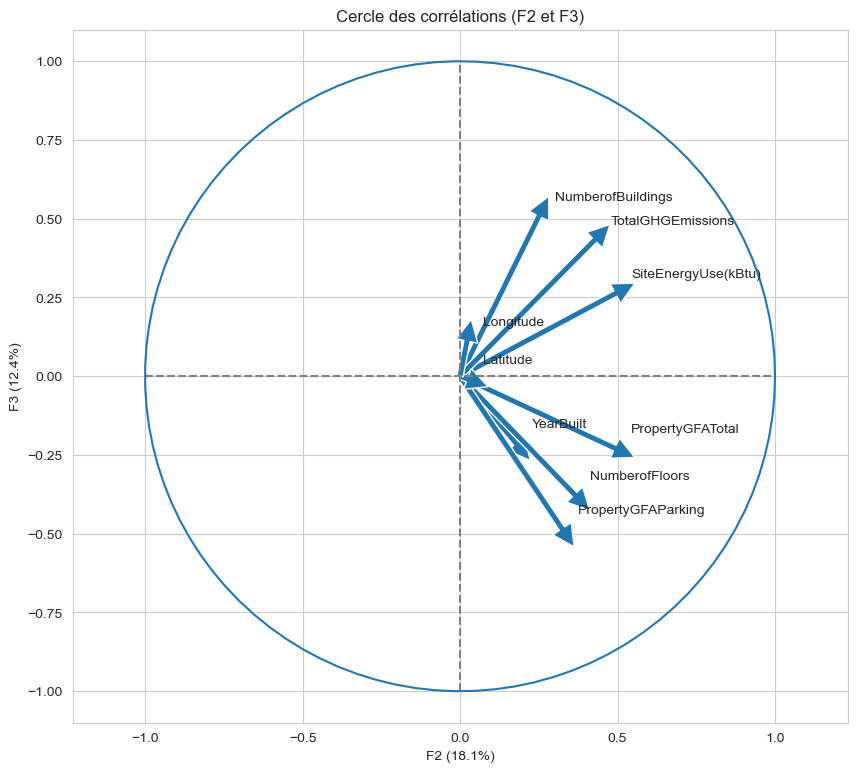

In [47]:
# Cercle des corrélations des composantes F2 et F3
x_y = (1,2)
correlation_graph(pca, (x_y), features)

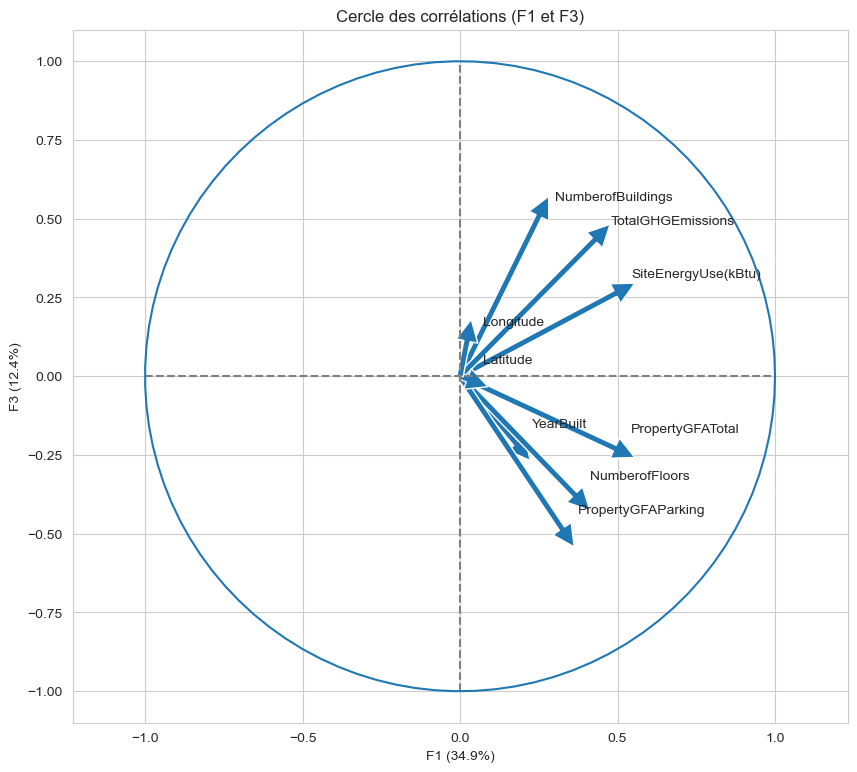

In [48]:
# Cercle des corrélations des composantes F1 et F3
x_y = (0,2)
correlation_graph(pca, (x_y), features)

# <a name="C4">4. Essais modélisation</a>

## 4.1 Essai sur données brutes


#### Split

In [49]:

# Features et target
features = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'YearBuilt', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking','Latitude','Longitude']
target = ['SiteEnergyUse(kBtu)'] 

X = ds_w_features[features]
y = ds_w_features[target]


# split du jeu de données en 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Dimensions de X_test:", X_train.shape)
print("Dimensions de X_test:", X_test.shape)





Dimensions de X_test: (1144, 10)
Dimensions de X_test: (286, 10)


#### Encodage

In [50]:


# selection des colonnes catégoriques à encoder
cat_columns = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood']

# instanciation de l'encodeur
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Fit de l'encodeur aux données
X_train_encoded = encoder.fit_transform(X_train[cat_columns])
X_test_encoded = encoder.transform(X_test[cat_columns])


X_train_encoded = np.concatenate([X_train_encoded, X_train.drop(cat_columns, axis=1)], axis=1)
X_test_encoded = np.concatenate([X_test_encoded, X_test.drop(cat_columns, axis=1)], axis=1)

print("Dimensions of X_train_encoded:", X_train_encoded.shape)
print("Dimensions of X_test_encoded:", X_test_encoded.shape)




Dimensions of X_train_encoded: (1144, 46)
Dimensions of X_test_encoded: (286, 46)


c:\Users\jules\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#### Essais avec dummy regressor ( création d'une baseline)

In [51]:


dummy_regressor = DummyRegressor(strategy="mean")

# Fit du dummy regressor
dummy_regressor.fit(X_train_encoded, y_train)

# Prédiction sur le jeu de test
dummy_predictions = dummy_regressor.predict(X_test_encoded)

# Calcul des métriques
r2_score_dummy = r2_score(y_test, dummy_predictions)
mse_dummy = mean_squared_error(y_test, dummy_predictions)
rmse_dummy = np.sqrt(mse_dummy)

print("R² score for Dummy Regressor:", r2_score_dummy)
print("MSE for Dummy Regressor:", mse_dummy)
print("RMSE for Dummy Regressor:", rmse_dummy)

R² score for Dummy Regressor: -0.005432812412158539
MSE for Dummy Regressor: 250132689076087.16
RMSE for Dummy Regressor: 15815583.741237221


In [52]:


# Instantiaton du modèle linéaire
linear_model = LinearRegression()

# Fit du modèle linéaire
linear_model.fit(X_train_encoded, y_train)
lin_reg_predictions = linear_model.predict(X_test_encoded)


# Calcul des métriques
r2_score_lin_reg = r2_score(y_test, lin_reg_predictions)
mse_lin_reg = mean_squared_error(y_test, lin_reg_predictions)
rmse_lin_reg = np.sqrt(mse_dummy)

print("R² score for Linear Regressor:", r2_score_lin_reg)
print("MSE for Linear Regressor:", mse_lin_reg)
print("RMSE for Linear Regressor:", rmse_lin_reg)







R² score for Linear Regressor: 0.7070406022014584
MSE for Linear Regressor: 72882763578856.73
RMSE for Linear Regressor: 15815583.741237221


In [53]:

# Définition de la grille de paramètres
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Conversion de y_train en array 1D
y_train_flat = y_train.values.ravel()

# Instantiatiation du modèle RandomForestRegressor
rf_model = RandomForestRegressor()

# Creation de la grille de recherche
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='r2')

# Grille de recherche sur les données d'entraînement
grid_search_rf.fit(X_train_encoded, y_train_flat) 

# affichage des meilleurs paramètres
print("Best Parameters for RandomForest:", grid_search_rf.best_params_)

# Affichage du meilleur score r²
print("Best Score (R²) for RandomForest:", grid_search_rf.best_score_)

# Instantiatiation du modèle RandomForestRegressor avec les meilleurs paramètres
rf_model_best = RandomForestRegressor(**grid_search_rf.best_params_)

# Entrainement du modèle
rf_model_best.fit(X_train_encoded, y_train)

# Calcul des prédictions sur le jeu de test
y_pred = rf_model_best.predict(X_test_encoded)

# Calcul des métriques
r2_score_rf = r2_score(y_test, y_pred)
mse_rf = mean_squared_error(y_test, y_pred)
rmse_rf = np.sqrt(mse_rf)

print("R² score for RandomForest:", r2_score_rf)
print("MSE for RandomForest:", mse_rf)
print("RMSE for RandomForest:", rmse_rf)







Best Parameters for RandomForest: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best Score (R²) for RandomForest: 0.572666863521689


C:\Users\jules\AppData\Local\Temp\ipykernel_21172\1217294562.py:31: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model_best.fit(X_train_encoded, y_train)


R² score for RandomForest: 0.6954161218850149
MSE for RandomForest: 75774714671728.06
RMSE for RandomForest: 8704867.297766697


Fonction pour afficher la courbe d'apprentissage

In [54]:



# Defininition de la fonction pour accficher les courbes d'apprentissage
def plot_learning_curve(estimator, title, X_train_encoded, y_train_flat, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X_train_encoded, y_train_flat, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [55]:


start_time = time.time()

# Definition des paramètres de la grille de recherche
param_grid_xgb = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 9, 11],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

# Instantiation du XGBoostRegressor
xgb_model = xgb.XGBRegressor()

# Definition du scorer en fonction du r²
scoring = make_scorer(r2_score)

# Creation de la grille de recherche
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, scoring=scoring)

# Grille de recherche sur les données d'entraînement
grid_search_xgb.fit(X_train_encoded, y_train)  

# affichage des meilleurs paramètres
print("Best Parameters for XGBoost:", grid_search_xgb.best_params_)

# Affichage du meilleur score r²
print("Best Score (R²) for XGBoost:", grid_search_xgb.best_score_)

# Instantiation du modèle XGBoostRegressor avec les meilleurs paramètres
xgb_model_best = xgb.XGBRegressor(**grid_search_xgb.best_params_)

# Entrainement du modèle
xgb_model_best.fit(X_train_encoded, y_train)

# Calcul des prédictions sur le jeu de test
y_pred = xgb_model_best.predict(X_test_encoded)

# Calcul des métriques
r2_score_xgb = r2_score(y_test, y_pred)
mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)

print("R² score for XGBoost:", r2_score_xgb)
print("MSE for XGBoost:", mse_xgb)
print("RMSE for XGBoost:", rmse_xgb)

Best Parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Best Score (R²) for XGBoost: 0.4384697435115248
R² score for XGBoost: 0.5992483087924145
MSE for XGBoost: 99699449765372.39
RMSE for XGBoost: 9984961.179963214


In [56]:

# Defininition de la fonction pour afficher les courbes d'apprentissage
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [57]:


start_time = time.time()

# Definition des paramètres pour ElasticNet
param_grid_en = {
    'alpha': [0.01, 0.1, 1.0],
    'l1_ratio': [0.1, 0.5, 0.9]
}

# Instantiatiation du modèle ElasticNet
en_model = ElasticNet()

# Définir le scorer en fonction du r²
scoring = make_scorer(r2_score)

# Création de la grille de recherche
grid_search_en = GridSearchCV(estimator=en_model, param_grid=param_grid_en, cv=5, scoring=scoring)

# Grille de recherche sur les données d'entraînement
grid_search_en.fit(X_train_encoded, y_train)  

# Affichage des meilleurs paramètres
print("Best Parameters for ElasticNet:", grid_search_en.best_params_)

# Affichage du meilleur score r²
print("Best Score (R²) for ElasticNet:", grid_search_en.best_score_)

# Instantiation du modèle ElasticNet avec les meilleurs paramètres
en_model_best = ElasticNet(**grid_search_en.best_params_)

# Entrainement du modèle
en_model_best.fit(X_train_encoded, y_train)

# Calcul des prédictions sur le jeu de test
y_pred_en = en_model_best.predict(X_test_encoded)

# Calcul des métriques
r2_score_en = r2_score(y_test, y_pred_en)
mse_en = mean_squared_error(y_test, y_pred_en)
rmse_en = np.sqrt(mse_en)

print("R² score for ElasticNet:", r2_score_en)
print("MSE for ElasticNet:", mse_en)
print("RMSE for ElasticNet:", rmse_en)

Best Parameters for ElasticNet: {'alpha': 0.01, 'l1_ratio': 0.5}
Best Score (R²) for ElasticNet: 0.565656288514751
R² score for ElasticNet: 0.5972964357489702
MSE for ElasticNet: 100185038903765.95
RMSE for ElasticNet: 10009247.669218998


In [58]:


# Definition de la fonction pour afficher les courbes d'apprentissage
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="k")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="k",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


In [59]:

start_time = time.time()


# Instantiatiation du modèle SVM
svm_model = SVR()


# Instantiation du modèle SVM avec les meilleurs paramètres
svm_model_best = SVR(C=1, gamma='scale', kernel='linear')

# Entrainement du modèle
svm_model_best.fit(X_train_encoded, y_train)

# Calcul des prédictions sur le jeu de test
y_pred_svm = svm_model_best.predict(X_test_encoded)

# Calcul des métriques
r2_score_svm = r2_score(y_test, y_pred_svm)
mse_svm = mean_squared_error(y_test, y_pred_svm)
rmse_svm = np.sqrt(mse_svm)

# Calculat du temps de calcul
svm_elapsed_time = time.time() - start_time
print("Computing time for :", svm_elapsed_time, "seconds")

print("R² score for SVM:", r2_score_svm)
print("MSE for SVM:", mse_svm)
print("RMSE for SVM:", rmse_svm)

c:\Users\jules\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Computing time for : 13.281965970993042 seconds
R² score for SVM: 0.39903983069531035
MSE for SVM: 149507536774303.94
RMSE for SVM: 12227327.458373884


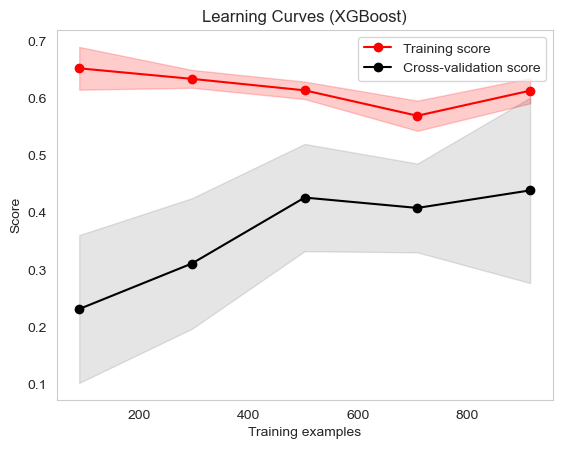

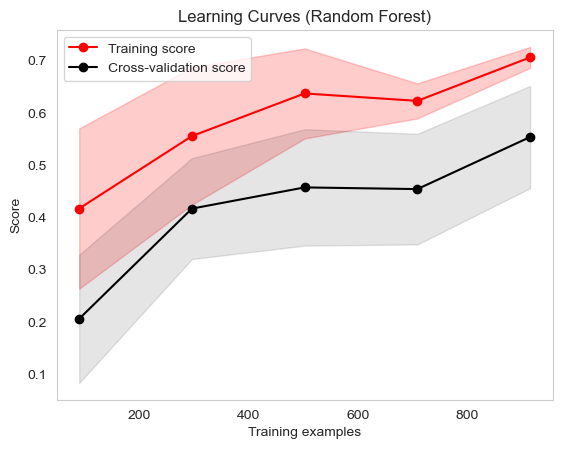

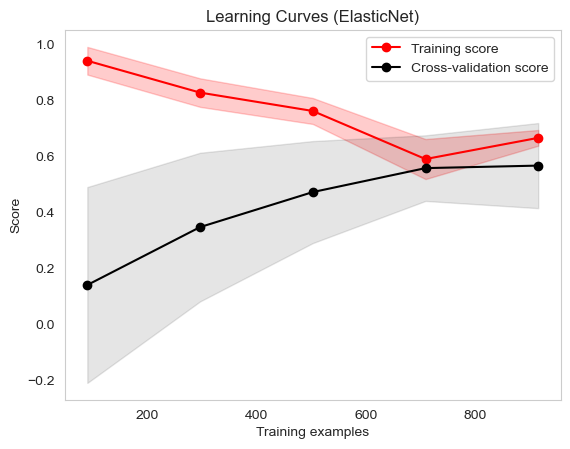

In [60]:


title = "Learning Curves (XGBoost)"
plot_learning_curve(grid_search_xgb.best_estimator_, title, X_train_encoded, y_train, cv=5, n_jobs=-1)
plt.show()


title = "Learning Curves (Random Forest)"
plot_learning_curve(grid_search_rf.best_estimator_, title, X_train_encoded, y_train_flat, cv=5, n_jobs=-1)
plt.show()


title = "Learning Curves (ElasticNet)"
plot_learning_curve(grid_search_en.best_estimator_, title, X_train_encoded, y_train, cv=5, n_jobs=-1)
plt.show()



#### Résultats sur données brutes par validation croisée

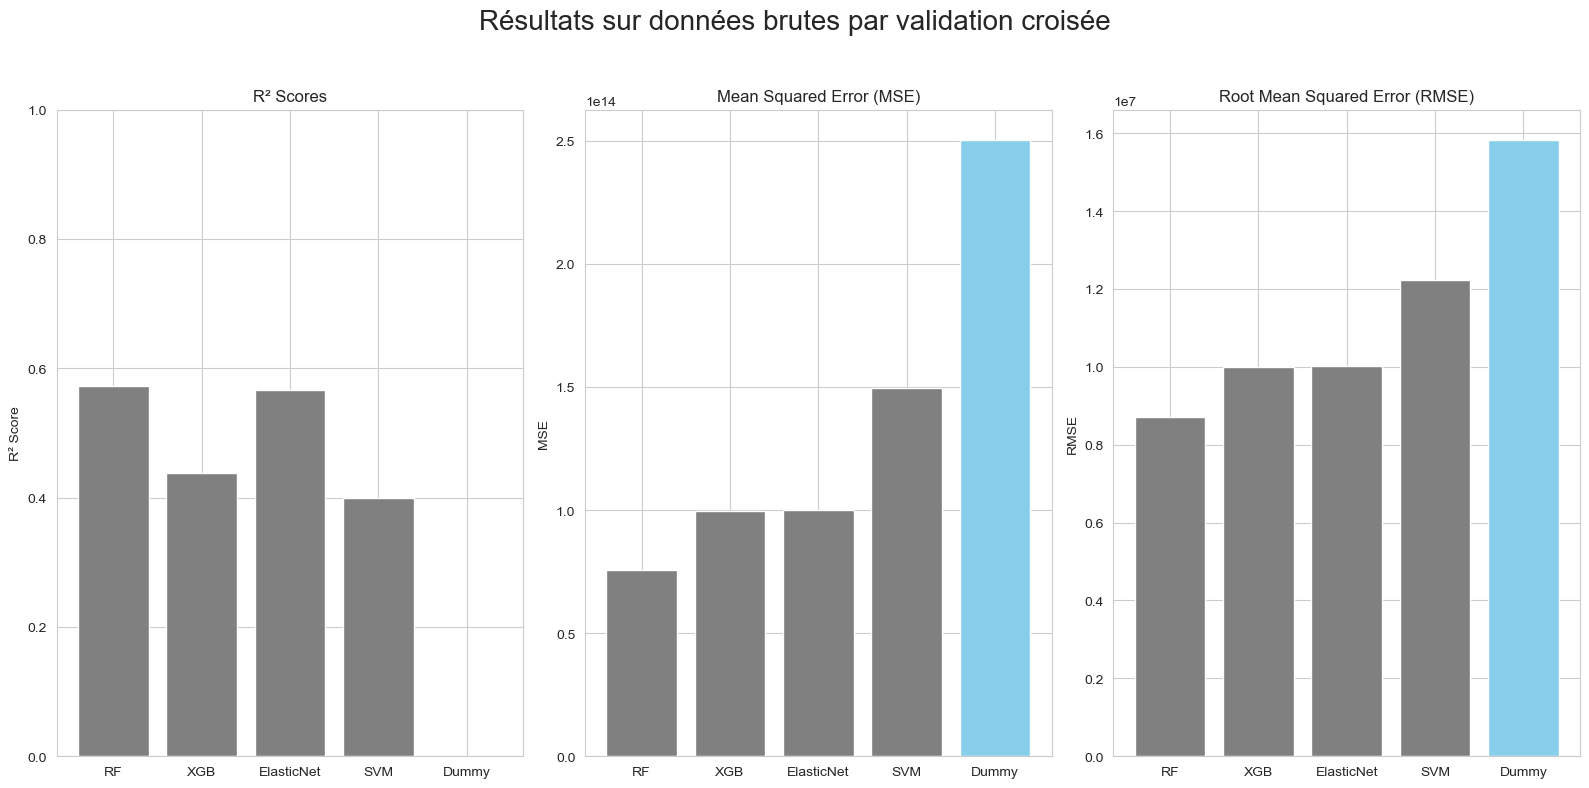

In [61]:


# Definition des noms des modèles et des scores
model_names = ['RF', 'XGB', 'ElasticNet', 'SVM', 'Dummy']
r2_scores = [grid_search_rf.best_score_, grid_search_xgb.best_score_, grid_search_en.best_score_, r2_score_svm, r2_score_dummy]
mse_scores = [mse_rf, mse_xgb, mse_en, mse_svm, mse_dummy]
rmse_scores = [rmse_rf, rmse_xgb, rmse_en, rmse_svm, rmse_dummy]


colors = ['grey', 'grey', 'grey', 'grey','skyblue']

plt.figure(figsize=(16, 8))

# R² scores
plt.subplot(1, 3, 1)
plt.bar(model_names, r2_scores, color=colors)
plt.title('R² Scores')
plt.ylabel('R² Score')
plt.ylim(0, 1)

# MSE scores
plt.subplot(1, 3, 2)
plt.bar(model_names, mse_scores, color=colors)
plt.title('Mean Squared Error (MSE)')
plt.ylabel('MSE')

# RMSE scores
plt.subplot(1, 3, 3)
plt.bar(model_names, rmse_scores, color=colors)
plt.title('Root Mean Squared Error (RMSE)')
plt.ylabel('RMSE')

plt.suptitle('Résultats sur données brutes par validation croisée', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



## 4.2 Transformation des variables numériques


Cap and flooring sur les variables cibles

c:\Users\jules\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jules\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


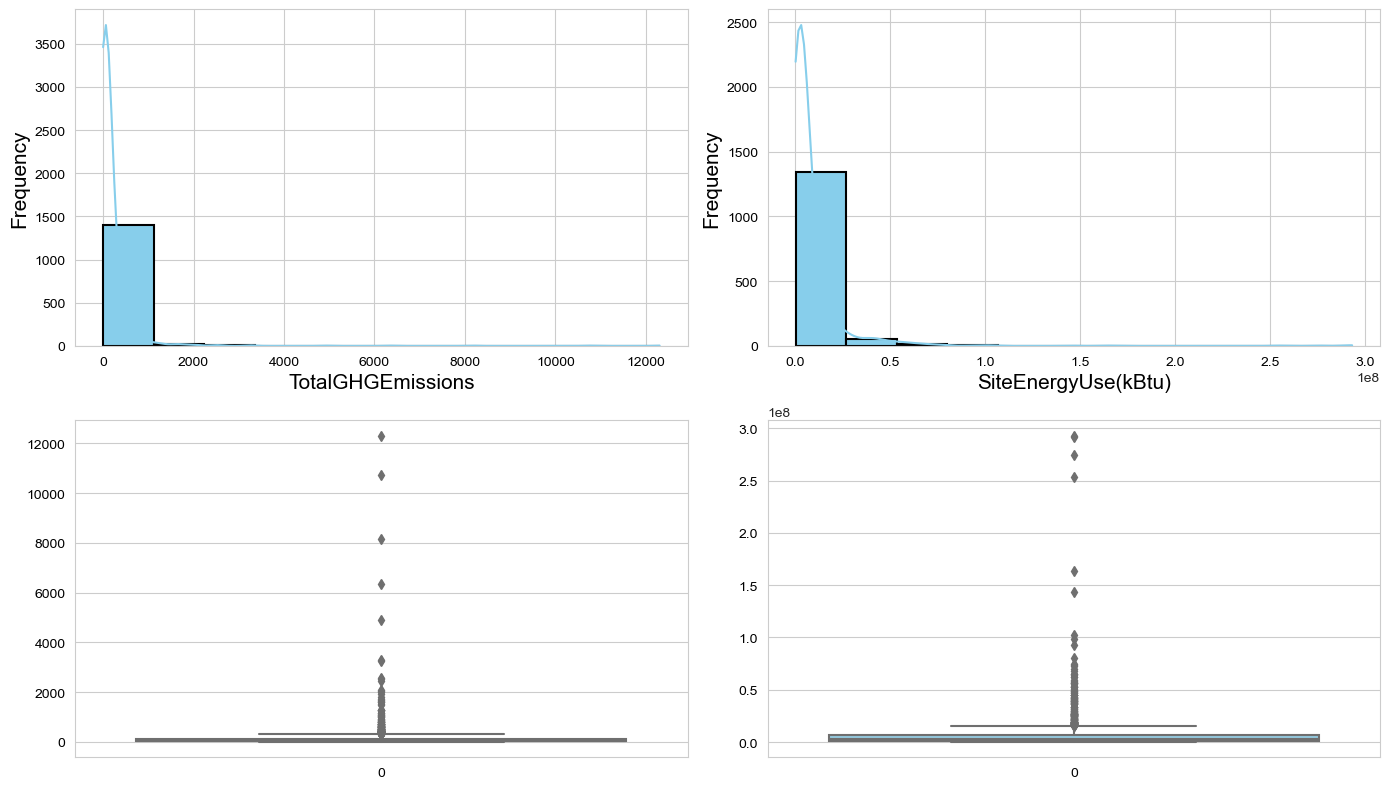

In [62]:
fig = plt.figure(1, figsize=(14, 8))
for i, label in enumerate(["TotalGHGEmissions", "SiteEnergyUse(kBtu)"]):
    plt.subplot(2, 2, i + 1)
    sns.histplot(ds_w_features[label], bins=int(1 + np.log2(len(ds_w_features))), color='skyblue', kde=True, fill=True, edgecolor='black', linewidth=1.5, alpha=1)  # Set the fill color of the histogram bars and make them opaque
    plt.xlabel(label, color='black', fontsize=15)  # Set x-label color to black
    plt.ylabel('Frequency', color='black', fontsize=15)  # Set y-label color to black
    plt.xticks(color='black')  # Set color of x-axis labels to black
    plt.yticks(color='black')  # Set color of y-axis labels to black
    plt.subplot(2, 2, i + 3)
    sns.boxplot(ds_w_features[label], orient="v", color='skyblue')
    # Set font color to black
    plt.xticks(color='black')
    plt.yticks(color='black')

plt.tight_layout()

# Save the plot with a transparent background
plt.savefig('transparent_plot_2.png', transparent=True)

plt.show()


In [63]:
Q1 = round(np.percentile(ds_w_features["SiteEnergyUse(kBtu)"].apply(lambda x : np.log(1 + x)), 25))
Q3 = round(np.percentile(ds_w_features["SiteEnergyUse(kBtu)"].apply(lambda x : np.log(1 + x)), 75))

born_sup_energy = Q3 + 1.5*(Q3-Q1)
born_inf_energy = Q1 - 1.5*(Q3-Q1)

In [64]:
Q1 = round(np.percentile(ds_w_features["TotalGHGEmissions"].apply(lambda x : np.log(1 + x)), 25))
Q3 = round(np.percentile(ds_w_features["TotalGHGEmissions"].apply(lambda x : np.log(1 + x)), 75))

born_sup_co2 = Q3 + 1.5*(Q3-Q1) 
born_inf_co2 = Q1 - 1.5*(Q3-Q1)

In [65]:
ds_w_features = ds_w_features[(ds_w_features["SiteEnergyUse(kBtu)"].apply(lambda x : np.log(1 + x))<born_sup_energy) & (ds_w_features["SiteEnergyUse(kBtu)"].apply(lambda x : np.log(1 + x))>born_inf_energy)]
ds_w_features = ds_w_features[(ds_w_features["TotalGHGEmissions"].apply(lambda x : np.log(1 + x))<born_sup_co2) & (ds_w_features["TotalGHGEmissions"].apply(lambda x : np.log(1 + x))>born_inf_co2)]

C:\Users\jules\AppData\Local\Temp\ipykernel_21172\4207518839.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ds_w_features[label].apply(lambda x : np.log(1 + x)), bins=int(1 + np.log2(len(ds_w_features))))
c:\Users\jules\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\jules\AppData\Local\Temp\ipykernel_21172\4207518839.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt 

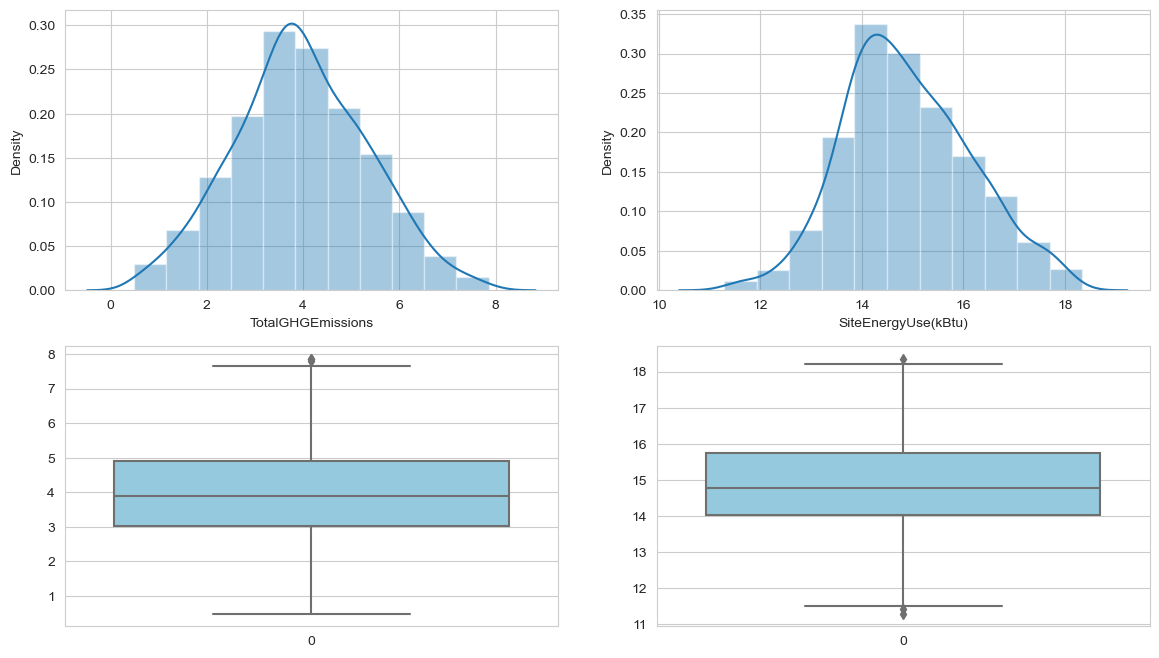

In [66]:

fig = plt.figure(1, figsize=(14, 8))
for i,label in enumerate(["TotalGHGEmissions", "SiteEnergyUse(kBtu)"]) :
    plt.subplot(2,2,i+1)
    sns.distplot(ds_w_features[label].apply(lambda x : np.log(1 + x)), bins=int(1 + np.log2(len(ds_w_features))))
    plt.subplot(2,2,i+3)
    sns.boxplot(ds_w_features[label].apply(lambda x : np.log(1 + x)), orient="v", color='skyblue')
plt.show()

Transformation logarithmique des données

In [67]:
# Mise à l'échelle log de la consommation d'énergie dans une nouvelle variable 'log_SiteEnergyUse(kBtu)'
ds_w_features.loc[:, 'log_SiteEnergyUse(kBtu)'] = np.log2(ds_w_features['SiteEnergyUse(kBtu)'] + 1)


c:\Users\jules\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jules\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


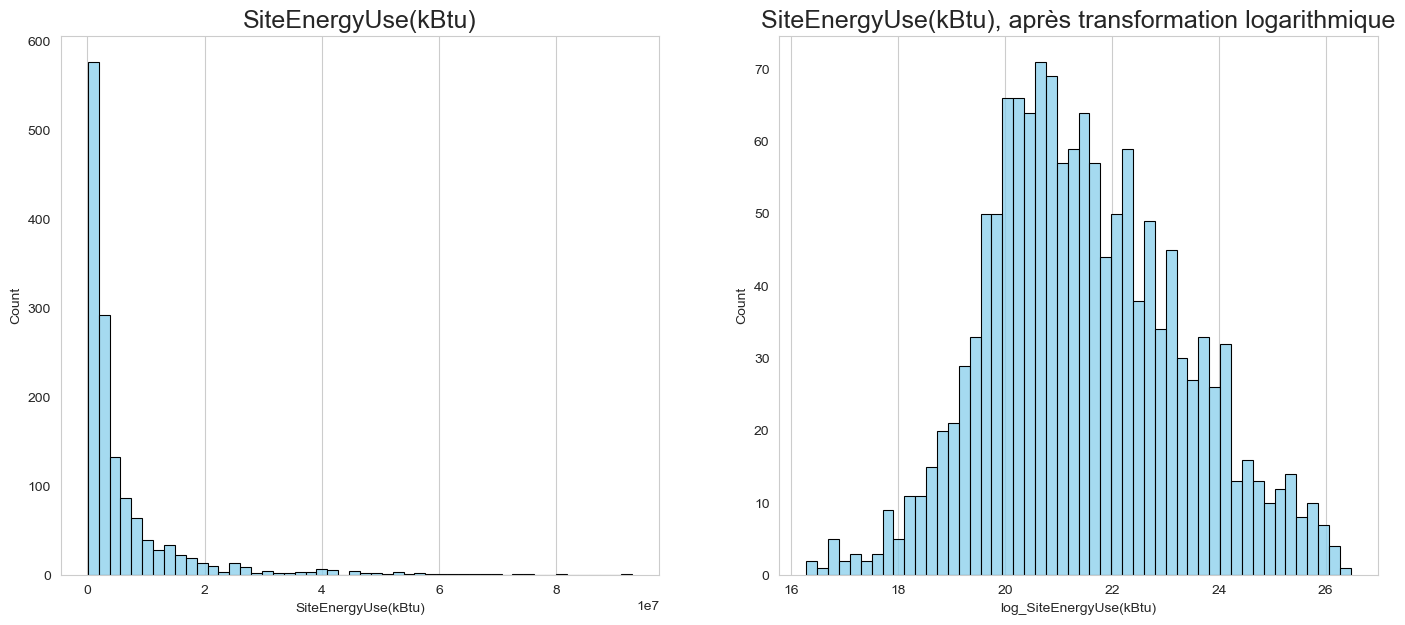

In [68]:
# Représentation graphique de la distribution de la consommation, avant et après transformation logarithmique

fig=plt.figure(figsize = (17,7))

ax = fig.add_subplot(1,2, 1)
sns.histplot(x=ds_w_features['SiteEnergyUse(kBtu)'],bins=50, color='skyblue', edgecolor='black')
ax.set_title('SiteEnergyUse(kBtu)', fontsize=18)
plt.grid(axis='y')

ax = fig.add_subplot(1,2, 2)
sns.histplot(x=ds_w_features['log_SiteEnergyUse(kBtu)'],bins=50, color='skyblue',edgecolor='black')
ax.set_title('SiteEnergyUse(kBtu), après transformation logarithmique', fontsize=18)
plt.grid(axis='y')

In [69]:
# Mise à l'échelle log de l'emission de CO2 'TotalGHGEmissions' dans une nouvelle variable log_TotalGHGEmissions
ds_w_features.loc[:,'log_TotalGHGEmissions']=np.log2(ds_w_features['TotalGHGEmissions']+1)

c:\Users\jules\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\jules\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


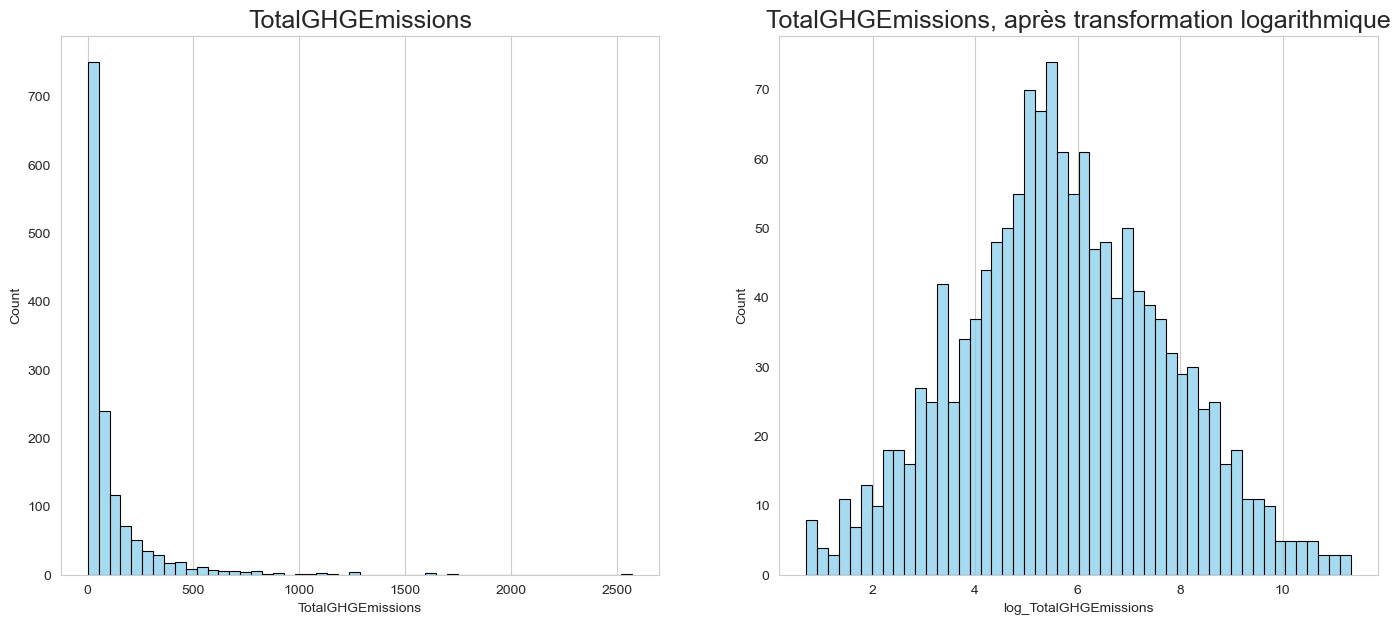

In [70]:
# Représentation graphique de la distribution des émissions, avant et après transformation logarithmique

fig=plt.figure(figsize = (17,7))

ax = fig.add_subplot(1,2, 1)
sns.histplot(x=ds_w_features['TotalGHGEmissions'],bins=50, color='skyblue',edgecolor='black' )

ax.set_title('TotalGHGEmissions', fontsize=18)
plt.grid(axis='y')
ax = fig.add_subplot(1,2, 2)
sns.histplot(x=ds_w_features['log_TotalGHGEmissions'],bins=50, color='skyblue',edgecolor='black')

ax.set_title('TotalGHGEmissions, après transformation logarithmique', fontsize=18)
plt.grid(axis='y')

In [71]:
# Mise à l'échelle log Number of Buldings
ds_w_features.loc[:,'log_NumberofBuildings']=np.log2(ds_w_features['NumberofBuildings']+1)

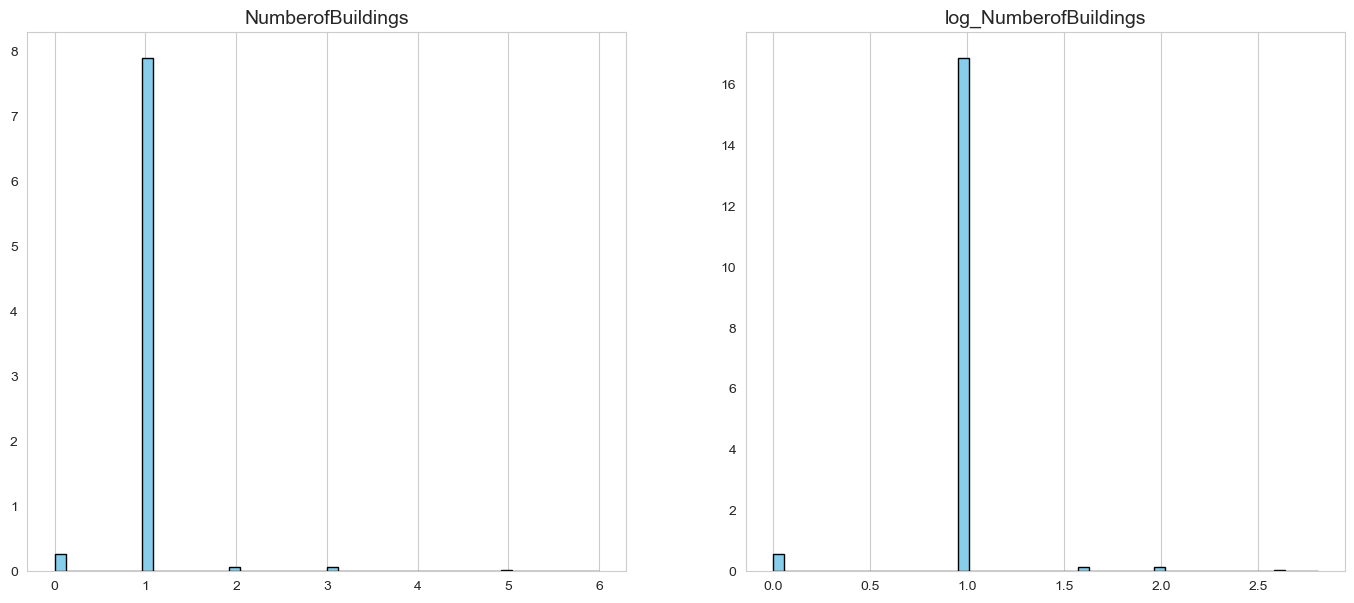

In [72]:
# Représentation graphique de la distribution du nombre d'étages, avant et après transformation logarithmique

fig=plt.figure(figsize = (17,7))

ax = fig.add_subplot(1,2, 1)
h = ax.hist(ds_w_features['NumberofBuildings'], bins=50, color='skyblue', density=True, edgecolor='black')
ax.set_title('NumberofBuildings', fontsize=14)
plt.grid(axis='y')
ax = fig.add_subplot(1,2, 2)
h = ax.hist(ds_w_features['log_NumberofBuildings'], bins=50, color='skyblue', density=True,edgecolor='black')
ax.set_title('log_NumberofBuildings', fontsize=14)
plt.grid(axis='y')

In [73]:
ds_w_features.loc[:,'log_NumberofFloors']=np.log2(ds_w_features['NumberofFloors']+1)

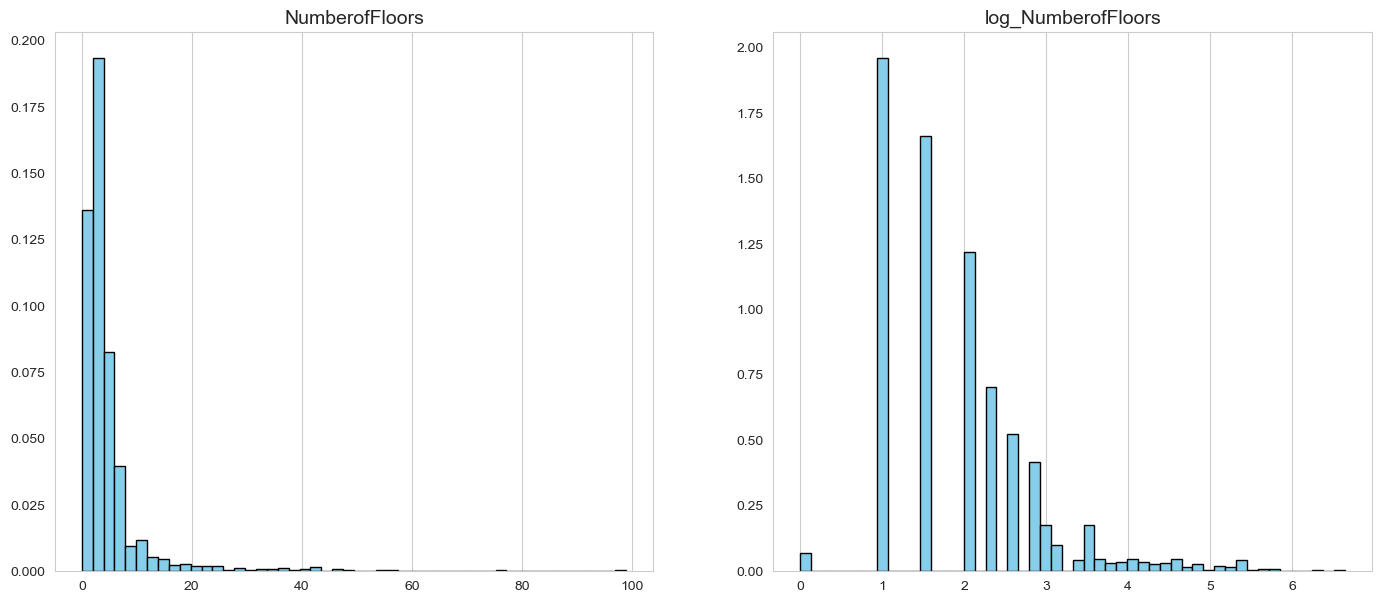

In [74]:
# Représentation graphique de la distribution du nombre d'étages, avant et après transformation logarithmique
fig=plt.figure(figsize = (17,7))

ax = fig.add_subplot(1,2, 1)
h = ax.hist(ds_w_features['NumberofFloors'], bins=50, color='skyblue', density=True, edgecolor='black')
ax.set_title('NumberofFloors', fontsize=14)
plt.grid(axis='y')
ax = fig.add_subplot(1,2, 2)
h = ax.hist(ds_w_features['log_NumberofFloors'], bins=50, color='skyblue', density=True,edgecolor='black')
ax.set_title('log_NumberofFloors', fontsize=14)
plt.grid(axis='y')

In [75]:
# Mise à l'échelle log de la Surface totale
ds_w_features.loc[:,'log_PropertyGFATotal']=np.log2(ds_w_features['PropertyGFATotal']+1)

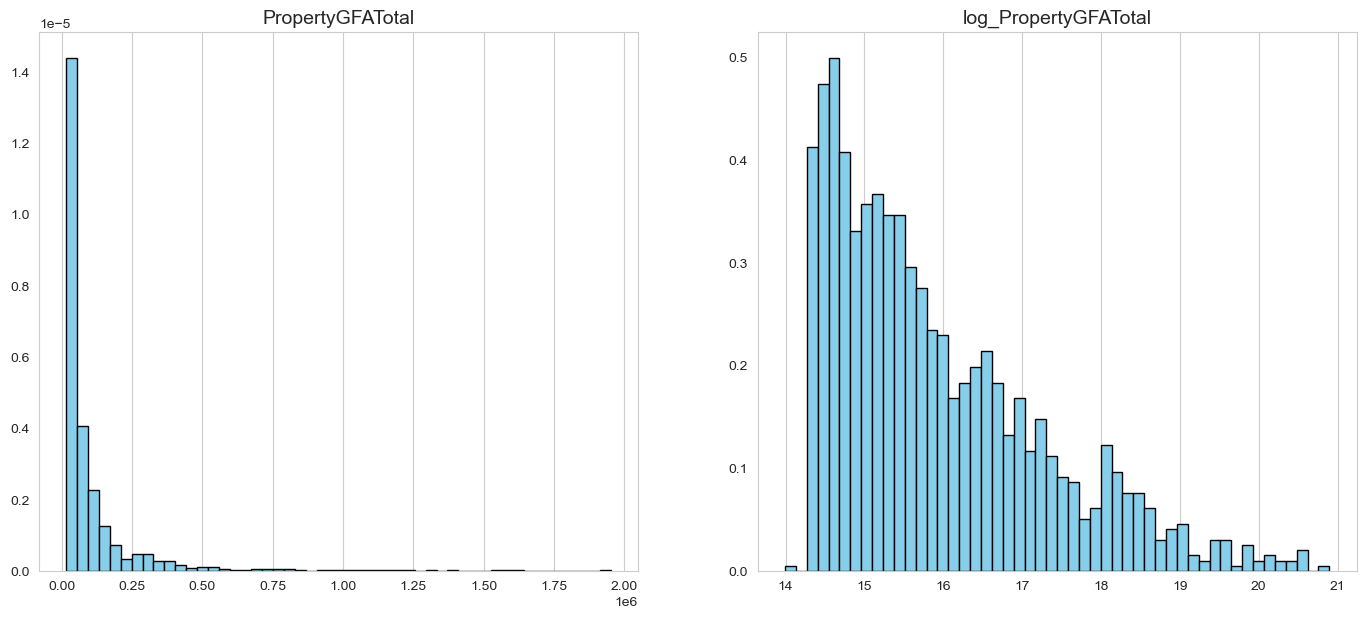

In [76]:
# Représentation graphique de la distribution de la surface totale, avant et après transformation logarithmique

fig=plt.figure(figsize = (17,7))

ax = fig.add_subplot(1,2, 1)
h = ax.hist(ds_w_features['PropertyGFATotal'], bins=50, color='skyblue', density=True, edgecolor='black')
ax.set_title('PropertyGFATotal', fontsize=14)
plt.grid(axis='y')
ax = fig.add_subplot(1,2, 2)
h = ax.hist(ds_w_features['log_PropertyGFATotal'], bins=50, color='skyblue', density=True,edgecolor='black')
ax.set_title('log_PropertyGFATotal', fontsize=14)
plt.grid(axis='y')

In [77]:
# Mise à l'échelle log surface de parking
ds_w_features.loc[:,'log_PropertyGFAParking']=np.log2(ds_w_features['PropertyGFAParking']+1)

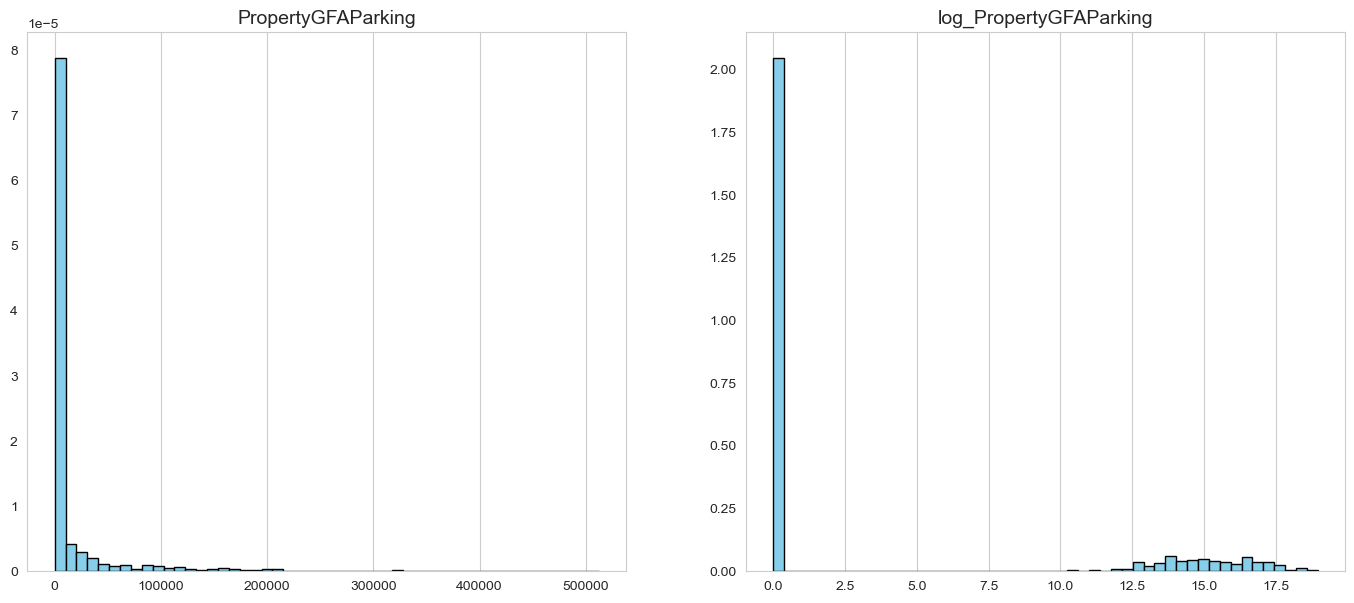

In [78]:
# Représentation graphique de la distribution de la surface de parking, avant et après transformation logarithmique

fig=plt.figure(figsize = (17,7))

ax = fig.add_subplot(1,2, 1)
h = ax.hist(ds_w_features['PropertyGFAParking'], bins=50, color='skyblue', density=True, edgecolor='black')
ax.set_title('PropertyGFAParking', fontsize=14)
plt.grid(axis='y')
ax = fig.add_subplot(1,2, 2)
h = ax.hist(ds_w_features['log_PropertyGFAParking'], bins=50, color='skyblue', density=True,edgecolor='black')
ax.set_title('log_PropertyGFAParking', fontsize=14)
plt.grid(axis='y')

Regroupement des dates d'habitation en décennies

In [79]:
# Création des catégories et des labels associés
years_bins=[1900, 1910, 1920, 1930, 1940,1950,1960,1970,1980,1990,2000,2010,2015]
years_labels=["1900's", "1910's", "1920's", "1930's","1940's", "1950's", "1960's", "1970's","1980's", "1990's", "2000's", "2010's"]

# Création d'une nouvelle variable 'decade' en utilisant .loc pour éviter la warning
ds_w_features.loc[:, 'decade'] = pd.cut(x=ds_w_features['YearBuilt'], bins=years_bins, labels=years_labels, include_lowest=True)

# Vérification du nombre de valeurs dans chaque catégorie
print("\nNb de bâtiments par décennies: ")
print(ds_w_features['decade'].value_counts())
print("\nNb total de label créé : "+ str(ds_w_features['decade'].value_counts().sum()))



Nb de bâtiments par décennies: 
decade
1960's    195
1950's    154
1920's    149
1980's    143
1970's    142
1900's    141
2000's    139
1990's    134
1910's     89
1940's     62
2010's     40
1930's     32
Name: count, dtype: int64

Nb total de label créé : 1420


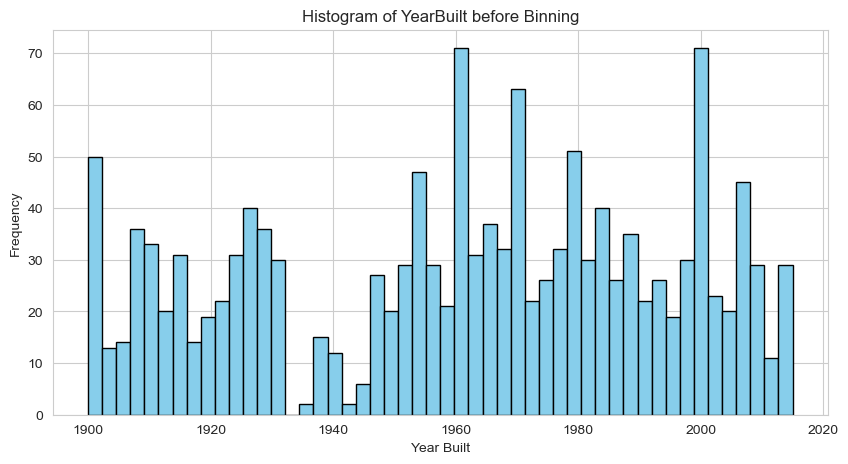

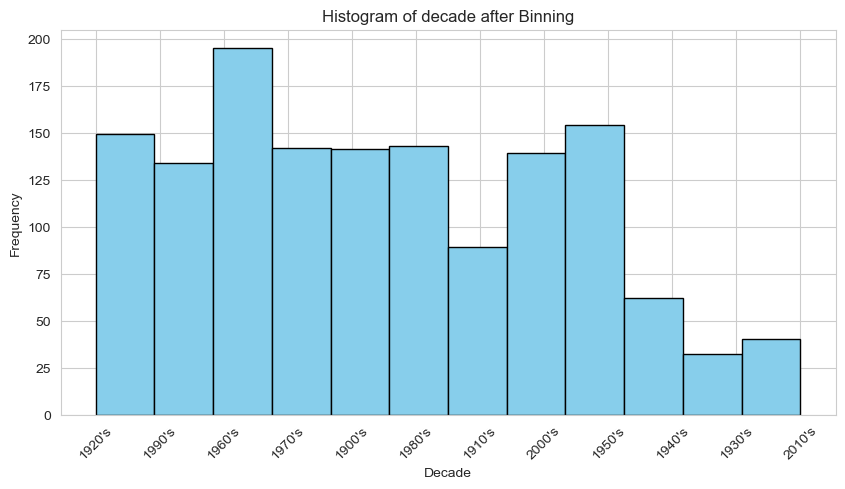

In [80]:
# Histogramme avant binning
plt.figure(figsize=(10, 5))
plt.hist(ds_w_features['YearBuilt'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of YearBuilt before Binning')
plt.xlabel('Year Built')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Histogramme après binning
plt.figure(figsize=(10, 5))
plt.hist(ds_w_features['decade'], bins=len(years_labels), color='skyblue', edgecolor='black')
plt.title('Histogram of decade after Binning')
plt.xlabel('Decade')
plt.ylabel('Frequency')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


## 4.3 Essais sur données transformées


Split

In [81]:


#features et targets
features = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'decade', 'log_NumberofBuildings', 'log_NumberofFloors', 'log_PropertyGFATotal', 'log_PropertyGFAParking','Latitude','Longitude']
target = ['log_SiteEnergyUse(kBtu)'] 

X = ds_w_features[features]
y = ds_w_features[target]

# split en 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Dimensions de X_train:", X_train.shape)
print("Dimensions de X_test:", X_test.shape)

Dimensions de X_train: (1136, 10)
Dimensions de X_test: (284, 10)


In [82]:


# Selection des colonnes catégoriques à encoder     
cat_columns = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood','decade']

# Instanciation de l'encodeur
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Fitting de l'encodeur aux données
X_train_encoded_cat = encoder.fit_transform(X_train[cat_columns])
X_test_encoded_cat = encoder.transform(X_test[cat_columns])

# obtenir les noms des colonnes encodées
encoded_feature_names = encoder.get_feature_names_out(input_features=cat_columns)

# Concaténation des données encodées avec les données numériques
X_train_encoded = np.concatenate([X_train_encoded_cat, X_train.drop(cat_columns, axis=1)], axis=1)

X_test_encoded = np.concatenate([X_test_encoded_cat, X_test.drop(cat_columns, axis=1)], axis=1)

# combinaison des noms des colonnes encodées avec les noms des colonnes numériques
all_feature_names = np.concatenate([encoded_feature_names, X_train.drop(cat_columns, axis=1).columns])

# form des datasets
print("Dimensions of X_train_encoded:", X_train_encoded.shape)
print("Dimensions of X_test_encoded:", X_test_encoded.shape)


Dimensions of X_train_encoded: (1136, 57)
Dimensions of X_test_encoded: (284, 57)


c:\Users\jules\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


#### Essais sur données transformées

In [83]:

dummy_regressor = DummyRegressor(strategy="mean")

# Fit du dummy regressor
dummy_regressor.fit(X_train_encoded, y_train)

# Prédiction sur le jeu de test
dummy_predictions = dummy_regressor.predict(X_test_encoded)

# Calcul des métriques
r2_score_dummy = r2_score(y_test, dummy_predictions)
mse_dummy = mean_squared_error(y_test, dummy_predictions)
rmse_dummy = np.sqrt(mse_dummy)

print("R² score for Dummy Regressor:", r2_score_dummy)
print("MSE for Dummy Regressor:", mse_dummy)
print("RMSE for Dummy Regressor:", rmse_dummy)
print("RMSE for Dummy Regressor:", rmse_dummy)



R² score for Dummy Regressor: -0.004031989106835443
MSE for Dummy Regressor: 3.240450074224235
RMSE for Dummy Regressor: 1.8001250162764348
RMSE for Dummy Regressor: 1.8001250162764348


In [84]:

# Instantiaton du modèle linéaire
linear_model = LinearRegression()

# Fit du modèle linéaire
linear_model.fit(X_train_encoded, y_train)
lin_reg_predictions = linear_model.predict(X_test_encoded)


# Calcul des métriques
r2_score_lin_reg = r2_score(y_test, lin_reg_predictions)
mse_lin_reg = mean_squared_error(y_test, lin_reg_predictions)
rmse_lin_reg = np.sqrt(mse_dummy)

print("R² score for Dummy Regressor:", r2_score_lin_reg)
print("MSE for Dummy Regressor:", mse_lin_reg)
print("RMSE for Dummy Regressor:", rmse_lin_reg)



R² score for Dummy Regressor: 0.7130075141463963
MSE for Dummy Regressor: 0.9262501914041622
RMSE for Dummy Regressor: 1.8001250162764348


In [85]:


# Définition de la grille de paramètres
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}



# Instantiatiation du modèle RandomForestRegressor
rf_model = RandomForestRegressor()

# Conversion de y_train en array 1D
y_train_flat = y_train.values.ravel()

# Creation de la grille de recherche
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='r2')

# Grille de recherche sur les données d'entrainement
grid_search_rf.fit(X_train_encoded, y_train_flat) 

# affichage des meilleurs paramètres
print("Best Parameters for RandomForest:", grid_search_rf.best_params_)

# Affichage du meilleur score r²
print("Best Score (R²) for RandomForest:", grid_search_rf.best_score_)

# Instantiatiation du modèle RandomForestRegressor avec les meilleurs paramètres
rf_model_best = RandomForestRegressor(**grid_search_rf.best_params_)

# Entrainement du modèle
rf_model_best.fit(X_train_encoded, y_train)

# Calcul des prédictions sur le jeu de test
y_pred = rf_model_best.predict(X_test_encoded)

# Calcul des métriques
r2_score_rf = r2_score(y_test, y_pred)
mse_rf = mean_squared_error(y_test, y_pred)
rmse_rf = np.sqrt(mse_rf)

print("R² score for RandomForest:", r2_score_rf)
print("MSE for RandomForest:", mse_rf)
print("RMSE for RandomForest:", rmse_rf)


Best Parameters for RandomForest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Best Score (R²) for RandomForest: 0.6891405504057351


C:\Users\jules\AppData\Local\Temp\ipykernel_21172\2476696053.py:33: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model_best.fit(X_train_encoded, y_train)


R² score for RandomForest: 0.6816591123276836
MSE for RandomForest: 1.0274251859286139
RMSE for RandomForest: 1.013619842903943


In [86]:

# Defininition de la fonction pour accficher les courbes d'apprentissage
def plot_learning_curve(estimator, title, X_train_encoded, y_train_flat, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X_train_encoded, y_train_flat, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


In [87]:

start_time = time.time()

# Definition des paramètres de la grille de recherche
param_grid_xgb = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 9, 11],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

# Instantiation du XGBoostRegressor
xgb_model = xgb.XGBRegressor()

# Definition du scorer en fonction du r²
scoring = make_scorer(r2_score)

# Creation de la grille de recherche
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, scoring=scoring)

# Grille de recherche sur les données d'entraînement
grid_search_xgb.fit(X_train_encoded, y_train) 

# affichage des meilleurs paramètres
print("Best Parameters for XGBoost:", grid_search_xgb.best_params_)

# Affichage du meilleur score r²
print("Best Score (R²) for XGBoost:", grid_search_xgb.best_score_)

# Instantiation du modèle XGBoostRegressor avec les meilleurs paramètres
xgb_model_best = xgb.XGBRegressor(**grid_search_xgb.best_params_)

# Entrainement du modèle
xgb_model_best.fit(X_train_encoded, y_train)

# Calcul des prédictions sur le jeu de test
y_pred = xgb_model_best.predict(X_test_encoded)

# Calcul des métriques
r2_score_xgb = r2_score(y_test, y_pred)
mse_xgb = mean_squared_error(y_test, y_pred)
rmse_xgb = np.sqrt(mse_xgb)

print("R² score for XGBoost:", r2_score_xgb)
print("MSE for XGBoost:", mse_xgb)
print("RMSE for XGBoost:", rmse_xgb)





Best Parameters for XGBoost: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
Best Score (R²) for XGBoost: 0.6995869089704343
R² score for XGBoost: 0.6909334963749014
MSE for XGBoost: 0.9974926949320613
RMSE for XGBoost: 0.998745560656998


In [88]:

# Defininition de la fonction pour accficher les courbes d'apprentissage
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt




In [89]:


start_time = time.time()

# Definition des paramètres pour ElasticNet
param_grid_en = {
    'alpha': [0.01, 0.1, 1.0],
    'l1_ratio': [0.1, 0.5, 0.9]
}

# Instantiatiation du modèle ElasticNet
en_model = ElasticNet()

# Définir le scorer en fonction du r²
scoring = make_scorer(r2_score)

# Création de la grille de recherche
grid_search_en = GridSearchCV(estimator=en_model, param_grid=param_grid_en, cv=5, scoring=scoring)

# Grille de recherche sur les données d'entraînement
grid_search_en.fit(X_train_encoded, y_train)  

# Affichage des meilleurs paramètres
print("Best Parameters for ElasticNet:", grid_search_en.best_params_)

# Affichage du meilleur score r²
print("Best Score (R²) for ElasticNet:", grid_search_en.best_score_)

# Instantiation du modèle ElasticNet avec les meilleurs paramètres
en_model_best = ElasticNet(**grid_search_en.best_params_)

# Entrainement du modèle
en_model_best.fit(X_train_encoded, y_train)

# Calcul des prédictions sur le jeu de test
y_pred_en = en_model_best.predict(X_test_encoded)

# Calcul des métriques
r2_score_en = r2_score(y_test, y_pred_en)
mse_en = mean_squared_error(y_test, y_pred_en)
rmse_en = np.sqrt(mse_en)

print("R² score for ElasticNet:", r2_score_en)
print("MSE for ElasticNet:", mse_en)
print("RMSE for ElasticNet:", rmse_en)






Best Parameters for ElasticNet: {'alpha': 0.01, 'l1_ratio': 0.5}
Best Score (R²) for ElasticNet: 0.7033009648967237
R² score for ElasticNet: 0.696753528796852
MSE for ElasticNet: 0.9787089064688328
RMSE for ElasticNet: 0.9892971780354136


In [90]:


# Definition de la fonction pour afficher les courbes d'apprentissage
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="grey")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="grey",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt




In [91]:

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

start_time = time.time()

# Instantiatiation des paramètres pour le modèle SVM
param_grid_svm = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
}

# Instantiatiation du modèle
svm_model = SVR()

# Définir le scorer en fonction du r²
scoring = make_scorer(r2_score)

# Création de la grille de recherche
grid_search_svm = GridSearchCV(estimator=svm_model, param_grid=param_grid_svm, cv=5, scoring=scoring)

# Grille de recherche sur les données d'entraînement
grid_search_svm.fit(X_train_encoded, y_train) 

# Affichage des meilleurs paramètres
print("Best Parameters for SVM:", grid_search_svm.best_params_)

# Affichage du meilleur score r²
print("Best Score (R²) for SVM:", grid_search_svm.best_score_)

# Instantiation du modèle SVM avec les meilleurs paramètres
svm_model_best = SVR(**grid_search_svm.best_params_)

# Entrainement du modèle
svm_model_best.fit(X_train_encoded, y_train)

# Calcul des prédictions sur le jeu de test
y_pred_svm = svm_model_best.predict(X_test_encoded)

# Calcul des métriques
r2_score_svm = r2_score(y_test, y_pred_svm)
mse_svm = mean_squared_error(y_test, y_pred_svm)
rmse_svm = np.sqrt(mse_svm)

print("R² score for SVM:", r2_score_svm)
print("MSE for SVM:", mse_svm)
print("RMSE for SVM:", rmse_svm)

print("Total Time Taken:", time.time() - start_time)






Best Parameters for SVM: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best Score (R²) for SVM: 0.7070634648026426
R² score for SVM: 0.7088761409322745
MSE for SVM: 0.9395839385193892
RMSE for SVM: 0.9693213804097117
Total Time Taken: 367.1470913887024


 la fonction trace les courbes d'apprentissage pour montrer comment les performances du modèle varient en fonction du nombre d'exemples d'entraînement utilisés, à la fois sur les données d'entraînement et sur les données de validation croisée.

In [92]:


# Definition de la fonction pour afficher les courbes d'apprentissage
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="grey")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="grey",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

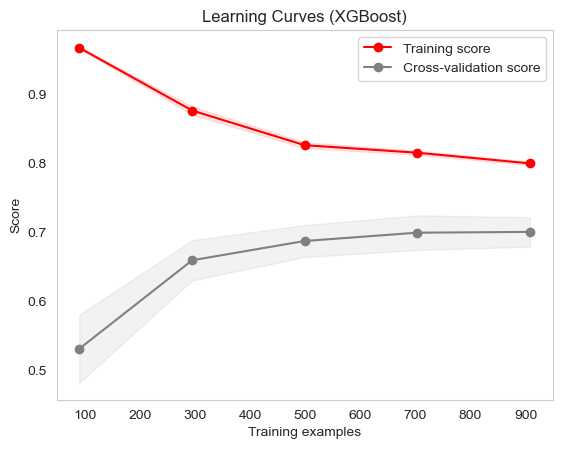

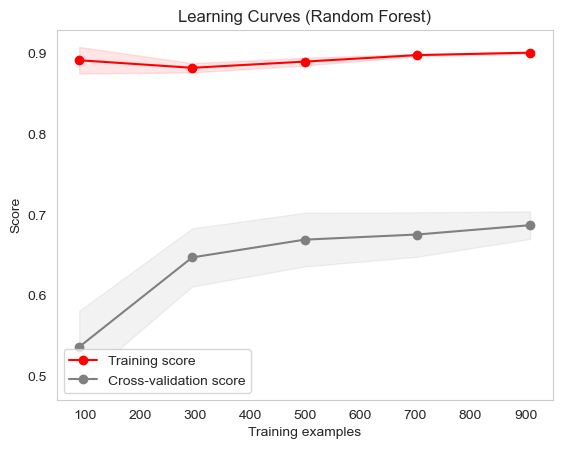

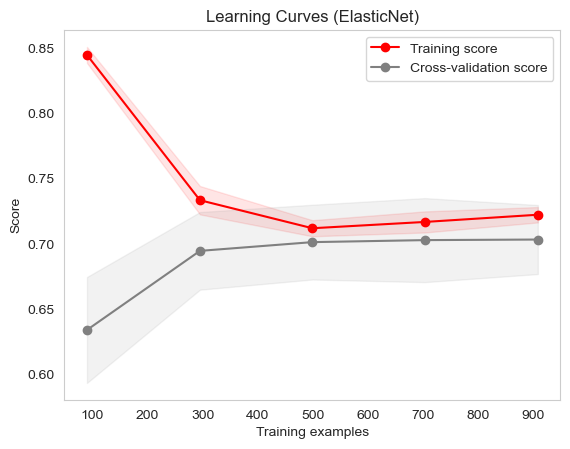

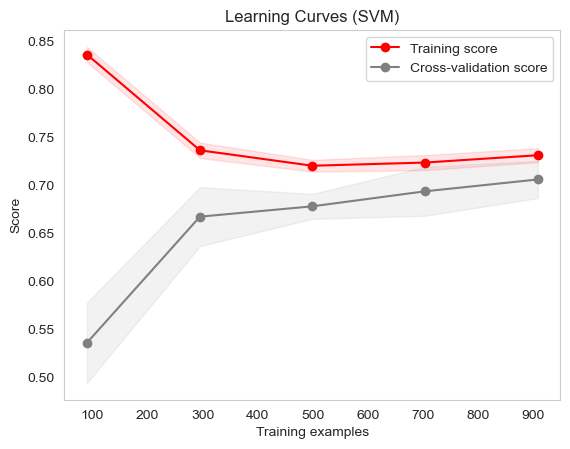

In [93]:




title = "Learning Curves (XGBoost)"
plot_learning_curve(grid_search_xgb.best_estimator_, title, X_train_encoded, y_train, cv=5, n_jobs=-1)
plt.show()


title = "Learning Curves (Random Forest)"
plot_learning_curve(grid_search_rf.best_estimator_, title, X_train_encoded, y_train_flat, cv=5, n_jobs=-1)
plt.show()


title = "Learning Curves (ElasticNet)"
plot_learning_curve(grid_search_en.best_estimator_, title, X_train_encoded, y_train, cv=5, n_jobs=-1)
plt.show()

title = "Learning Curves (SVM)"
plot_learning_curve(grid_search_svm.best_estimator_, title, X_train_encoded, y_train, cv=5, n_jobs=-1)
plt.show()

## 4.4 Résultats des essais sur données transformées


Résultats par validation croisée

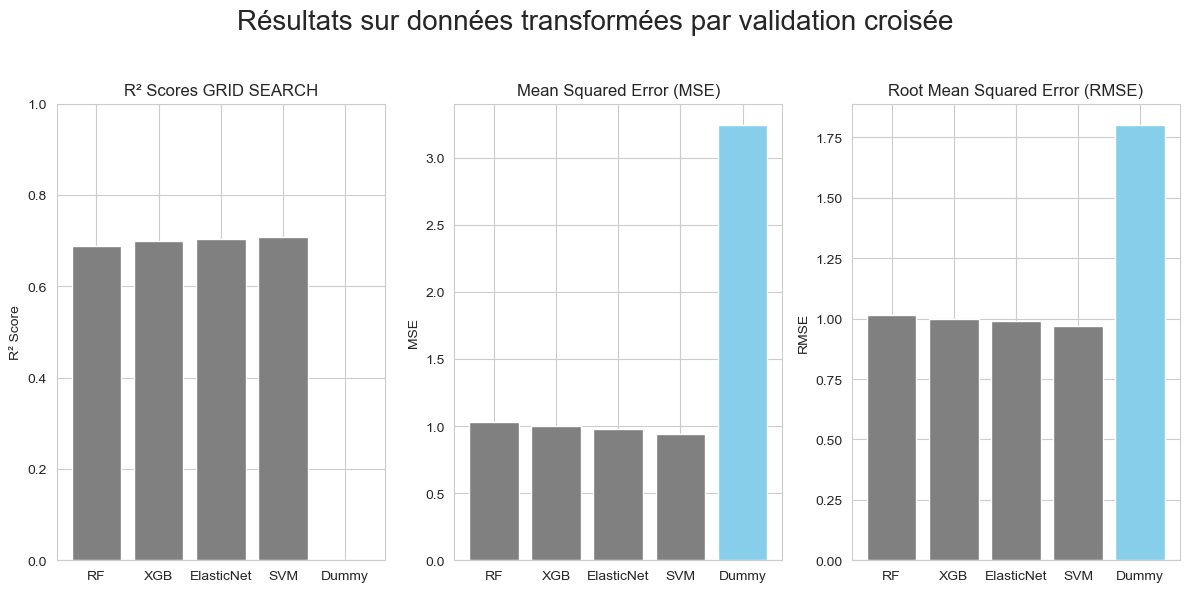

In [94]:


# Definition des noms des modèles et des scores
model_names = ['RF', 'XGB', 'ElasticNet', 'SVM', 'Dummy']
r2_scores = [grid_search_rf.best_score_, grid_search_xgb.best_score_, grid_search_en.best_score_, grid_search_svm.best_score_, r2_score_dummy]
mse_scores = [mse_rf, mse_xgb, mse_en, mse_svm, mse_dummy]
rmse_scores = [rmse_rf, rmse_xgb, rmse_en, rmse_svm, rmse_dummy]


colors = ['grey' if model != 'Dummy' else 'skyblue' for model in model_names]

plt.figure(figsize=(12, 6))

# R² scores
plt.subplot(1, 3, 1)
plt.bar(model_names, r2_scores, color=colors)
plt.title('R² Scores GRID SEARCH')
plt.ylabel('R² Score')
plt.ylim(0, 1)

# MSE scores
plt.subplot(1, 3, 2)
plt.bar(model_names, mse_scores, color=colors)
plt.title('Mean Squared Error (MSE)')
plt.ylabel('MSE')

# RMSE scores
plt.subplot(1, 3, 3)
plt.bar(model_names, rmse_scores, color=colors)
plt.title('Root Mean Squared Error (RMSE)')
plt.ylabel('RMSE')

plt.suptitle('Résultats sur données transformées par validation croisée', fontsize = 20)
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

In [95]:

start_time = time.time()

# Instantiation du modèle RandomForestRegressor avec les meilleurs paramètres
rf_model_best = RandomForestRegressor(
    max_depth=20,
    min_samples_leaf=1,
    min_samples_split=10,
    n_estimators=200,
)

# Entrainer le modèle avec les meilleurs paramètres
rf_model_best.fit(X_train_encoded, y_train)

# Préevoir les valeurs sur le jeu de test
y_pred_test = rf_model_best.predict(X_test_encoded)

# Calcul des métriques
r2_score_rf = r2_score(y_test, y_pred_test)
print("R² Score on Test Set:", r2_score_rf)
mse_rf = mean_squared_error(y_test, y_pred_test)
print("MSE on Test Set:", mse_rf)
rmse_rf = np.sqrt(mse_rf)
print("RMSE on Test Set:", rmse_rf)
rf_elapsed_time = time.time() - start_time
print("Computing time for :", rf_elapsed_time, "seconds")


R² Score on Test Set: 0.6790556598109305
MSE on Test Set: 1.035827665125175
RMSE on Test Set: 1.0177561913961393
Computing time for : 0.8748352527618408 seconds


In [96]:


start_time = time.time()

# Entrainer le modèle avec les meilleurs paramètres
xgb_model_best.fit(X_train_encoded, y_train)

# Prévoir les valeurs sur le jeu de test
y_pred_test = xgb_model_best.predict(X_test_encoded)

# Calcul des métriques
r2_score_xgb = r2_score(y_test, y_pred_test)
print("R² Score on Test Set:", r2_score_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_test)
print("MSE on Test Set:", mse_xgb)
rmse_xbg = np.sqrt(mse_xgb)
print("RMSE on Test Set:", rmse_xgb)
xgb_elapsed_time = time.time() - start_time
print("Computing time for :", xgb_elapsed_time, "seconds")






R² Score on Test Set: 0.6909334963749014
MSE on Test Set: 0.9974926949320613
RMSE on Test Set: 0.998745560656998
Computing time for : 0.07857513427734375 seconds


In [97]:


start_time = time.time()


# Instantiation du modèle SVM
svm_model = SVR()


# Instantiation avec les meilleurs paramètres
svm_model_best = SVR(**grid_search_svm.best_params_)

# Prévoir les valeurs sur le jeu d'entrainement'
svm_model_best.fit(X_train_encoded, y_train)

# Prédiction sur le jeu de test
y_pred_svm = svm_model_best.predict(X_test_encoded)

# Calcul des métriques
r2_score_svm = r2_score(y_test, y_pred_svm)
mse_svm = mean_squared_error(y_test, y_pred_svm)
rmse_svm = np.sqrt(mse_svm)
svm_elapsed_time = time.time() - start_time

print("R² score for SVM:", r2_score_svm)
print("MSE for SVM:", mse_svm)
print("RMSE for SVM:", rmse_svm)
print("Computing time for :", svm_elapsed_time, "seconds")

R² score for SVM: 0.7088761409322745
MSE for SVM: 0.9395839385193892
RMSE for SVM: 0.9693213804097117
Computing time for : 0.5675463676452637 seconds


In [98]:


start_time = time.time()


# Instantiation du modèle ElasticNet
en_model = ElasticNet()

# Instantiation du modèle ElasticNet avec les meilleurs paramètres
en_model_best = ElasticNet(**grid_search_en.best_params_)

# Entrainer le modèle sur le jeu d'entrainement
en_model_best.fit(X_train_encoded, y_train)

# Prédiction sur le jeu de test
y_pred_en = en_model_best.predict(X_test_encoded)

# Calcul des métriques
r2_score_en = r2_score(y_test, y_pred_en)
mse_en = mean_squared_error(y_test, y_pred_en)
rmse_en = np.sqrt(mse_en)
en_elapsed_time = time.time() - start_time
print("Computing time for :", en_elapsed_time, "seconds")
print("R² score for ElasticNet:", r2_score_en)
print("MSE for ElasticNet:", mse_en)
print("RMSE for ElasticNet:", rmse_en)

Computing time for : 0.002001047134399414 seconds
R² score for ElasticNet: 0.696753528796852
MSE for ElasticNet: 0.9787089064688328
RMSE for ElasticNet: 0.9892971780354136


#### Résultats des scores sur jeu de test

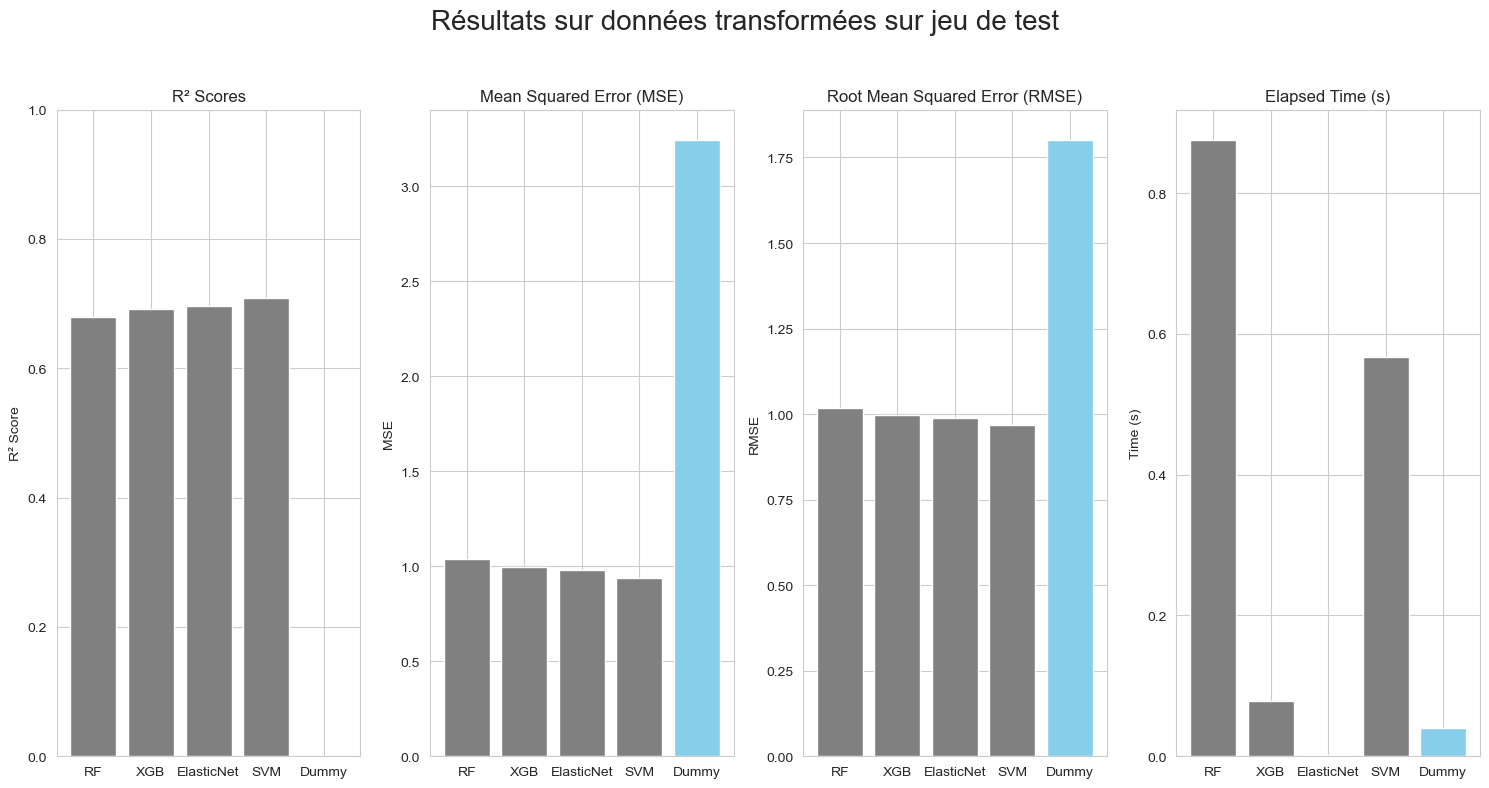

In [99]:


dummy_elapsed_time=0.04

# Definition des noms des modèles et des scores
model_names = ['RF', 'XGB', 'ElasticNet', 'SVM', 'Dummy']
r2_scores = [r2_score_rf, r2_score_xgb, r2_score_en, r2_score_svm, r2_score_dummy]
mse_scores = [mse_rf, mse_xgb, mse_en, mse_svm, mse_dummy]
rmse_scores = [rmse_rf, rmse_xgb, rmse_en, rmse_svm, rmse_dummy]
time_scores = [rf_elapsed_time, xgb_elapsed_time, en_elapsed_time, svm_elapsed_time, dummy_elapsed_time]


colors = ['grey' if model != 'Dummy' else 'skyblue' for model in model_names]

plt.figure(figsize=(15, 8))

# R² scores
plt.subplot(1, 4, 1)
plt.bar(model_names, r2_scores, color=colors)
plt.title('R² Scores')
plt.ylabel('R² Score')
plt.ylim(0, 1)

# MSE scores
plt.subplot(1, 4, 2)
plt.bar(model_names, mse_scores, color=colors)
plt.title('Mean Squared Error (MSE)')
plt.ylabel('MSE')

# RMSE scores
plt.subplot(1, 4, 3)
plt.bar(model_names, rmse_scores, color=colors)
plt.title('Root Mean Squared Error (RMSE)')
plt.ylabel('RMSE')

# Time scores
plt.subplot(1, 4, 4)
plt.bar(model_names, time_scores, color=colors)
plt.title('Elapsed Time (s)')
plt.ylabel('Time (s)')

plt.suptitle('Résultats sur données transformées sur jeu de test', fontsize = 20)
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()


## 4.6 Feature importance


Mise en place de la méthode shapley

In [100]:
shap.initjs()

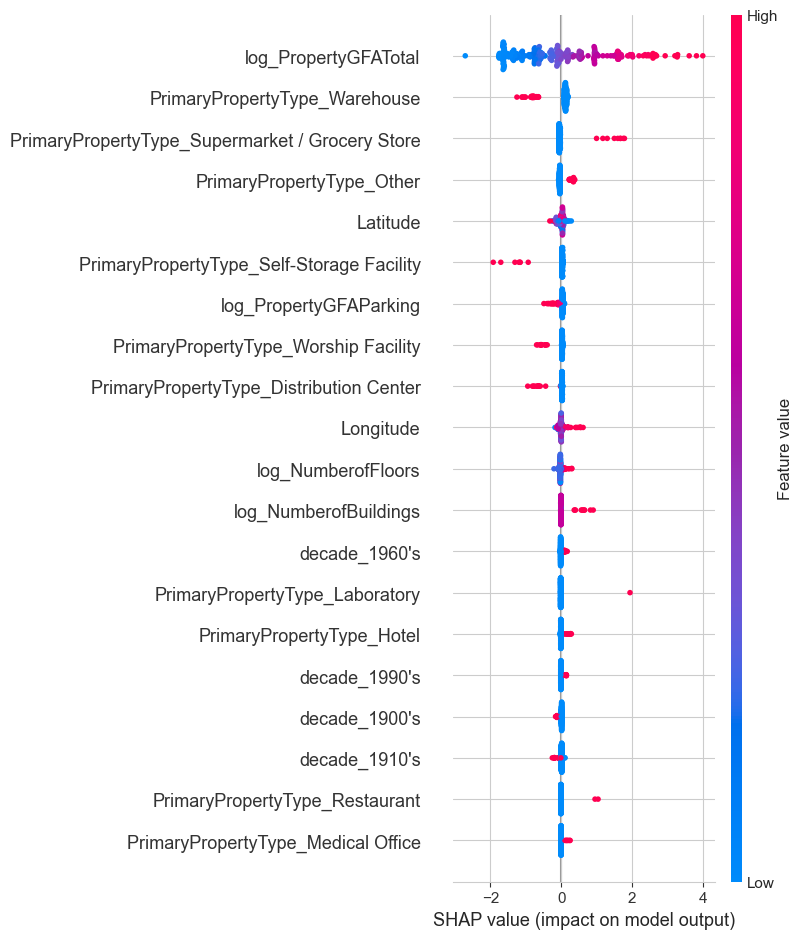

In [101]:

# Entrainer le modèle XGBoost avec les paramètres utilisés précédemment
xgboost_model = xgb.XGBRegressor(
    n_estimators=300, max_depth=3, learning_rate=0.05, random_state=42
)
xgboost_model.fit(X_train_encoded, y_train)

# Instantiation de l'explainer
explainer = shap.Explainer(xgboost_model)
shap_values = explainer.shap_values(X_test_encoded)

# Visualisation des SHAP values
shap.summary_plot(shap_values, X_test_encoded, feature_names=all_feature_names)




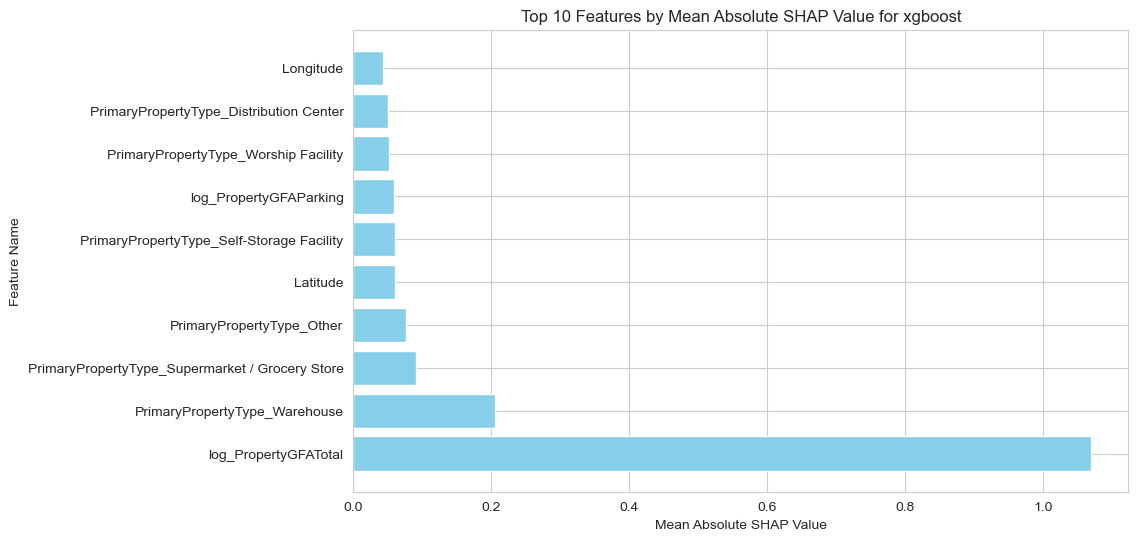

In [102]:


explainer = shap.TreeExplainer(xgboost_model)
shap_values = explainer.shap_values(X_test_encoded)
mean_shap_values = abs(shap_values).mean(axis=0)

# Tri des variables par importance
sorted_indices = mean_shap_values.argsort()[::-1]
sorted_features = [all_feature_names[i] for i in sorted_indices]
sorted_shap_values = mean_shap_values[sorted_indices]

# affichage du bar graph des variables les plus importantes
plt.figure(figsize=(10, 6))
plt.barh(sorted_features[:10], sorted_shap_values[:10], align='center', color='skyblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Feature Name')
plt.title('Top 10 Features by Mean Absolute SHAP Value for xgboost')
plt.show()

# <a name="C5">5. Ajout energy star score</a>

Filtrage des colonnes sans energy star score

In [103]:
ds_w_features_energyscore = ds_w_features.dropna(subset=['ENERGYSTARScore'])

<Axes: >

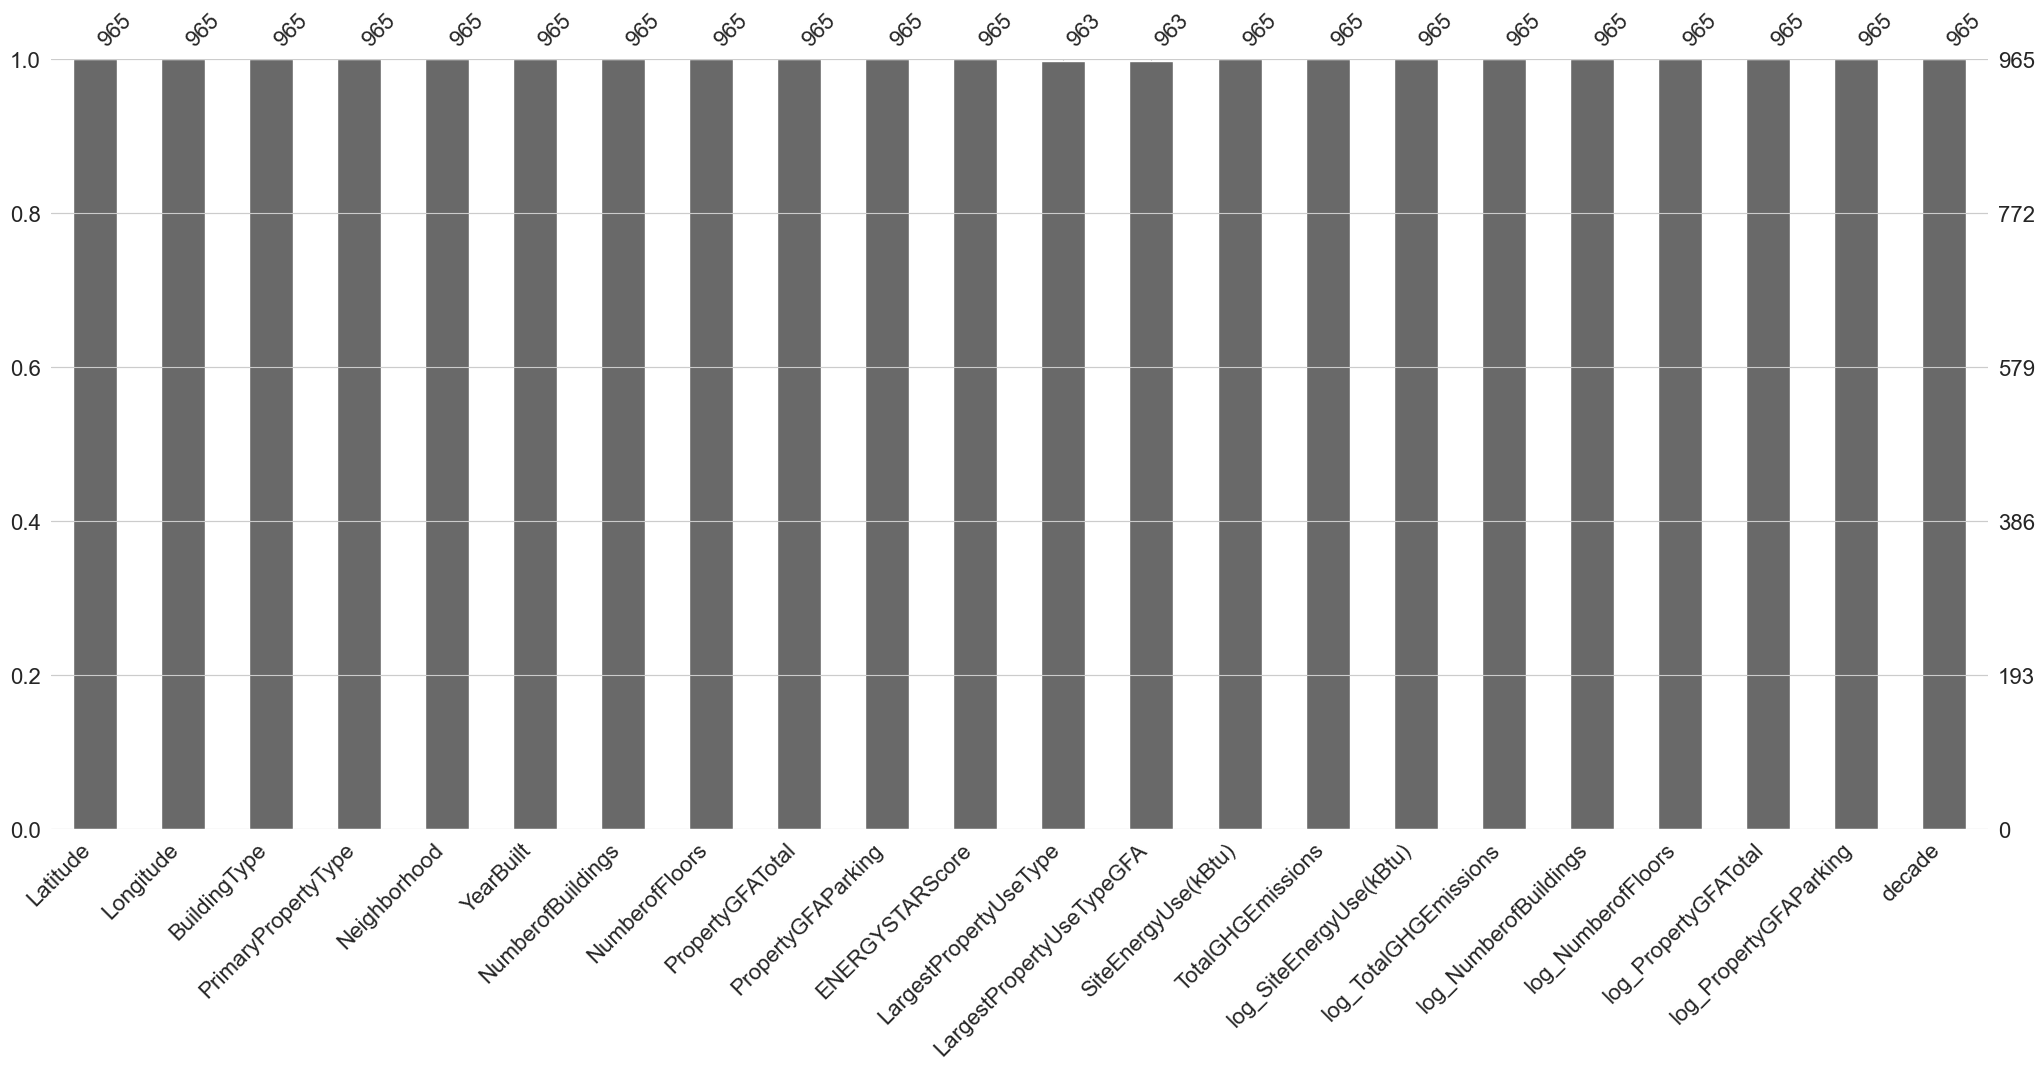

In [104]:
msno.bar(ds_w_features_energyscore)

Split

In [105]:
# Features et target
features = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'decade', 'log_NumberofBuildings', 'log_NumberofFloors', 'log_PropertyGFATotal', 'log_PropertyGFAParking','Latitude','Longitude','ENERGYSTARScore',]
target = ['log_SiteEnergyUse(kBtu)']

X = ds_w_features_energyscore[features]
y = ds_w_features_energyscore[target]

# split du jeu de données en 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Dimensions de X_train:", X_train.shape)
print("Dimensions de X_test:", X_test.shape)

Dimensions de X_train: (772, 11)
Dimensions de X_test: (193, 11)


Encodage

In [106]:


# selection des colonnes catégoriques à encoder
cat_columns = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood','decade']

# instanciation de l'encodeur
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Fit de l'encodeuer aux données
X_train_encoded_cat = encoder.fit_transform(X_train[cat_columns])
X_test_encoded_cat = encoder.transform(X_test[cat_columns])


encoded_feature_names = encoder.get_feature_names_out(input_features=cat_columns)


X_train_encoded = np.concatenate([X_train_encoded_cat, X_train.drop(cat_columns, axis=1)], axis=1)
X_test_encoded = np.concatenate([X_test_encoded_cat, X_test.drop(cat_columns, axis=1)], axis=1)


all_feature_names = np.concatenate([encoded_feature_names, X_train.drop(cat_columns, axis=1).columns])


print("Dimensions of X_train_encoded:", X_train_encoded.shape)
print("Dimensions of X_test_encoded:", X_test_encoded.shape)

Dimensions of X_train_encoded: (772, 54)
Dimensions of X_test_encoded: (193, 54)


c:\Users\jules\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Mise en place d'un baseline avec dummy regressor

In [107]:


dummy_regressor = DummyRegressor(strategy="mean")

# Fit du dummy regressor
dummy_regressor.fit(X_train_encoded, y_train)

# Prédiction sur le jeu de test
dummy_predictions = dummy_regressor.predict(X_test_encoded)

# Calcul des métriques
star_r2_score_dummy = r2_score(y_test, dummy_predictions)
star_mse_dummy = mean_squared_error(y_test, dummy_predictions)
star_rmse_dummy = np.sqrt(mse_dummy)

print("R² score for Dummy Regressor:", r2_score_dummy)
print("MSE for Dummy Regressor:", mse_dummy)
print("RMSE for Dummy Regressor:", rmse_dummy)

R² score for Dummy Regressor: -0.004031989106835443
MSE for Dummy Regressor: 3.240450074224235
RMSE for Dummy Regressor: 1.8001250162764348


In [108]:

start_time = time.time()

# Instantiation du modèle RandomForestRegressor avec les meilleurs paramètres
rf_model_best = RandomForestRegressor(
    max_depth=20,
    min_samples_leaf=1,
    min_samples_split=10,
    n_estimators=200,
)

# Entrainer le modèle avec les meilleurs paramètres
rf_model_best.fit(X_train_encoded, y_train)

# Préevoir les valeurs sur le jeu de test
y_pred_test = rf_model_best.predict(X_test_encoded)

# Calcul des métriques
star_r2_score_rf = r2_score(y_test, y_pred_test)
print("R² Score on Test Set:", star_r2_score_rf)
star_mse_rf = mean_squared_error(y_test, y_pred_test)
print("MSE on Test Set:", star_mse_rf)
star_rmse_rf = np.sqrt(star_mse_rf)
print("RMSE on Test Set:", star_rmse_rf)
star_rf_elapsed_time = time.time() - start_time
print("Computing time:", star_rf_elapsed_time, "seconds")



C:\Users\jules\AppData\Local\Temp\ipykernel_21172\841186188.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model_best.fit(X_train_encoded, y_train)


R² Score on Test Set: 0.8552012579225541
MSE on Test Set: 0.44104883697909847
RMSE on Test Set: 0.6641150781145527
Computing time: 0.6601300239562988 seconds


In [109]:

start_time = time.time()

# Entrainer le modèle avec les meilleurs paramètres
xgb_model_best.fit(X_train_encoded, y_train)

# Prévoir les valeurs sur le jeu de test
y_pred_test = xgb_model_best.predict(X_test_encoded)

# Calcul des métriques
star_r2_score_xgb = r2_score(y_test, y_pred_test)
print("R² Score on Test Set:", star_r2_score_xgb)
star_mse_xgb= mean_squared_error(y_test, y_pred_test)
print("MSE on Test Set:", star_mse_xgb)
star_rmse_xgb = np.sqrt(star_mse_xgb)
print("RMSE on Test Set:", star_rmse_xgb)
star_xgb_elapsed_time = time.time() - start_time
print("Computing time for :", star_xgb_elapsed_time, "seconds")

R² Score on Test Set: 0.8609427412228984
MSE on Test Set: 0.42356060126778694
RMSE on Test Set: 0.650815335765674
Computing time for : 0.07106566429138184 seconds


In [110]:

start_time = time.time()


# Instantiation du modèle SVM
svm_model = SVR()


# Instantiation avec les meilleurs paramètres
svm_model_best = SVR(**grid_search_svm.best_params_)

# Prévoir les valeurs sur le jeu d'entrainement'
svm_model_best.fit(X_train_encoded, y_train)

# Prédiction sur le jeu de test
y_pred_svm = svm_model_best.predict(X_test_encoded)

# Calcul des métriques
star_r2_score_svm = r2_score(y_test, y_pred_svm)
star_mse_svm = mean_squared_error(y_test, y_pred_svm)
star_rmse_svm = np.sqrt(mse_svm)
star_svm_elapsed_time = time.time() - start_time
print("Computing time for :", star_svm_elapsed_time, "seconds")

print("R² score for SVM:", star_r2_score_svm)
print("MSE for SVM:", star_mse_svm)
print("RMSE for SVM:", star_rmse_svm)

c:\Users\jules\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Computing time for : 9.695749998092651 seconds
R² score for SVM: 0.8311537523320407
MSE for SVM: 0.5142961885843464
RMSE for SVM: 0.9693213804097117


In [111]:

start_time = time.time()


# Instantiation du modèle ElasticNet
en_model = ElasticNet()

# Instantiation du modèle ElasticNet avec les meilleurs paramètres
en_model_best = ElasticNet(**grid_search_en.best_params_)

# Entrainer le modèle sur le jeu d'entrainement
en_model_best.fit(X_train_encoded, y_train)

# Prédiction sur le jeu de testt
y_pred_en = en_model_best.predict(X_test_encoded)

# Calcul des métriques
star_r2_score_en = r2_score(y_test, y_pred_en)
star_mse_en = mean_squared_error(y_test, y_pred_en)
star_rmse_en = np.sqrt(mse_en)
star_en_elapsed_time = time.time() - start_time
print("Computing time for :", star_en_elapsed_time, "seconds")

print("R² score for ElasticNet:", star_r2_score_en)
print("MSE for ElasticNet:", star_mse_en)
print("RMSE for ElasticNet:", star_rmse_en)

Computing time for : 0.003003835678100586 seconds
R² score for ElasticNet: 0.8514716744421229
MSE for ElasticNet: 0.4524089388201825
RMSE for ElasticNet: 0.9892971780354136


## 5.1 Résultats sur jeu de test


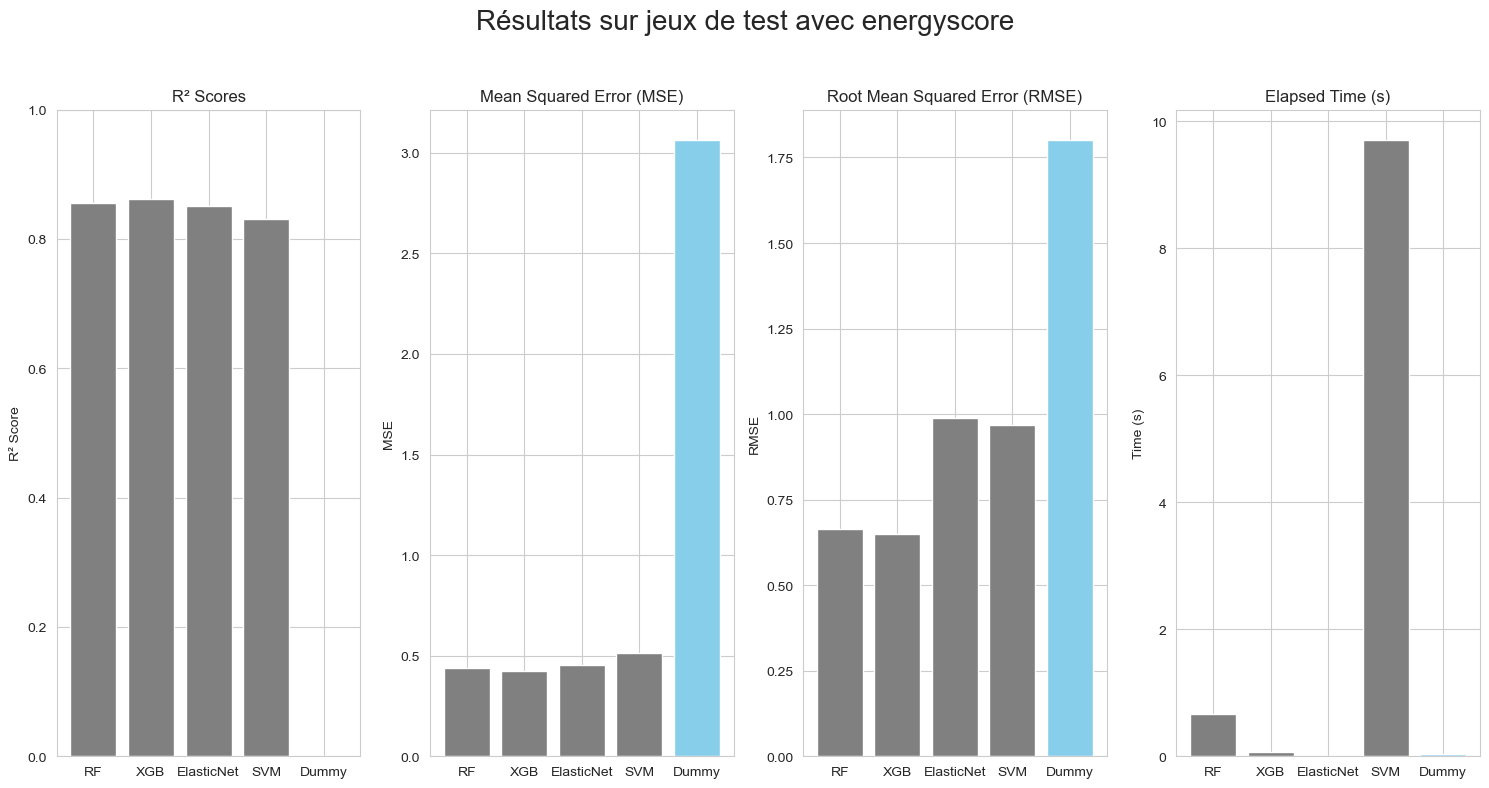

In [112]:

# Python
dummy_elapsed_time=0.04

# Definition des noms des modèles et des scores
model_names = ['RF', 'XGB', 'ElasticNet', 'SVM', 'Dummy']
r2_scores = [star_r2_score_rf, star_r2_score_xgb, star_r2_score_en, star_r2_score_svm, star_r2_score_dummy]
mse_scores = [star_mse_rf, star_mse_xgb, star_mse_en, star_mse_svm, star_mse_dummy]
rmse_scores = [star_rmse_rf, star_rmse_xgb, star_rmse_en, star_rmse_svm, rmse_dummy]
time_scores = [star_rf_elapsed_time, star_xgb_elapsed_time, star_en_elapsed_time, star_svm_elapsed_time, dummy_elapsed_time]


colors = ['grey' if model != 'Dummy' else 'skyblue' for model in model_names]

plt.figure(figsize=(15, 8))

# R² scores
plt.subplot(1, 4, 1)
plt.bar(model_names, r2_scores, color=colors)
plt.title('R² Scores')
plt.ylabel('R² Score')
plt.ylim(0, 1)

# MSE scores
plt.subplot(1, 4, 2)
plt.bar(model_names, mse_scores, color=colors)
plt.title('Mean Squared Error (MSE)')
plt.ylabel('MSE')

# RMSE scores
plt.subplot(1, 4, 3)
plt.bar(model_names, rmse_scores, color=colors)
plt.title('Root Mean Squared Error (RMSE)')
plt.ylabel('RMSE')

# Time scores
plt.subplot(1, 4, 4)
plt.bar(model_names, time_scores, color=colors)
plt.title('Elapsed Time (s)')
plt.ylabel('Time (s)')

plt.suptitle('Résultats sur jeux de test avec energyscore', fontsize = 20)
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

## 5.2 Comparaison des résultats avec et sans energy star score


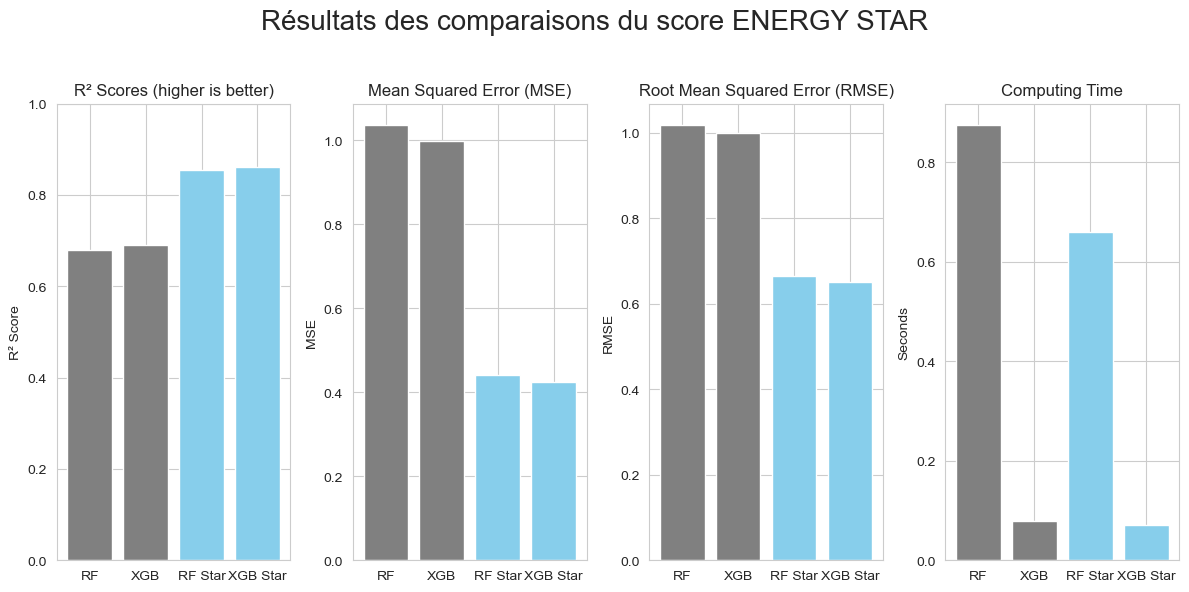

In [113]:


# Definition des noms des modèles et des scores
model_names = ['RF', 'XGB', 'RF Star', 'XGB Star']
r2_scores = [r2_score_rf, r2_score_xgb, star_r2_score_rf, star_r2_score_xgb]
mse_scores = [mse_rf, mse_xgb, star_mse_rf, star_mse_xgb]
rmse_scores = [rmse_rf, rmse_xgb, star_rmse_rf, star_rmse_xgb]
time_scores = [rf_elapsed_time, xgb_elapsed_time, star_rf_elapsed_time, star_xgb_elapsed_time]


colors_r2 = ['grey', 'grey', 'skyblue', 'skyblue']
colors_mse = ['grey', 'grey', 'skyblue', 'skyblue']
colors_rmse = ['grey', 'grey', 'skyblue', 'skyblue']
colors_time = ['grey', 'grey', 'skyblue', 'skyblue']

plt.figure(figsize=(12, 6))

# R² scores
plt.subplot(1, 4, 1)
plt.bar(model_names, r2_scores, color=colors_r2)
plt.title('R² Scores (higher is better)')
plt.ylabel('R² Score')
plt.ylim(0, 1)

# MSE scores
plt.subplot(1, 4, 2)
plt.bar(model_names, mse_scores, color=colors_mse)
plt.title('Mean Squared Error (MSE)')
plt.ylabel('MSE')

# RMSE scores
plt.subplot(1, 4, 3)
plt.bar(model_names, rmse_scores, color=colors_rmse)
plt.title('Root Mean Squared Error (RMSE)')
plt.ylabel('RMSE')

# Time score
plt.subplot(1, 4, 4)
plt.bar(model_names, time_scores, color=colors_time)
plt.title('Computing Time')
plt.ylabel('Seconds')

plt.suptitle('Résultats des comparaisons du score ENERGY STAR', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## 5.3 Feature importance avec variable energy star score


C:\Users\jules\AppData\Local\Temp\ipykernel_21172\3173504831.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rforest.fit(X_train_encoded, y_train)


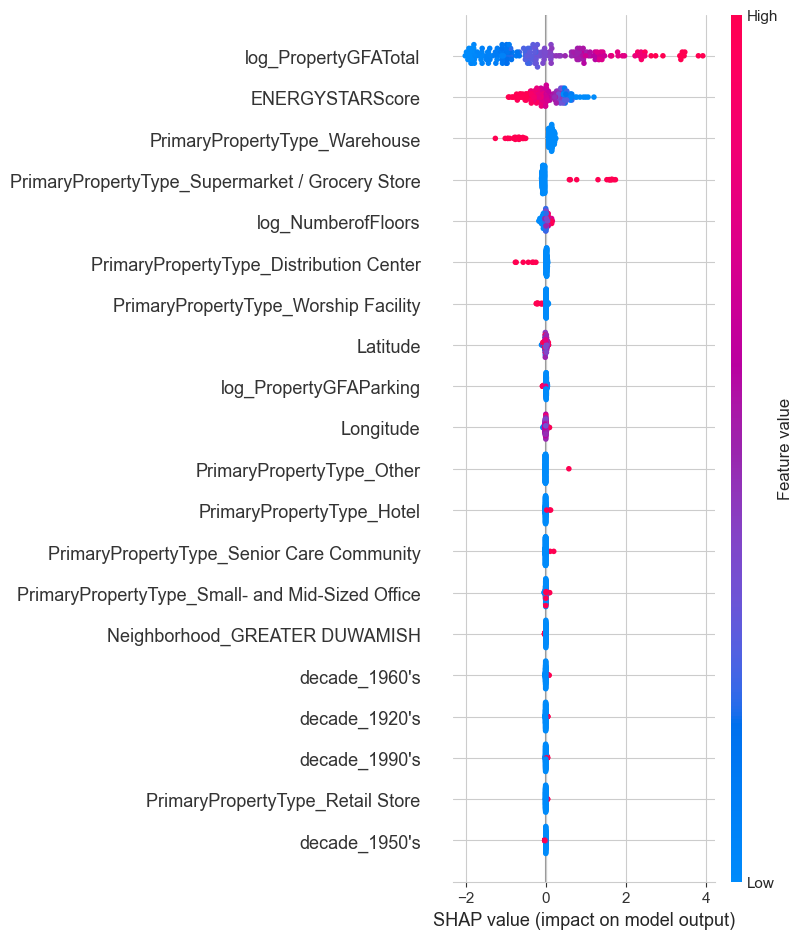

In [114]:


# Entrainer le modèle Randomforest avec les paramètres utilisés précédemment
rforest = RandomForestRegressor(
    n_estimators=200, max_depth=20, min_samples_split=10, min_samples_leaf=1, random_state=42
)
rforest.fit(X_train_encoded, y_train)


# Instantiation de l'explainer
explainer = shap.TreeExplainer(rforest)
shap_values = explainer.shap_values(X_test_encoded)
# Visualisation des SHAP values
shap.summary_plot(shap_values, X_test_encoded, feature_names=all_feature_names)

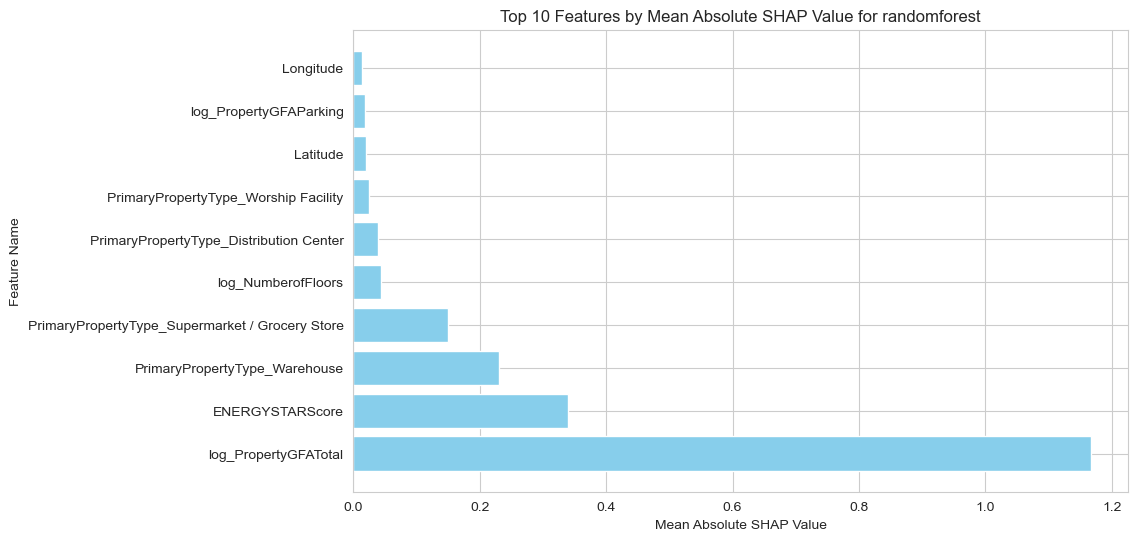

In [115]:

explainer = shap.TreeExplainer(rforest)
shap_values = explainer.shap_values(X_test_encoded)
mean_shap_values = abs(shap_values).mean(axis=0)

# Tri des variables par importance
sorted_indices = mean_shap_values.argsort()[::-1]
sorted_features = [all_feature_names[i] for i in sorted_indices]
sorted_shap_values = mean_shap_values[sorted_indices]

# affichage du bar graph des variables les plus importantes
plt.figure(figsize=(10, 6))
plt.barh(sorted_features[:10], sorted_shap_values[:10], align='center',color = 'skyblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Feature Name')
plt.title('Top 10 Features by Mean Absolute SHAP Value for randomforest')
plt.show()

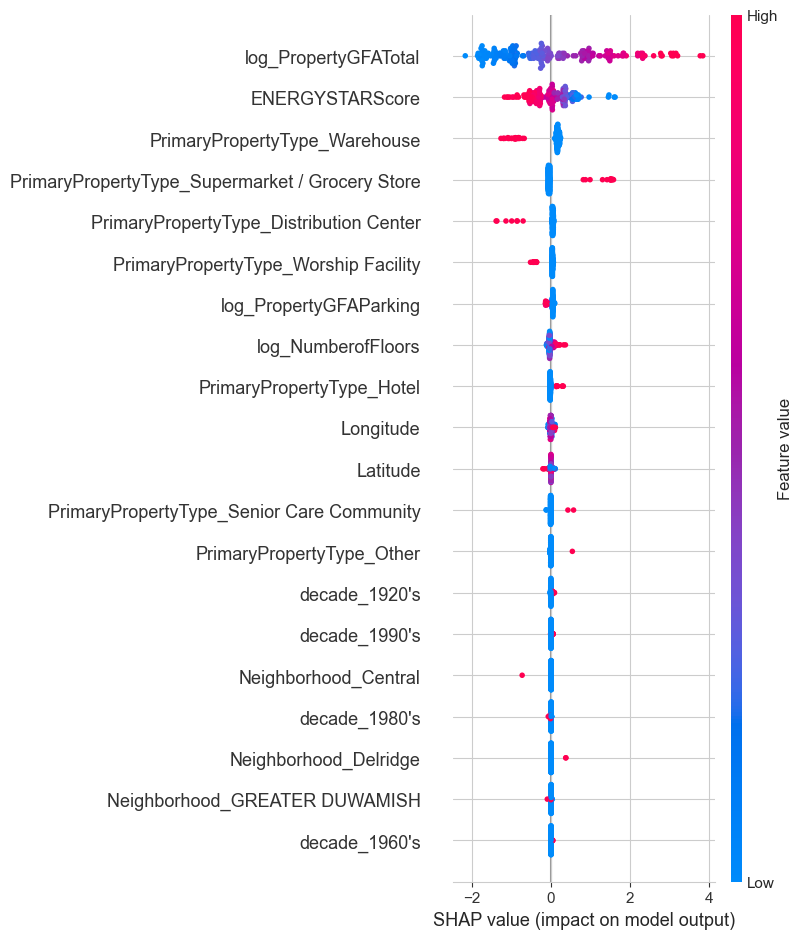

In [116]:


# Entrainer le modèle XGBoost avec les paramètres utilisés précédemment
xgboost_model = xgb.XGBRegressor(
    n_estimators=300, max_depth=3, learning_rate=0.05, random_state=42
)
xgboost_model.fit(X_train_encoded, y_train)

# Instantiation de l'explainer
explainer = shap.Explainer(xgboost_model)
shap_values = explainer.shap_values(X_test_encoded)

# Visualisation des SHAP values
shap.summary_plot(shap_values, X_test_encoded, feature_names=all_feature_names)

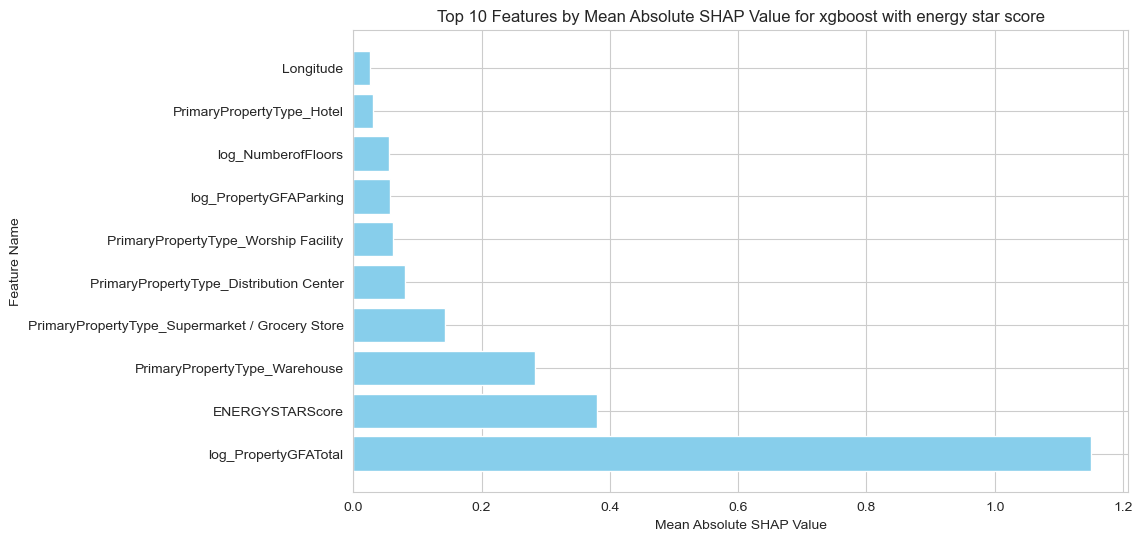

In [117]:

explainer = shap.TreeExplainer(xgboost_model)
shap_values = explainer.shap_values(X_test_encoded)
mean_shap_values = abs(shap_values).mean(axis=0)

# Tri des variables par importance
sorted_indices = mean_shap_values.argsort()[::-1]
sorted_features = [all_feature_names[i] for i in sorted_indices]
sorted_shap_values = mean_shap_values[sorted_indices]

# affichage du bar graph des variables les plus importantes
plt.figure(figsize=(10, 6))
plt.barh(sorted_features[:10], sorted_shap_values[:10], align='center', color='skyblue')
plt.xlabel('Mean Absolute SHAP Value')
plt.ylabel('Feature Name')
plt.title('Top 10 Features by Mean Absolute SHAP Value for xgboost with energy star score')
plt.show()

## 4.5 Essai avec réduction de dimensionalité

In [118]:

# Features et target
features = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'decade', 'log_NumberofBuildings', 'log_NumberofFloors', 'log_PropertyGFATotal', 'log_PropertyGFAParking','Latitude','Longitude']
target = ['log_SiteEnergyUse(kBtu)']

X = ds_w_features[features]
y = ds_w_features[target]

# split du jeu de données en 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# selection des colonnes catégoriques à encoder
cat_columns = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood','decade']

# instanciation de l'encodeur
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Fit de l'encodeur aux données
X_train_encoded_cat = encoder.fit_transform(X_train[cat_columns])
X_test_encoded_cat = encoder.transform(X_test[cat_columns])


encoded_feature_names = encoder.get_feature_names_out(input_features=cat_columns)


X_train_encoded = np.concatenate([X_train_encoded_cat, X_train.drop(cat_columns, axis=1)], axis=1)
X_test_encoded = np.concatenate([X_test_encoded_cat, X_test.drop(cat_columns, axis=1)], axis=1)
all_feature_names = np.concatenate([encoded_feature_names, X_train.drop(cat_columns, axis=1).columns])

# Application de l'acp de l'acp
pca = PCA(n_components=5)  # 
X_train_pca = pca.fit_transform(X_train.drop(cat_columns, axis=1))

X_test_pca = pca.transform(X_test.drop(cat_columns, axis=1))


X_train_final = np.concatenate([X_train_pca, X_train_encoded_cat], axis=1)
X_test_final = np.concatenate([X_test_pca, X_test_encoded_cat], axis=1)

# Dimension des datasets
print("Dimensions of X_train_final:", X_train_final.shape)
print("Dimensions of X_test_final:", X_test_final.shape)



Dimensions of X_train_final: (1136, 56)
Dimensions of X_test_final: (284, 56)


c:\Users\jules\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [119]:



# Features et target
features = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'decade', 'log_NumberofBuildings', 'log_NumberofFloors', 'log_PropertyGFATotal', 'log_PropertyGFAParking','Latitude','Longitude']
target = ['log_SiteEnergyUse(kBtu)']

X = ds_w_features[features]
y = ds_w_features[target]

# split du jeu de données en 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# selection des colonnes catégoriques à encoder
cat_columns = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood','decade']

# Encodage onehot
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')


X_train_encoded_cat = encoder.fit_transform(X_train[cat_columns])
X_test_encoded_cat = encoder.transform(X_test[cat_columns])

encoded_feature_names = encoder.get_feature_names_out(input_features=cat_columns)

# Concatenation des données encodées et non encodées
X_train_encoded = np.concatenate([X_train_encoded_cat, X_train.drop(cat_columns, axis=1)], axis=1)
X_test_encoded = np.concatenate([X_test_encoded_cat, X_test.drop(cat_columns, axis=1)], axis=1)

all_feature_names = np.concatenate([encoded_feature_names, X_train.drop(cat_columns, axis=1).columns])

# Applcation de l'acp
pca = PCA(n_components=5)  # 
X_train_pca = pca.fit_transform(X_train.drop(cat_columns, axis=1))
X_test_pca = pca.transform(X_test.drop(cat_columns, axis=1))

# Standardisation des données PCA-transformées
scaler = StandardScaler()
X_train_pca_scaled = scaler.fit_transform(X_train_pca)
X_test_pca_scaled = scaler.transform(X_test_pca)

# Concatenatation des données PCA-transformées et encodées
X_train_final = np.concatenate([X_train_pca_scaled, X_train_encoded_cat], axis=1)
X_test_final = np.concatenate([X_test_pca_scaled, X_test_encoded_cat], axis=1)

# Dimension des datasets
print("Dimensions of X_train_final:", X_train_final.shape)
print("Dimensions of X_test_final:", X_test_final.shape)

Dimensions of X_train_final: (1136, 56)
Dimensions of X_test_final: (284, 56)


c:\Users\jules\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [120]:

dummy_regressor = DummyRegressor(strategy="mean")

# Fit du dummy regressor
dummy_regressor.fit(X_train_final, y_train)

# Prédiction sur le jeu de test
dummy_predictions = dummy_regressor.predict(X_test_encoded)

# Calcul des métriques
pca_r2_score_dummy = r2_score(y_test, dummy_predictions)
pca_mse_dummy = mean_squared_error(y_test, dummy_predictions)
pca_rmse_dummy = np.sqrt(pca_mse_dummy)

print("R² score for Dummy Regressor:", pca_r2_score_dummy)
print("MSE for Dummy Regressor:", pca_mse_dummy)
print("RMSE for Dummy Regressor:", pca_rmse_dummy)

R² score for Dummy Regressor: -0.004031989106835443
MSE for Dummy Regressor: 3.240450074224235
RMSE for Dummy Regressor: 1.8001250162764348


In [121]:


# Définition de la grille de paramètres
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Conversion de y_train en array 1D
y_train_flat = y_train.values.ravel()

# Instantiatiation du modèle RandomForestRegressor
rf_model = RandomForestRegressor()

# Creation de la grille de recherche
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='r2')

# Grille de recherche sur les données d'entrainement
grid_search_rf.fit(X_train_final, y_train_flat) 

# affichage des meilleurs paramètres
print("Best Parameters for RandomForest:", grid_search_rf.best_params_)

# Affichage du meilleur score r²
print("Best Score (R²) for RandomForest:", grid_search_rf.best_score_)

# Instantiatiation du modèle RandomForestRegressor avec les meilleurs paramètres
rf_model_best = RandomForestRegressor(**grid_search_rf.best_params_)

# Entrainement du modèle
rf_model_best.fit(X_train_final, y_train)

# Calcul des prédictions sur le jeu de test
y_pred = rf_model_best.predict(X_test_final)

# Calcul des métriques
pca_r2_score_rf = r2_score(y_test, y_pred)
pca_mse_rf = mean_squared_error(y_test, y_pred)
pca_rmse_rf = np.sqrt(pca_mse_rf)

print("R² score for RandomForest:", pca_r2_score_rf)
print("MSE for RandomForest:", pca_mse_rf)
print("RMSE for RandomForest:",pca_rmse_rf)

Best Parameters for RandomForest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best Score (R²) for RandomForest: 0.6617401341033418


C:\Users\jules\AppData\Local\Temp\ipykernel_21172\4032808173.py:31: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model_best.fit(X_train_final, y_train)


R² score for RandomForest: 0.6637033264935639
MSE for RandomForest: 1.0853763549851771
RMSE for RandomForest: 1.0418139733105796


In [122]:


start_time = time.time()

# Definition des paramètres de la grille de recherche
param_grid_xgb = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 9, 11],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

# Instantiation du XGBoostRegressor
xgb_model = xgb.XGBRegressor()

# Definition du scorer en fonction du r²
scoring = make_scorer(r2_score)

# Creation de la grille de recherche
grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=5, scoring=scoring)

# Grille de recherche sur les données d'entraînement
grid_search_xgb.fit(X_train_final, y_train)  

# affichage des meilleurs paramètres
print("Best Parameters for XGBoost:", grid_search_xgb.best_params_)

# Affichage du meilleur score r²
print("Best Score (R²) for XGBoost:", grid_search_xgb.best_score_)

# Instantiation du modèle XGBoostRegressor avec les meilleurs paramètres
xgb_model_best = xgb.XGBRegressor(**grid_search_xgb.best_params_)

# Entrainement du modèle
xgb_model_best.fit(X_train_final, y_train)

# Calcul des prédictions sur le jeu de test
y_pred = xgb_model_best.predict(X_test_final)

# Calcul des métriques
pca_r2_score_xgb = r2_score(y_test, y_pred)
pca_mse_xgb = mean_squared_error(y_test, y_pred)
pca_rmse_xgb = np.sqrt(pca_mse_xgb)

print("R² score for XGBoost:", pca_r2_score_xgb)
print("MSE for XGBoost:", pca_mse_xgb)
print("RMSE for XGBoost:", pca_rmse_xgb)



Best Parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best Score (R²) for XGBoost: 0.6826297428220368
R² score for XGBoost: 0.6781221619238308
MSE for XGBoost: 1.0388404708229606
RMSE for XGBoost: 1.0192352382168508


In [123]:

start_time = time.time()

# Definition des paramètres pour ElasticNet
param_grid_en = {
    'alpha': [0.01, 0.1, 1.0],
    'l1_ratio': [0.1, 0.5, 0.9]
}

# Instantiatiation du modèle ElasticNet
en_model = ElasticNet()

# Définir le scorer en fonction du r²
scoring = make_scorer(r2_score)

# Création de la grille de recherche
grid_search_en = GridSearchCV(estimator=en_model, param_grid=param_grid_en, cv=5, scoring=scoring)

# Grille de recherche sur les données d'entraînement
grid_search_en.fit(X_train_final, y_train) 

# Affichage des meilleurs paramètres
print("Best Parameters for ElasticNet:", grid_search_en.best_params_)

# Affichage du meilleur score r²
print("Best Score (R²) for ElasticNet:", grid_search_en.best_score_)

# Instantiation du modèle ElasticNet avec les meilleurs paramètres
en_model_best = ElasticNet(**grid_search_en.best_params_)

# Entrainement du modèle
en_model_best.fit(X_train_final, y_train)

# Calcul des prédictions sur le jeu de test
y_pred_en = en_model_best.predict(X_test_final)

# Calcul des métriques
pca_r2_score_en = r2_score(y_test, y_pred_en)
pca_mse_en = mean_squared_error(y_test, y_pred_en)
pca_rmse_en = np.sqrt(mse_en)

print("R² score for ElasticNet:", pca_r2_score_en)
print("MSE for ElasticNet:", pca_mse_en)
print("RMSE for ElasticNet:", pca_rmse_en)

Best Parameters for ElasticNet: {'alpha': 0.01, 'l1_ratio': 0.5}
Best Score (R²) for ElasticNet: 0.704397398915925
R² score for ElasticNet: 0.6975145117910877
MSE for ElasticNet: 0.9762528817336568
RMSE for ElasticNet: 0.9892971780354136


In [124]:


# Reshape y_train and y_test to 1D arrays
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

start_time = time.time()

# Instantiatiation des paramètres pour le modèle SVM
param_grid_svm = {
    'kernel': ['linear', 'rbf', 'poly'],
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto'],
}

# Instantiatiation du modèle
svm_model = SVR()

# Définir le scorer en fonction du r²
scoring = make_scorer(r2_score)

# Création de la grille de recherche
grid_search_svm = GridSearchCV(estimator=svm_model, param_grid=param_grid_svm, cv=5, scoring=scoring)

# Grille de recherche sur les données d'entraînement
grid_search_svm.fit(X_train_final, y_train) 

# Affichage des meilleurs paramètres
print("Best Parameters for SVM:", grid_search_svm.best_params_)

# Affichage du meilleur score r²
print("Best Score (R²) for SVM:", grid_search_svm.best_score_)

# Instantiation du modèle SVM avec les meilleurs paramètres
svm_model_best = SVR(**grid_search_svm.best_params_)

# Entrainement du modèle
svm_model_best.fit(X_train_final, y_train)

# Calcul des prédictions sur le jeu de test
y_pred_svm = svm_model_best.predict(X_test_final)

# Calcul des métriques
pca_r2_score_svm = r2_score(y_test, y_pred_svm)
pca_mse_svm = mean_squared_error(y_test, y_pred_svm)
pca_rmse_svm = np.sqrt(pca_mse_svm)

print("R² score for SVM:", pca_r2_score_svm)
print("MSE for SVM:", pca_mse_svm)
print("RMSE for SVM:", pca_rmse_svm)

print("Total Time Taken:", time.time() - start_time)


Best Parameters for SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best Score (R²) for SVM: 0.7051814079429162
R² score for SVM: 0.709827022405163
MSE for SVM: 0.9365150283921919
RMSE for SVM: 0.9677370657323154
Total Time Taken: 6.74984884262085


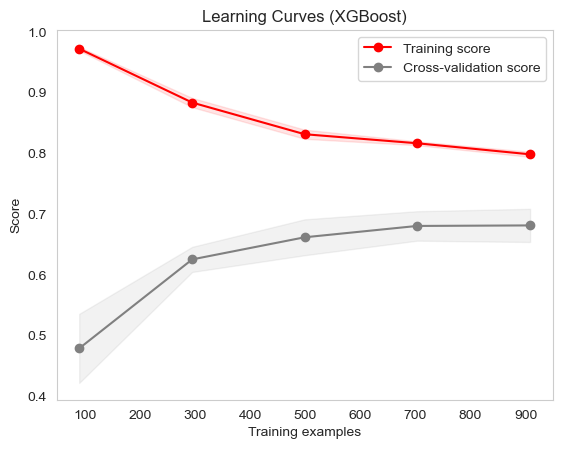

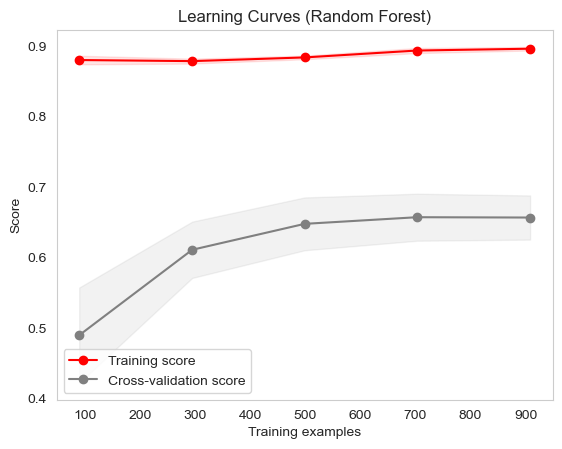

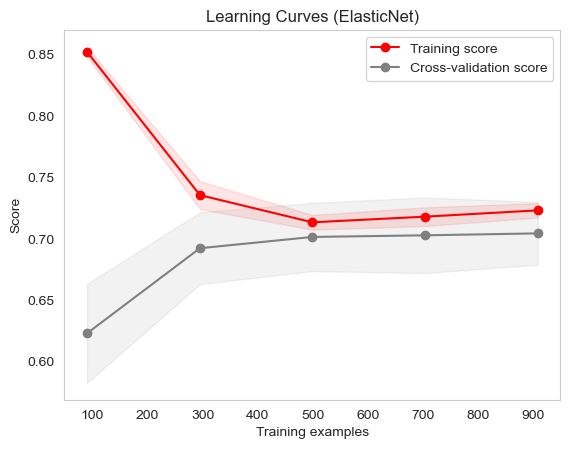

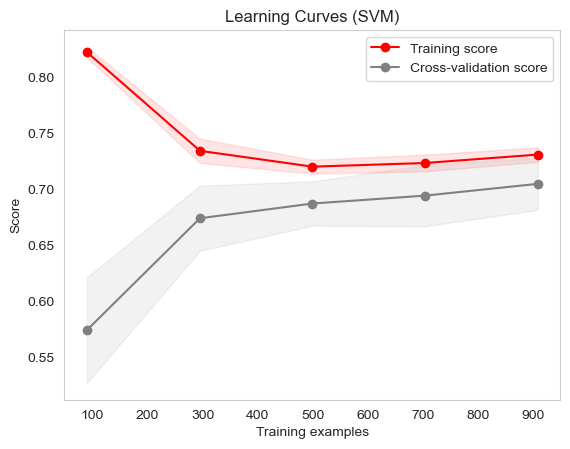

In [125]:





title = "Learning Curves (XGBoost)"
plot_learning_curve(grid_search_xgb.best_estimator_, title, X_train_final, y_train, cv=5, n_jobs=-1)
plt.show()


title = "Learning Curves (Random Forest)"
plot_learning_curve(grid_search_rf.best_estimator_, title, X_train_final, y_train_flat, cv=5, n_jobs=-1)
plt.show()


title = "Learning Curves (ElasticNet)"
plot_learning_curve(grid_search_en.best_estimator_, title, X_train_final, y_train, cv=5, n_jobs=-1)
plt.show()

title = "Learning Curves (SVM)"
plot_learning_curve(grid_search_svm.best_estimator_, title, X_train_final, y_train, cv=5, n_jobs=-1)
plt.show()

Resultats des scores de validation croisée sur données réduites

In [126]:


# Start timing
start_time = time.time()

# Instantiate RandomForestRegressor with best parameters
rf_model_best = RandomForestRegressor(
    max_depth=20,
    min_samples_leaf=1,
    min_samples_split=10,
    n_estimators=200,
)

# Train the model on the training set
rf_model_best.fit(X_train_final, y_train)

# Make predictions on the test set
y_pred_test = rf_model_best.predict(X_test_final)

# Calculate R² score
r2_score_rf = r2_score(y_test, y_pred_test)
print("R² Score on Test Set:", r2_score_rf)

# Calculate Mean Squared Error (MSE)
mse_rf = mean_squared_error(y_test, y_pred_test)
print("MSE on Test Set:", mse_rf)

# Calculate Root Mean Squared Error (RMSE)
rmse_rf = np.sqrt(mse_rf)
print("RMSE on Test Set:", rmse_rf)

# Calculate computing time
rf_elapsed_time = time.time() - start_time
print("Computing time for :", rf_elapsed_time, "seconds")


R² Score on Test Set: 0.6696870571402067
MSE on Test Set: 1.0660642408011456
RMSE on Test Set: 1.0325038696301072
Computing time for : 0.982935905456543 seconds


In [127]:


# Start timing
start_time = time.time()

# Train the XGBoost model on the training set
xgb_model_best.fit(X_train_final, y_train)

# Make predictions on the test set
y_pred_test = xgb_model_best.predict(X_test_final)

# Calculate R² score
r2_score_xgb = r2_score(y_test, y_pred_test)
print("R² Score on Test Set:", r2_score_xgb)

# Calculate Mean Squared Error (MSE)
mse_xgb = mean_squared_error(y_test, y_pred_test)
print("MSE on Test Set:", mse_xgb)

# Calculate Root Mean Squared Error (RMSE)
rmse_xbg = np.sqrt(mse_xgb)
print("RMSE on Test Set:", rmse_xgb)

# Calculate computing time
xgb_elapsed_time = time.time() - start_time
print("Computing time for :", xgb_elapsed_time, "seconds")

R² Score on Test Set: 0.6781221619238308
MSE on Test Set: 1.0388404708229606
RMSE on Test Set: 0.998745560656998
Computing time for : 0.0420377254486084 seconds


In [128]:


start_time = time.time()


# Instantiate SVM model
svm_model = SVR()


# Instantiate SVM with best parameters
svm_model_best = SVR(**grid_search_svm.best_params_)

# Train the model
svm_model_best.fit(X_train_final, y_train)

# Calculate predictions on the test set
y_pred_svm = svm_model_best.predict(X_test_final)

# Calculate R² score
r2_score_svm = r2_score(y_test, y_pred_svm)

# Calculate Mean Squared Error (MSE)
mse_svm = mean_squared_error(y_test, y_pred_svm)

# Calculate Root Mean Squared Error (RMSE)
rmse_svm = np.sqrt(mse_svm)

# Calculate computing time
svm_elapsed_time = time.time() - start_time
print("Computing time for :", svm_elapsed_time, "seconds")

print("R² score for SVM:", r2_score_svm)
print("MSE for SVM:", mse_svm)
print("RMSE for SVM:", rmse_svm)

Computing time for : 0.1501462459564209 seconds
R² score for SVM: 0.709827022405163
MSE for SVM: 0.9365150283921919
RMSE for SVM: 0.9677370657323154


In [129]:


start_time = time.time()


# Instantiate ElasticNet model
en_model = ElasticNet()

# Instantiate ElasticNet with best parameters
en_model_best = ElasticNet(**grid_search_en.best_params_)

# Train the model
en_model_best.fit(X_train_final, y_train)

# Calculate predictions on the test set
y_pred_en = en_model_best.predict(X_test_final)

# Calculate R² score
r2_score_en = r2_score(y_test, y_pred_en)

# Calculate Mean Squared Error (MSE)
mse_en = mean_squared_error(y_test, y_pred_en)

# Calculate Root Mean Squared Error (RMSE)
rmse_en = np.sqrt(mse_en)

# Calculate computing time
en_elapsed_time = time.time() - start_time
print("Computing time for :", en_elapsed_time, "seconds")

print("R² score for ElasticNet:", r2_score_en)
print("MSE for ElasticNet:", mse_en)
print("RMSE for ElasticNet:", rmse_en)

Computing time for : 0.0020020008087158203 seconds
R² score for ElasticNet: 0.6975145117910877
MSE for ElasticNet: 0.9762528817336568
RMSE for ElasticNet: 0.9880551005554583


Resultats des scores de validation croisée sur données réduites

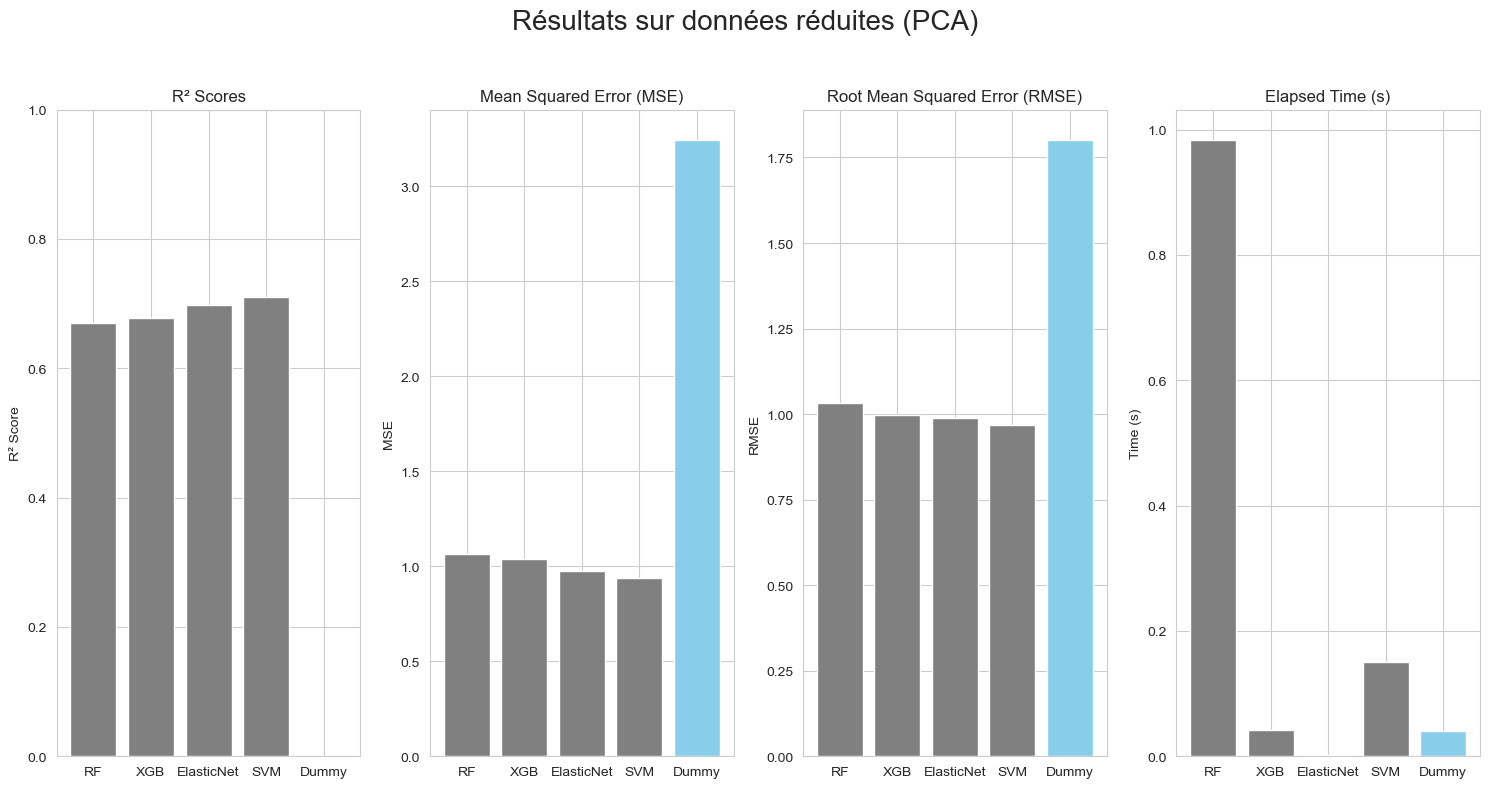

<Figure size 640x480 with 0 Axes>

In [130]:

dummy_elapsed_time=0.04

# Define model names and corresponding scores
model_names = ['RF', 'XGB', 'ElasticNet', 'SVM', 'Dummy']
r2_scores = [r2_score_rf, r2_score_xgb, r2_score_en, r2_score_svm, r2_score_dummy]
mse_scores = [mse_rf, mse_xgb, mse_en, mse_svm, mse_dummy]
rmse_scores = [rmse_rf, rmse_xgb, rmse_en, rmse_svm, rmse_dummy]
time_scores = [rf_elapsed_time, xgb_elapsed_time, en_elapsed_time, svm_elapsed_time, dummy_elapsed_time]


colors = ['grey' if model != 'Dummy' else 'skyblue' for model in model_names]

plt.figure(figsize=(15, 8)) 

# R² scores
plt.subplot(1, 4, 1)
plt.bar(model_names, r2_scores, color=colors)
plt.title('R² Scores')
plt.ylabel('R² Score')
plt.ylim(0, 1)

# MSE scores
plt.subplot(1, 4, 2)
plt.bar(model_names, mse_scores, color=colors)
plt.title('Mean Squared Error (MSE)')
plt.ylabel('MSE')

# RMSE scores
plt.subplot(1, 4, 3)
plt.bar(model_names, rmse_scores, color=colors)
plt.title('Root Mean Squared Error (RMSE)')
plt.ylabel('RMSE')

# Time scores
plt.subplot(1, 4, 4)
plt.bar(model_names, time_scores, color=colors)
plt.title('Elapsed Time (s)')
plt.ylabel('Time (s)')

plt.suptitle('Résultats sur données réduites (PCA)', fontsize = 20)
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show() 
plt.tight_layout()
plt.show()

Essai avec la variable energystarscore avec données réduites

In [131]:
ds_w_features_energyscore = ds_w_features.dropna(subset=['ENERGYSTARScore'])

<Axes: >

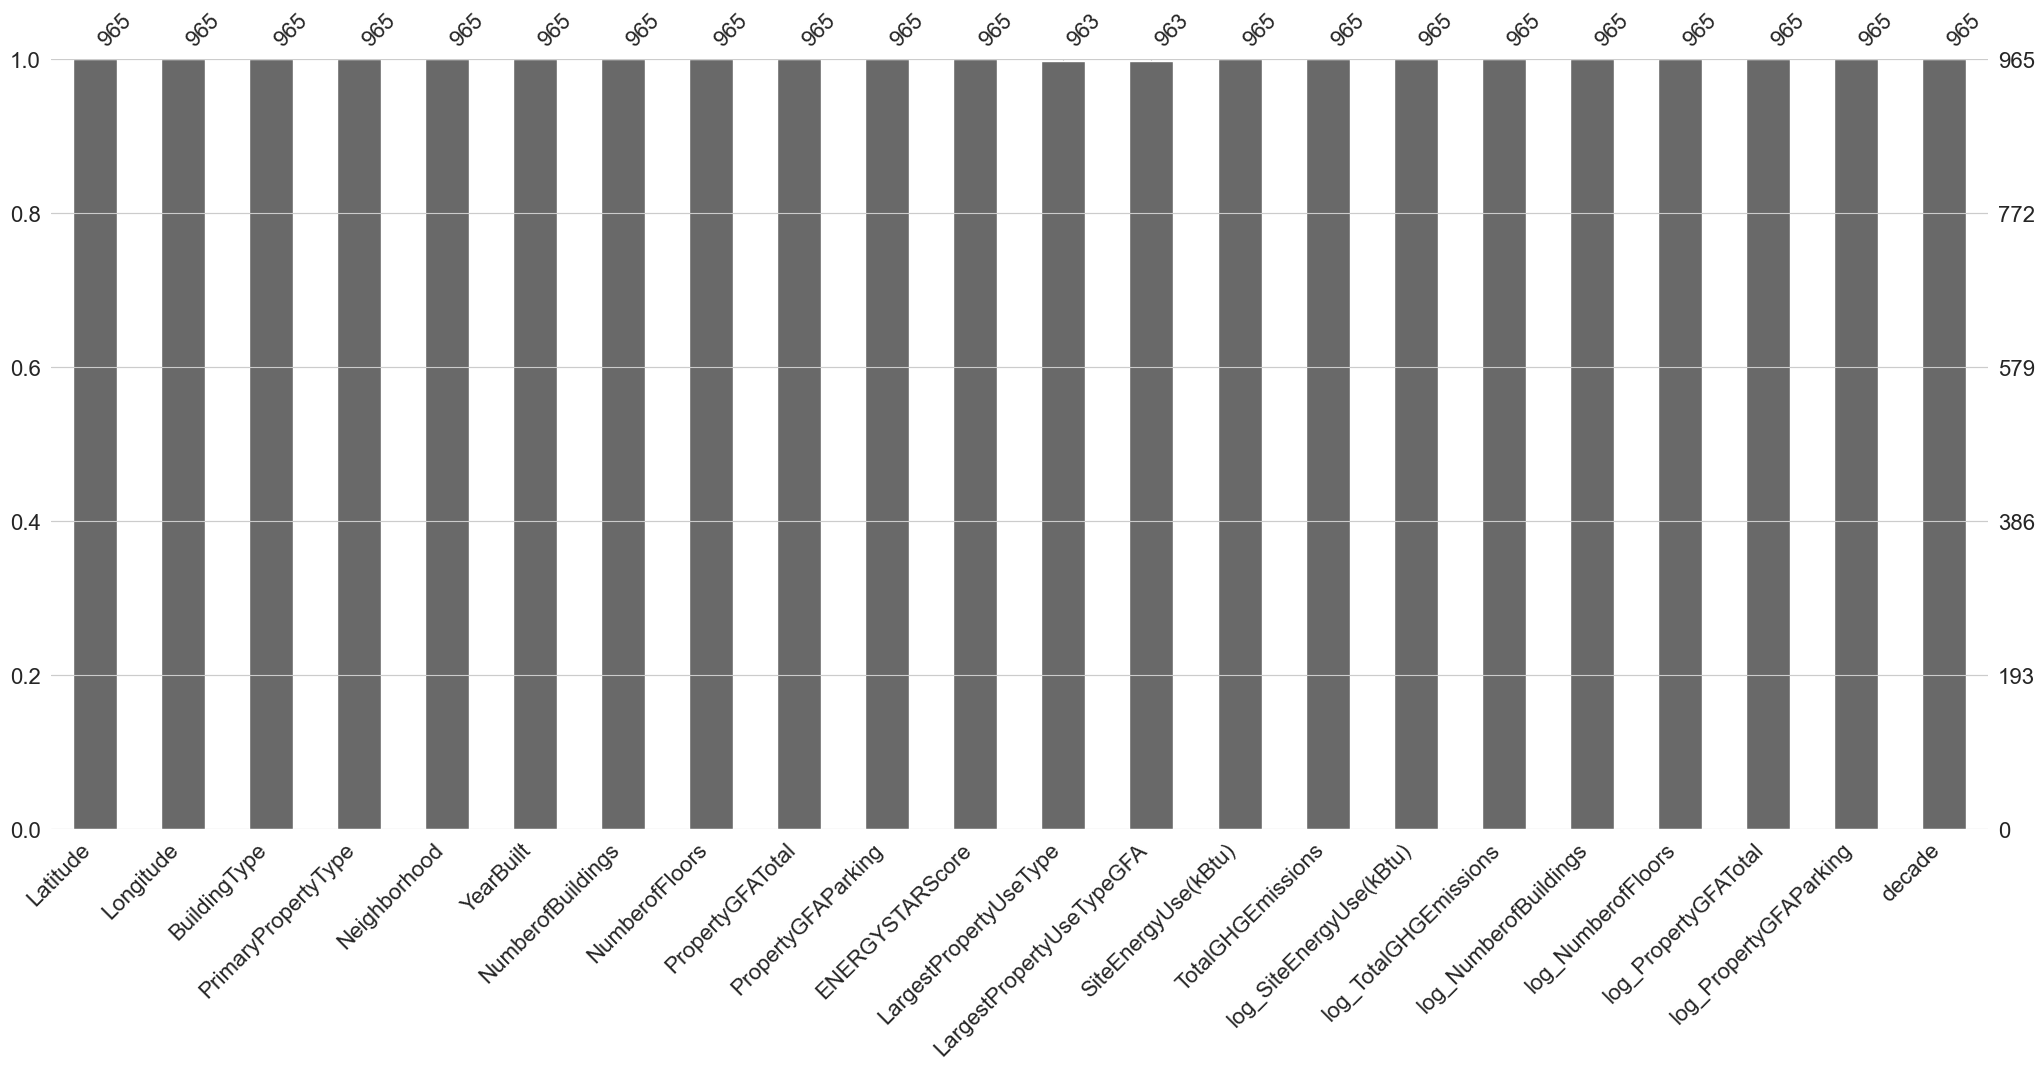

In [132]:
msno.bar(ds_w_features_energyscore)

In [133]:


# Features et target
features = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'decade', 'log_NumberofBuildings', 'log_NumberofFloors', 'log_PropertyGFATotal', 'log_PropertyGFAParking','Latitude','Longitude','ENERGYSTARScore']
target = ['log_SiteEnergyUse(kBtu)']

X = ds_w_features_energyscore[features]
y = ds_w_features_energyscore[target]

# split du jeu de données en 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Dimensions de X_train:", X_train.shape)
print("Dimensions de X_test:", X_test.shape)

Dimensions de X_train: (772, 11)
Dimensions de X_test: (193, 11)


In [134]:


# Features et target
features = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'decade', 'log_NumberofBuildings', 'log_NumberofFloors', 'log_PropertyGFATotal', 'log_PropertyGFAParking','Latitude','Longitude', 'ENERGYSTARScore']
target = ['log_SiteEnergyUse(kBtu)']

X = ds_w_features_energyscore[features]
y = ds_w_features_energyscore[target]

# split du jeu de données en 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# selection des colonnes catégoriques à encoder
cat_columns = ['BuildingType', 'PrimaryPropertyType', 'Neighborhood','decade']

# instanciation de l'encodeur
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# Fit de l'encodeur aux données
X_train_encoded_cat = encoder.fit_transform(X_train[cat_columns])
X_test_encoded_cat = encoder.transform(X_test[cat_columns])


encoded_feature_names = encoder.get_feature_names_out(input_features=cat_columns)


X_train_encoded = np.concatenate([X_train_encoded_cat, X_train.drop(cat_columns, axis=1)], axis=1)
X_test_encoded = np.concatenate([X_test_encoded_cat, X_test.drop(cat_columns, axis=1)], axis=1)


all_feature_names = np.concatenate([encoded_feature_names, X_train.drop(cat_columns, axis=1).columns])

# Application de l'acp de l'acp
pca = PCA(n_components=5)  # 
X_train_pca = pca.fit_transform(X_train.drop(cat_columns, axis=1))
X_test_pca = pca.transform(X_test.drop(cat_columns, axis=1))

# Standardisation des données PCA-transformées
scaler = StandardScaler()
X_train_pca_scaled = scaler.fit_transform(X_train_pca)
X_test_pca_scaled = scaler.transform(X_test_pca)

# Concatenate scaled PCA-transformed non-categorical features with encoded categorical features
X_train_final = np.concatenate([X_train_pca_scaled, X_train_encoded_cat], axis=1)
X_test_final = np.concatenate([X_test_pca_scaled, X_test_encoded_cat], axis=1)



c:\Users\jules\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [135]:


start_time = time.time()

# Instantiation du modèle RandomForestRegressor avec les meilleurs paramètres
rf_model_best = RandomForestRegressor(
    max_depth=20,
    min_samples_leaf=1,
    min_samples_split=10,
    n_estimators=200,
)

# Entrainer le modèle avec les meilleurs paramètres
rf_model_best.fit(X_train_final, y_train)

# Prévoir les valeurs sur le jeu de test
y_pred_test = rf_model_best.predict(X_test_final)

# Calcul des métriques
pca_rf_star_r2_test = r2_score(y_test, y_pred_test)
print("R² Score on Test Set:", pca_rf_star_r2_test)
pca_rf_star_mse_test = mean_squared_error(y_test, y_pred_test)
print("MSE on Test Set:", pca_rf_star_mse_test)
pca_rf_star_rmse_test = np.sqrt(pca_rf_star_mse_test)
print("RMSE on Test Set:", pca_rf_star_rmse_test)
pca_rf_star_elapsed_time = time.time() - start_time
print("Computing time:", pca_rf_star_elapsed_time, "seconds")

C:\Users\jules\AppData\Local\Temp\ipykernel_21172\1512214847.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model_best.fit(X_train_final, y_train)


R² Score on Test Set: 0.8348634950835251
MSE on Test Set: 0.5029965204894488
RMSE on Test Set: 0.7092224760182441
Computing time: 0.7307064533233643 seconds


In [136]:

start_time = time.time()

# Entrainer le modèle avec les meilleurs paramètres
xgb_model_best.fit(X_train_final, y_train)

# Prévoir les valeurs sur le jeu de test
y_pred_test = xgb_model_best.predict(X_test_final)

# Calcul des métriques
pca_xgb_star_r2_test = r2_score(y_test, y_pred_test)
print("R² Score on Test Set:", pca_xgb_star_r2_test)
pca_xgb_star_mse_test = mean_squared_error(y_test, y_pred_test)
print("MSE on Test Set:", pca_xgb_star_mse_test)
pca_xgb_star_rmse_test = np.sqrt(pca_xgb_star_mse_test)
print("RMSE on Test Set:", pca_xgb_star_rmse_test)
pca_xgb_star_elapsed_time = time.time() - start_time
print("Computing time for :", pca_xgb_star_elapsed_time, "seconds")

R² Score on Test Set: 0.8368494759267804
MSE on Test Set: 0.49694733436660254
RMSE on Test Set: 0.7049449158385374
Computing time for : 0.047041893005371094 seconds


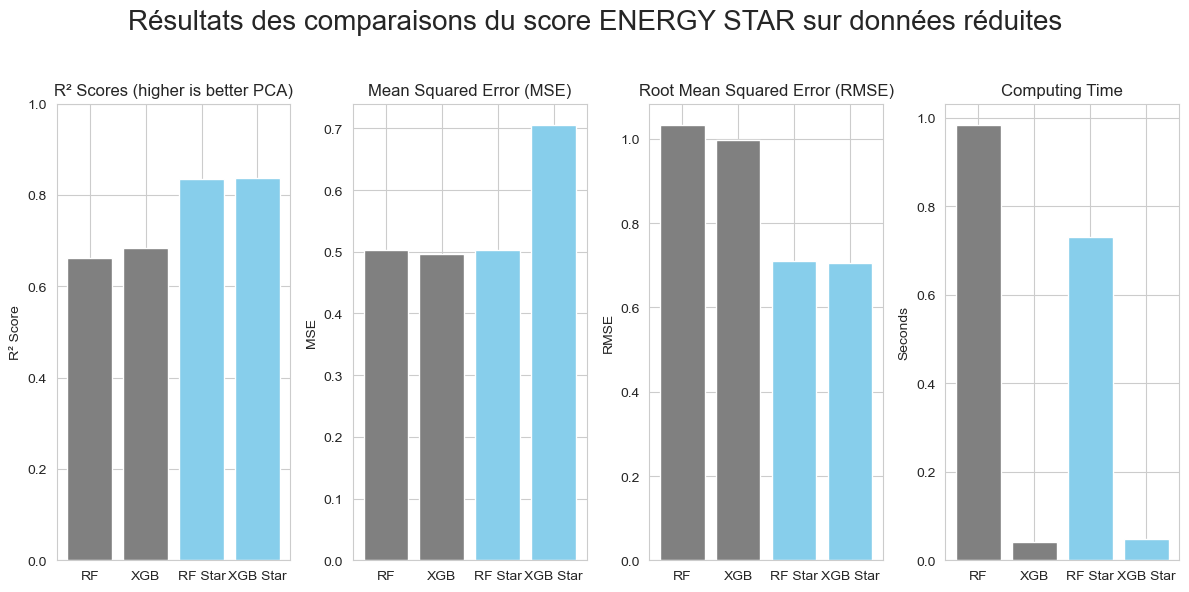

In [137]:


# Definition des noms des modèles et des scores
model_names = ['RF', 'XGB', 'RF Star', 'XGB Star']
r2_scores = [grid_search_rf.best_score_, grid_search_xgb.best_score_, pca_rf_star_r2_test, pca_xgb_star_r2_test]
mse_scores = [pca_rf_star_mse_test, pca_xgb_star_mse_test, pca_rf_star_mse_test, pca_xgb_star_rmse_test]
rmse_scores = [rmse_rf, rmse_xgb, pca_rf_star_rmse_test, pca_xgb_star_rmse_test]
time_scores = [rf_elapsed_time, xgb_elapsed_time, pca_rf_star_elapsed_time, pca_xgb_star_elapsed_time]

# Define colors with 'RF Star' and 'XGB Star' as deep red, others as grey
colors = ['grey', 'grey', 'skyblue', 'skyblue']

plt.figure(figsize=(12, 6))

# R² scores
plt.subplot(1, 4, 1)
plt.bar(model_names, r2_scores, color=colors)
plt.title('R² Scores (higher is better PCA)')
plt.ylabel('R² Score')
plt.ylim(0, 1)

# MSE scores
plt.subplot(1, 4, 2)
plt.bar(model_names, mse_scores, color=colors)
plt.title('Mean Squared Error (MSE)')
plt.ylabel('MSE')

# RMSE scores
plt.subplot(1, 4, 3)
plt.bar(model_names, rmse_scores, color=colors)
plt.title('Root Mean Squared Error (RMSE)')
plt.ylabel('RMSE')

# Time score
plt.subplot(1, 4, 4)
plt.bar(model_names, time_scores, color=colors)
plt.title('Computing Time')
plt.ylabel('Seconds')

plt.suptitle('Résultats des comparaisons du score ENERGY STAR sur données réduites', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])  
plt.show()
